Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [42]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob


In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# !sudo apt-get install p7zip-full


In [4]:
!7z x '/content/gdrive/MyDrive/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration.zip'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/melanoma/                                           1 file, 825007311 bytes (787 MiB)

Extracting archive: /content/gdrive/MyDrive/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration.zip
 86% 4096 Open              --
Path = /content/gdrive/MyDrive/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration.zip
Type = zip
Physical Size = 825007311

  0%      2% 212 - Skin cancer ISIC The Internation .  cell carcinoma/ISIC_0012079.jpg                                                                    

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
data_dir_train

PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train',  # Replace with the path to your training images
    labels='inferred',  # Automatically infer labels from the folder names
    label_mode='int',   # Return integer labels
    batch_size=batch_size,
    image_size=(img_height, img_width),  # Resize images to the specified height and width
    seed=123,  # Use seed for reproducibility
    shuffle=True,  # Shuffle the dataset
    validation_split=0.2,  # Optional: use this if you want to create a training-validation split
    subset='training'  # Use 'training' for the training subset (if validation_split is specified)
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train',  # Replace with the path to your training images
    labels='inferred',  # Automatically infer labels from the folder names
    label_mode='int',   # Return integer labels
    batch_size=batch_size,
    image_size=(img_height, img_width),  # Resize images to the specified height and width
    seed=123,  # Use seed for reproducibility
    shuffle=True,  # Shuffle the dataset
    validation_split=0.2,  # Optional: use this if you want to create a training-validation split
    subset='validation'  # Use 'training' for the training subset (if validation_split is specified)
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

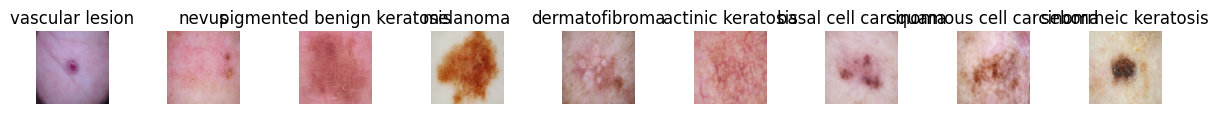

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
sample_images = {}

# Loop through the dataset and store one image per class
for images, labels in train_ds:
    for i, label in enumerate(labels):
        class_name = class_names[label]
        if class_name not in sample_images:
            sample_images[class_name] = images[i].numpy()
        # Break the loop once we have one sample for each of the nine classes
        if len(sample_images) == 9:
            break
    if len(sample_images) == 9:
        break

# Visualize the images
plt.figure(figsize=(15, 10))
for i, (class_name, image) in enumerate(sample_images.items()):
    ax = plt.subplot(9, 9, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 9

# Build the CNN model
model = models.Sequential([
    # Input layer to normalize pixel values between 0 and 1
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Rescaling layer to standardize the pixel values
    layers.Rescaling(1./255),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps to a 1D vector for the dense layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),  # Dropout to prevent overfitting

    # Output layer
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.2139 - loss: 2.2926 - val_accuracy: 0.3490 - val_loss: 1.7777
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.3670 - loss: 1.7119 - val_accuracy: 0.4631 - val_loss: 1.6411
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4799 - loss: 1.5292 - val_accuracy: 0.5436 - val_loss: 1.3740
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5241 - loss: 1.3373 - val_accuracy: 0.5459 - val_loss: 1.3366
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5502 - loss: 1.2826 - val_accuracy: 0.4966 - val_loss: 1.4132
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5871 - loss: 1.1749 - val_accuracy: 0.4720 - val_loss: 1.5229
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5609 - loss: 1.2164 - val_accuracy: 0.5302 - val_loss: 1.3550
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6098 - loss: 1.0784 - val_accuracy: 0.5347 

### Visualizing training results

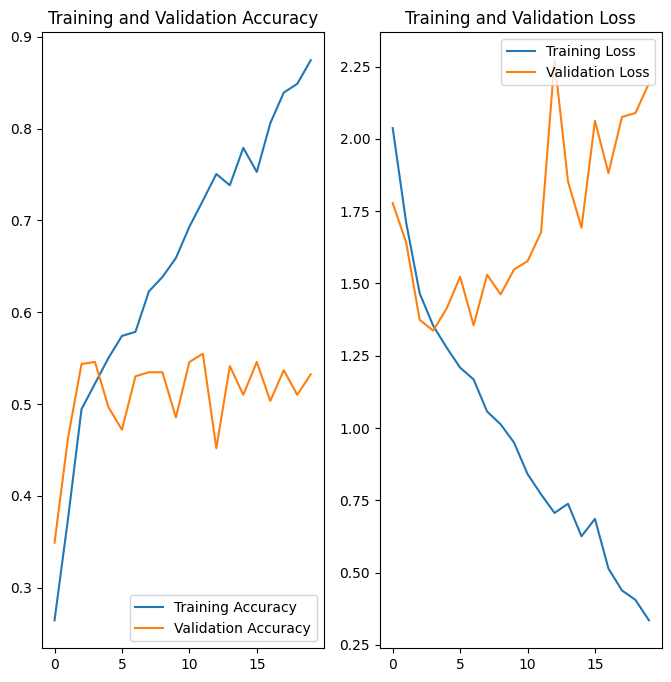

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8965 - loss: 0.2866
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5729 - loss: 2.0863
Accuracy:  0.8956473469734192
Validation Accuracy:  0.5324384570121765
Loss:  0.2777697443962097
Validation Loss 2.191821336746216


### Write your findings here

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


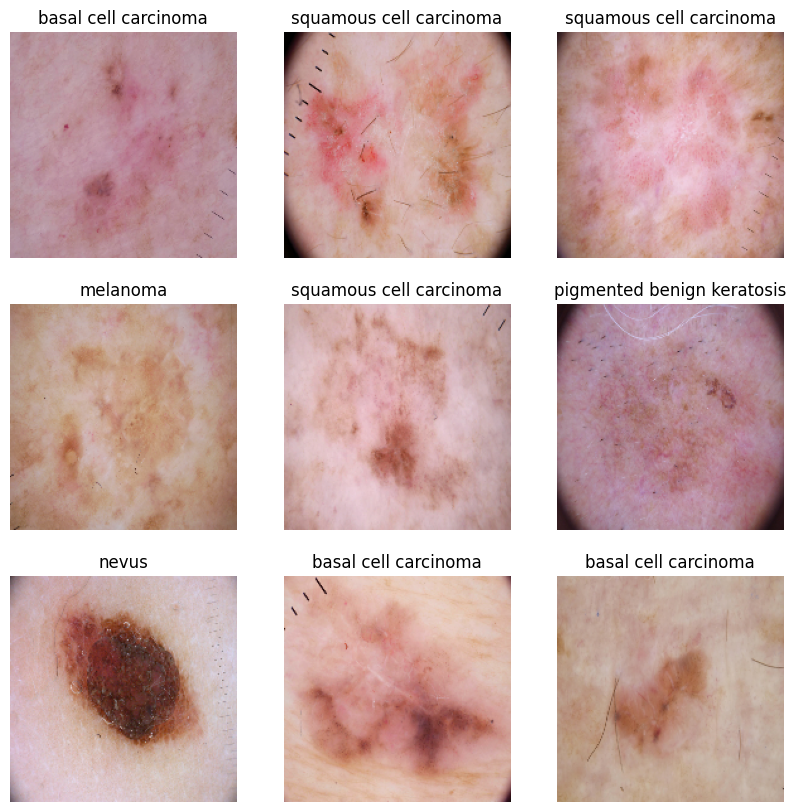

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9

# Build the CNN model
model = models.Sequential([
    # Input layer to normalize pixel values between 0 and 1
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Rescaling layer to standardize the pixel values
    layers.Rescaling(1./255),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps to a 1D vector for the dense layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Output layer
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

### Compiling the model

In [26]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.1979 - loss: 2.2749 - val_accuracy: 0.3244 - val_loss: 1.8823
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3743 - loss: 1.7628 - val_accuracy: 0.4497 - val_loss: 1.6121
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4349 - loss: 1.6203 - val_accuracy: 0.5034 - val_loss: 1.5160
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4884 - loss: 1.4419 - val_accuracy: 0.5436 - val_loss: 1.3957
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4742 - loss: 1.4632 - val_accuracy: 0.4787 - val_loss: 1.4984
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5132 - loss: 1.3730 - val_accuracy: 0.5414 - val_loss: 1.4413
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5570 - loss: 1.2459 - val_accuracy: 0.5145 - val_loss: 1.4105
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5515 - loss: 1.2716 - val_accuracy: 0.5481 - v

### Visualizing the results

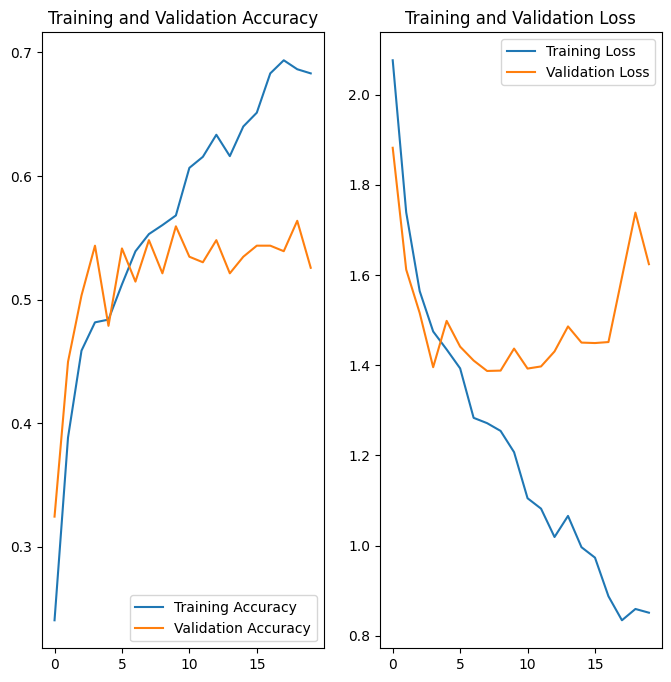

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [30]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7594 - loss: 0.6984
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5736 - loss: 1.5579
Accuracy:  0.7544642686843872
Validation Accuracy:  0.5257270932197571
Loss:  0.689827024936676
Validation Loss 1.624171495437622


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

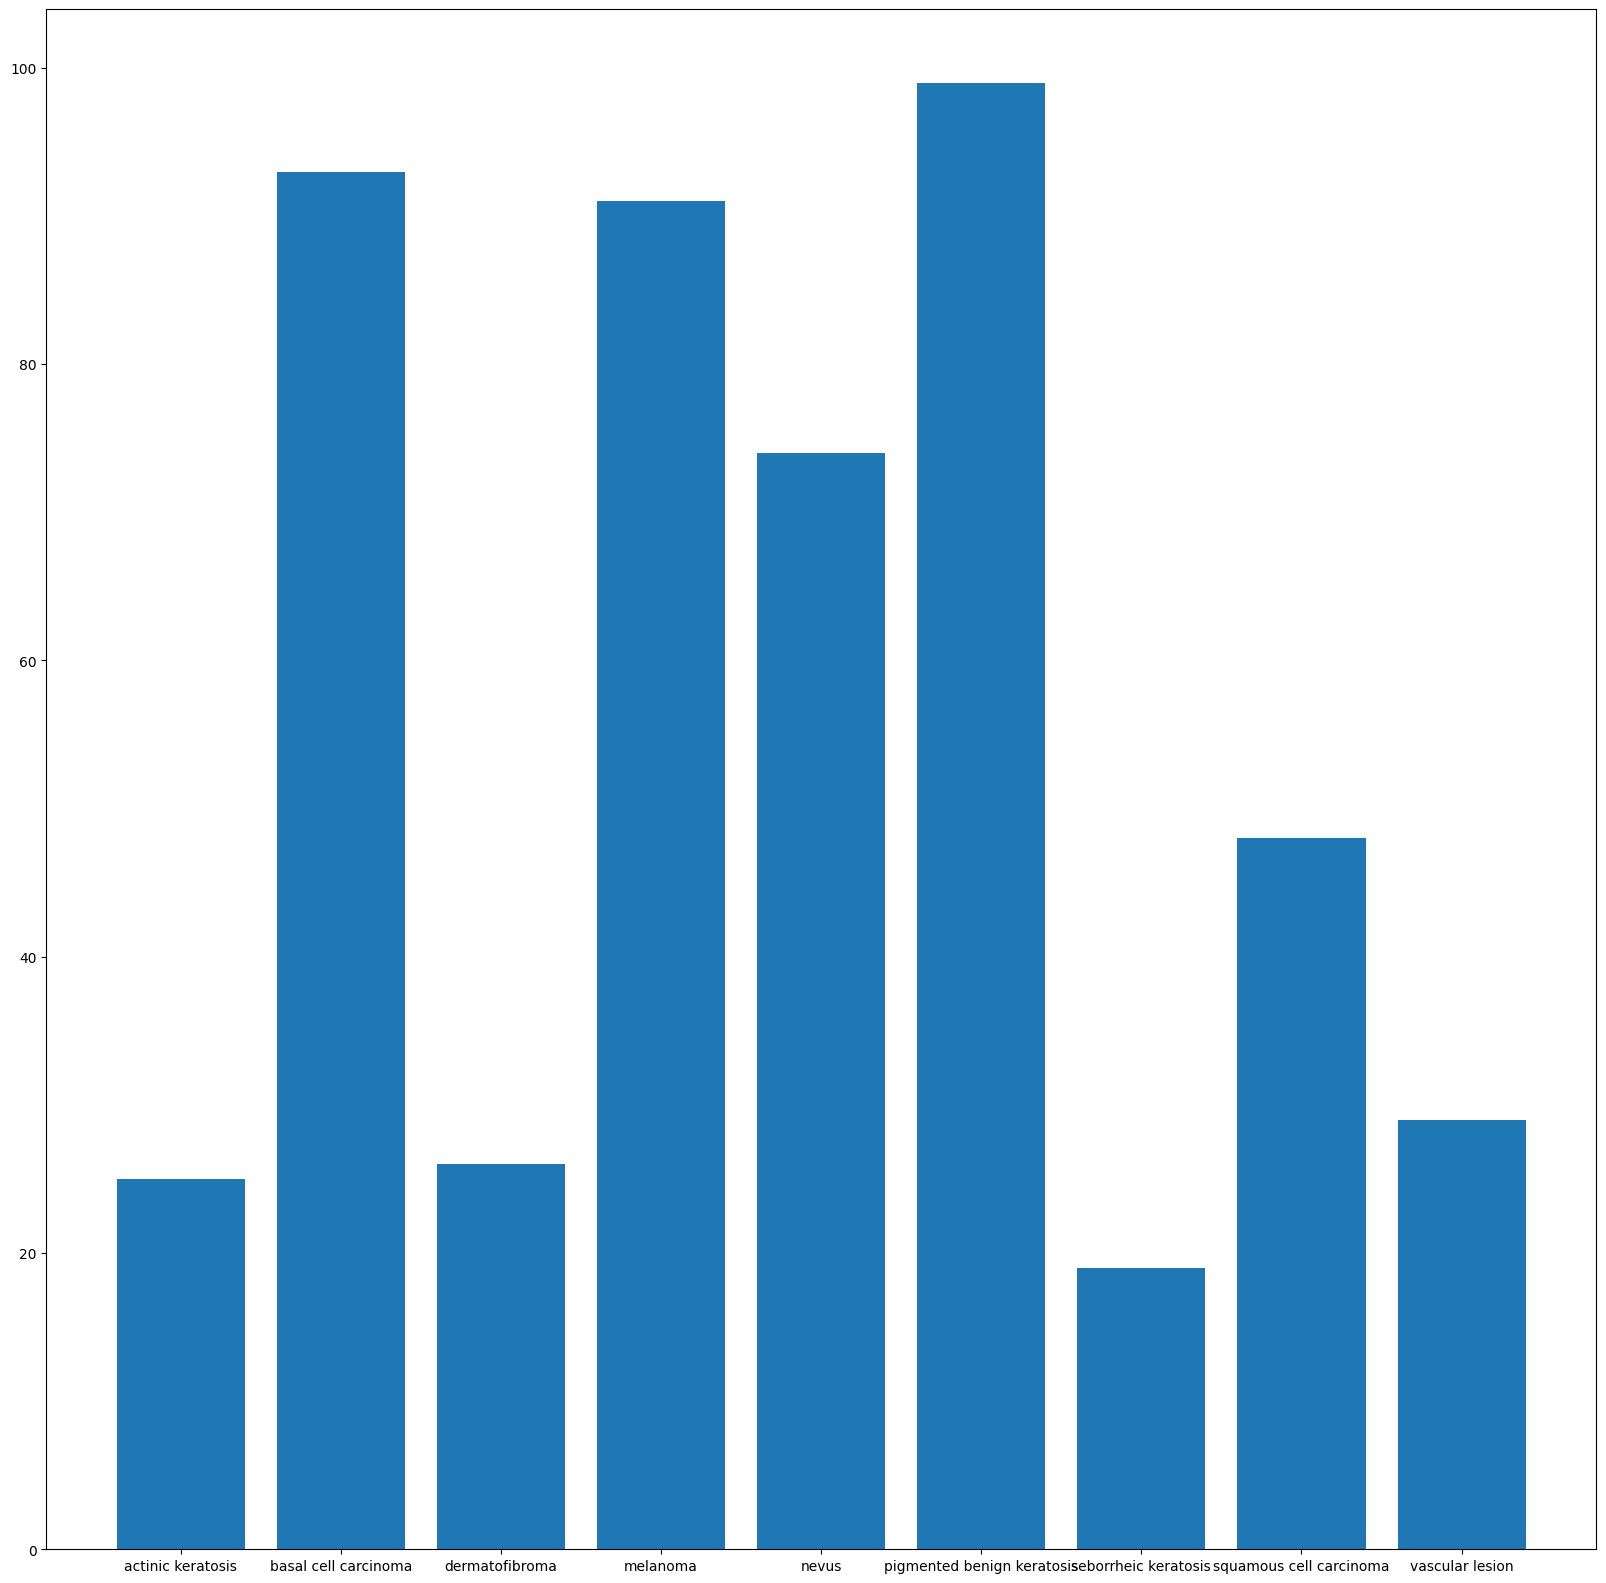

In [31]:
## Your code goes here.
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA8282D3AF0>: 100%|██████████| 500/500 [00:17<00:00, 29.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BA81D647A00>: 100%|██████████| 500/500 [00:15<00:00, 31.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA81D6000D0>: 100%|██████████| 500/500 [00:16<00:00, 30.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BA81D7EF370>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2012x1956 at 0x7BA8282D3F10>: 100%|██████████| 500/500 [01:12<00:00,  6.90 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA828120610>: 100%|██████████| 500/500 [00:15<00:00, 33.21 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BA81D51F040>: 100%|██████████| 500/500 [00:36<00:00, 13.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA8A7F545E0>: 100%|██████████| 500/500 [00:16<00:00, 30.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA81D511A20>: 100%|██████████| 500/500 [00:16<00:00, 31.00 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [48]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [51]:
# original_df = pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
new_df = df2.copy()

In [52]:
new_df['Label'].value_counts()

,count
Label,
squamous cell carcinoma,500
vascular lesion,500
melanoma,500
actinic keratosis,500
dermatofibroma,500
pigmented benign keratosis,500
basal cell carcinoma,500
seborrheic keratosis,500
nevus,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [59]:
# data_dir_train

In [57]:
data_dir_train=path_list
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

TypeError: Expected binary or unicode string, got ['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031211.jpg_c8e57ed3-5bc6-44e6-894d-5229f648be6b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030280.jpg_945b1ab3-8650-4b43-902b-50d8aacf406b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_44bab74b-3991-44f9-9837-7d050d05ad71.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025790.jpg_7127c23b-df52-40d0-8d20-20d68fb1e120.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027700.jpg_94004a78-5f28-4543-b074-22147566b308.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027047.jpg_fc02d876-46bb-46a4-a341-68cc66011db7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032173.jpg_d369428b-f20e-4ab1-a3d2-7b52e90e1cce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028644.jpg_7f6aa8f2-d8bd-4a98-a674-6f248a5a3777.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_71dc491d-5fee-4399-bb51-1bb3ca6dd9d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031743.jpg_f266b2b8-8be3-41ce-91a1-da4a78d52ce8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029573.jpg_2d76c01a-acde-4c65-b4f6-61777de87178.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_5ae0c9ab-aca7-4d09-9b83-67a362003fb5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025411.jpg_f76ee94d-bb2f-40e1-b859-5dc6bd7c7b3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031692.jpg_952df4a9-32d0-4379-af39-4566a386755d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_7307fba5-1359-46e2-a7ba-17dba6c7ca82.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028816.jpg_16e132b7-6ad0-4744-a8b3-c130fda937c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025029.jpg_f647f131-7cf4-4e44-aba7-c349201dd545.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_6bccac86-2ab0-4924-8d71-674e097f88c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025178.jpg_9c80ae4c-65db-48d0-aef8-e6c8e4f5bc97.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030803.jpg_4d854ad3-9290-46a2-941c-6fb2ef5f96f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031929.jpg_928e989e-e9ba-4ba8-9f7a-a96a0d08648d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029860.jpg_6ea639f7-6b9c-4a21-8572-44891747827b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032897.jpg_5f35f62a-760c-4120-8700-40f12297300d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027178.jpg_b5ad5a42-c105-4916-ad02-c4681f6c9d14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_de30abc6-4777-44f3-a01f-cc1279d809f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029715.jpg_3d2b377b-ad0a-4f5f-83a4-bae248bb0cc3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031852.jpg_e57017fd-a6f7-4e9d-8514-50cdbfe6373d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028232.jpg_1387c5ba-b22d-4d34-86c4-22a52d83875a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025029.jpg_dddc3fe3-762e-48a9-8d3c-81f33247c015.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024923.jpg_b25460ab-d226-4393-8e47-c468c3af06a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025178.jpg_4777047c-7ea1-4b50-b23e-718e00e09131.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028132.jpg_b0a9bf79-cb21-4c66-973a-df5c7540b2e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026388.jpg_0ed1f6d7-dda0-43ac-8aee-9bf735a3feda.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032349.jpg_b1cc39c7-fc44-4e42-9b88-efb9a7b24103.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025811.jpg_144542bb-a942-43d1-9771-23d744ebb565.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026083.jpg_04fc0c63-2798-4eb6-9205-5f94ce66a101.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033295.jpg_4f706881-7832-412d-9aa5-40d7bb438ef8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_cfa04e1b-92bf-4df5-af7e-6ab96ad7006f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032173.jpg_77863caf-ead5-44b4-8b73-6c9746d36d27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025331.jpg_263d01b3-ac24-4714-aeeb-37ccfd6c4001.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026645.jpg_eb94ee39-1bf8-4141-b80b-938d39075855.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031692.jpg_5f388645-8b43-42d5-8eeb-5413134b3401.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025029.jpg_9ea40c3e-138f-4bca-9eae-1ff135373f0d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025358.jpg_3431a822-61d6-490d-b49a-00f2836148b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030297.jpg_462b44dd-58d2-4b8b-8c3b-1921db5e269b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030245.jpg_900242a3-95d0-4202-b2eb-544d871ff72d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025130.jpg_cab6e7cc-e6c0-4143-8ec4-739ba6c897a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026492.jpg_9deeb941-bd6c-4370-8d95-836fd7926457.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_2a2ef443-ef6c-40de-a0bb-ccf5528ff4d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027178.jpg_ea4144ab-25d7-4af0-9e50-476fbde4118e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030158.jpg_3e855cfc-5d9a-4d30-a33b-aee262a44a72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032154.jpg_5d5e23b2-03f9-4ad1-840e-419eeb929eca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_258b35b1-f5df-463c-9f4c-02b6de8e8a6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031940.jpg_3a507436-596e-46b3-a50a-6fc1f8dcf8e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025264.jpg_75b3b78a-7b1a-441a-ae34-8e57cace3072.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027343.jpg_a5d931ce-5db5-4387-9508-51e621c0894d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029002.jpg_0539738e-ebae-408a-a3c1-c8b8699ed0d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028499.jpg_3ab0f0b4-6e09-4ab2-af20-b4808bba867a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028231.jpg_fe84b89a-d4b5-4484-8315-a410560fb106.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030827.jpg_c91a98d1-9928-4dbf-ac6f-23ae20b02a9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027184.jpg_31e0aa05-17f0-4cfb-8bda-c1ec92a5bc52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027930.jpg_81c194b4-1d26-4c03-a009-cc2a21bdf89c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026872.jpg_1942617e-2fed-4295-9de7-07ffb4f9b605.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031940.jpg_f2090f27-009c-49ce-b47b-b675e367f54a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029362.jpg_20679b07-33f8-432a-93f1-a3851365a9e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027084.jpg_7989bb36-e61e-4646-b365-1b20f88ac33f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029715.jpg_ebb14405-39f4-44f5-88f6-047ba79ae870.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025196.jpg_e3758cb1-a3b1-4d6c-8218-c3da5eac3af8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032014.jpg_9cc8b51f-1713-47fb-a114-9b900cd6f6cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029315.jpg_3feb1486-e3b7-4ad4-b77c-dfea885980ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029610.jpg_1428c712-6652-4b51-8598-fe3ac157599a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027577.jpg_e48ab777-cb95-4e68-bed7-79ebdf6aed97.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026178.jpg_dedc1896-cdb3-41c9-adfe-aa3862cb2e94.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029043.jpg_92bf827b-7b72-40b8-9bb9-5ff2be891593.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031927.jpg_11a53ff5-23b5-4a3f-8dd8-d4560d63c583.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_2c35028b-ae62-486a-8c22-52279debec44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032897.jpg_7697e320-22c0-430d-b2b9-fa6cf6c9745f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025411.jpg_00f3f347-7e18-4ccc-8cec-882451cfa205.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026411.jpg_3baae5a6-7f59-4536-8e24-aced852c1ebf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032173.jpg_d9143add-c45d-43a2-aa7d-cc79444d5bc8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029851.jpg_31d5567c-fd66-4c90-8129-9fc916accaec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028335.jpg_6b2c5fa5-6333-43ad-bd7c-bca1a89b98d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029002.jpg_5e2c4ab0-5d2f-4957-aeee-7ee65e3990ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029811.jpg_8faa9539-e243-4cd7-be70-1ead0dac5b81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027930.jpg_648318dc-9930-499e-ae6a-fc0686fe3d19.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025247.jpg_5c6507f5-dcb9-4882-93f2-d88fb924c48b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029549.jpg_28261e32-e34e-475a-82df-3d9102c5b8b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_2d5d208c-3583-48bf-9495-3752ebd396b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029715.jpg_27cc026b-096b-472a-8430-e33ecf55fc0b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029860.jpg_7678df5e-71f0-4c5a-9cec-40bfedba7728.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029043.jpg_04e467cf-cf5c-481e-a772-e8bb207f4bb9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026178.jpg_a783b562-37bd-4225-b1dd-36d8df50be59.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031431.jpg_e0da2ae3-1c0b-4bd2-a80c-2b969a4db657.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027303.jpg_2dd7fbb9-4467-476e-8583-cbf9d5106565.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030827.jpg_ba9609db-a44e-4db2-a9fd-5a7ef899196e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029315.jpg_848ae017-727c-4f8b-b598-9cc37fda4a56.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032455.jpg_c19bf07b-1439-44a1-8bf8-1d05802e7423.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026466.jpg_e494bfc6-513e-48bd-8b49-5e9937d2c495.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031198.jpg_52268b7f-2aed-4339-b725-5e65491b70dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_30e152a2-6636-4357-ac27-ffa857f093f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031043.jpg_2e23d9e9-184d-48f4-927b-e3ffc3a7f1e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027047.jpg_bcda0415-7518-4800-ad21-2e5aecef5228.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031578.jpg_02a5d6f7-6656-4efa-aaf9-1462107a7cd2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031929.jpg_9eddf9f0-8d6e-452e-9f1b-ab2ba8947228.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025331.jpg_9062120f-d9ed-4b6b-beea-387539e69378.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027178.jpg_887596f2-e4e9-4a0d-8895-611b0074d777.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_71d51135-0152-41de-ac02-14e49ea09bc1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032356.jpg_9b31a1b7-eae9-4ed0-a0e6-8a651459b697.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031918.jpg_f6bb3888-8293-41a7-bba2-e92e5ffe5a2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027753.jpg_6c57c9e8-26d2-450d-8b6f-4c97e092b7e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025539.jpg_fb5c07b2-c7d4-41a3-ac68-5f2272bfba8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026720.jpg_1ae5b5e8-0b8e-4e23-abcc-a8512652098e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029315.jpg_5c7063aa-dbd5-4bb6-9263-b2cffe826c3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025808.jpg_fe08009f-cbad-430b-a5bd-0637721643fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029715.jpg_3c3f4169-8a4a-488a-8753-55ea88c0a88c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025637.jpg_b85e1b71-41fd-461a-9ec1-1756bfba6a13.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026100.jpg_182406b3-74b2-45f4-8ad5-ea4f3e3bbe29.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029067.jpg_f324093b-3d38-4b4f-bb05-33d70e41b5d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031043.jpg_e9a358e0-a713-49ff-a70e-3b310c916ba0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028132.jpg_9af3c165-f690-40a7-8569-70ac9170bb78.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030591.jpg_a5e88f0d-9544-40a8-91f9-9c619776bf76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031874.jpg_be338128-5cef-40a7-b25b-4d62fbe67920.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032329.jpg_6432b757-4655-4c7a-88c8-5c273a4aeb95.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032356.jpg_92c4b4d9-d130-4aeb-bfd8-ee47ddc90e7c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025247.jpg_79654c89-453e-4ce0-8148-7897cb95dfb5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_18dd5f74-4470-4a74-8aca-248384be5714.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026388.jpg_c8a236d1-02a7-4a63-bbf7-017c928e69ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025471.jpg_7defa111-2769-4631-906c-d41c678cbff3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033000.jpg_275d928e-f6ab-44a8-8148-4d53bbe9fde1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030844.jpg_2ba8c410-e2d0-487b-82e4-08c71a509a80.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027577.jpg_2cca5ac4-853c-4fe5-8493-0d16665b3560.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030827.jpg_29bc65e0-9f5c-49e2-ab49-aff2d7b5a58b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025264.jpg_2dbfddc8-8da4-4a7e-8b53-9053f33a2352.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_750bf20b-9e7b-4d0c-9ec1-68ea6aa2cdd7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_9b0bc609-9948-4c89-bbc2-22f81c99d5ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_d8307124-cb94-4891-8902-dda9fc58d598.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030245.jpg_2c1b004a-c7b6-43ee-8b27-f4251c7b6ea7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028381.jpg_b9a6f3c1-2f36-482f-ae7d-9ffb2109b7af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032238.jpg_69f7005f-7b61-4859-8622-f7c41ade1beb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030794.jpg_ac9c9d6d-744f-4999-8a17-3475b5afdb95.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027303.jpg_fbf7ccb3-6ab0-4f1f-b132-932c00a3edb9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032014.jpg_8c260726-535c-449f-b160-3ea09f246985.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030175.jpg_4c99d5f2-4dbb-4b7e-a505-baa4bdecb2bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025247.jpg_12fa27f2-d072-4081-ad71-9bd706696411.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032238.jpg_5ec72a8e-de39-4d5b-a384-ef372885b1c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028795.jpg_5b0d6d72-f889-4350-9dd2-20400045515b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024843.jpg_071716e4-08c6-4d18-a3d4-dd143a52f60a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027529.jpg_375e7580-6a3a-400a-a202-9b81c833fbf1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031198.jpg_d1092075-740b-4309-aacf-25b89dfdb154.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030827.jpg_85326b8e-abf8-48cb-ac4b-39629a82dd07.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029573.jpg_ff657c58-0f9a-42df-8a34-b90fe2ce1c8a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031043.jpg_0db98e47-1ba1-4a20-a35f-da803fa1c0c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025178.jpg_aca0bb7b-27d6-4399-860a-acf2d2993232.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031043.jpg_a52211d6-265b-460c-811e-31f7a70df922.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_8acc5f5c-0100-4b03-8e8f-5aad3da04b72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_7702ab4d-dec8-4c2e-92d9-4125c0510101.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028231.jpg_5d18ac23-6150-4a55-be26-bc3d4814eb9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027343.jpg_2470e33a-e65e-4d47-a7f6-f988f251ec14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025411.jpg_c551656a-147d-4753-adde-d27dcaf25044.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027343.jpg_77d40e9e-22af-47cd-bc0e-d2c9a6177d8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028499.jpg_6e581f55-15a6-4f91-bc20-1564dee2e2f1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_2bf79560-f75b-4e4f-8b0a-c518d84a4aa0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030191.jpg_42e0cb46-637b-4820-a8db-eff4f018f976.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025089.jpg_72484c88-0e9b-4a3b-a86c-2d6d284fbf14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029549.jpg_f0220c9c-cf21-4356-91fc-deac25f7cb51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031198.jpg_ea2921e7-be18-4ca7-bd35-61b0408a723e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032356.jpg_4024e813-fedb-4141-9f15-2c520464620b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026645.jpg_e40ffa29-2bb7-4fed-91fc-beb0250e78e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030844.jpg_dfaaf6fe-0214-4969-831b-57dea0ad79c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_8918a1bd-6297-46cc-9f1a-32682fdb70dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026522.jpg_0081d180-47a5-4501-99a4-ed10facfdf27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029582.jpg_e37a1846-7b09-4d34-be28-b1d85387c96a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027767.jpg_6a82ab3d-5086-4603-9b3a-5a1ada8dc588.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031012.jpg_bcfd13f3-9877-4fef-b259-080121662924.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033084.jpg_47324859-6f1f-42e0-8224-0821ee0727f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_8d58d8b5-0cfb-4385-a526-d1d4193f06a5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025577.jpg_a0caf280-f035-4f60-aa30-bec6fa338d69.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028763.jpg_3f95ae75-c1e0-464c-8511-65a71926937b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030714.jpg_f9f7fa23-effe-457d-a9c1-783c64d9ce36.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026992.jpg_b8bfa68d-81f2-4061-9917-9c5980f4a00d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026100.jpg_6bd081eb-63fc-41fe-aaad-29adb69417e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028816.jpg_83ddf6ec-2ebb-44a9-875c-85bd92582e15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_9c15ff2d-f1fb-4e79-9ffb-ac8b0363f1e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025539.jpg_5b7092c6-7857-4068-a297-49db2b798c86.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027084.jpg_dde64dfe-da0d-4763-b870-503455db07b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030794.jpg_748665d8-565e-4c83-9bfa-bfac8db010e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024710.jpg_0b75faad-daf0-40f0-8d03-6943469d6479.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031874.jpg_bb9c27a7-21a0-4984-9fe8-adde5579305b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030803.jpg_a0466850-9022-4154-bb31-3b8b40e74a65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028381.jpg_d27566ad-26b1-403a-ba47-f751a8799bca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032329.jpg_33c4994b-3bf7-455a-b592-188bd0ea89f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029851.jpg_51b0c908-b855-45e0-baaa-bb33c18c01c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029638.jpg_2d368969-ee2d-4655-8bf7-fa95ec1a48b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032897.jpg_9e908362-4f1c-473b-b22a-6f138afb2775.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_d267e3be-9cdc-4cf7-91f4-84e8a9ed437a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030387.jpg_2615258f-0d20-44ec-8c47-a43b16a6817b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032173.jpg_431878f1-2ad5-4981-8b6d-59784605c95d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029811.jpg_d272a489-a383-4efe-a85f-cb089a900daa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026388.jpg_2ac12cf9-7d0b-4de2-82fb-21fd95a11007.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026645.jpg_a6c8579d-6d6c-4e28-bdf3-c0e8b72e8f91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031743.jpg_5b96af71-a405-4a43-a2d8-5a449438bb83.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029573.jpg_94e1b234-d561-4477-b79b-5330e471ee57.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026138.jpg_86c84f04-08aa-4b97-a32a-cd4e29661a90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026203.jpg_17e628bc-6ae6-485e-a158-8829304d752c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029573.jpg_8c931046-4630-4216-aae5-4ecd9bf3ae8c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032397.jpg_82893c04-53c3-4db4-8999-0cecbd7e34ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029362.jpg_06aeaf3d-930b-4652-85aa-109b11cb0ef2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027184.jpg_5cfc56f9-c4e9-40c8-971a-c65875f00216.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029582.jpg_0c0abbec-509d-46e3-90df-1c12a61a5149.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028224.jpg_9a70fef9-0f76-4215-9b57-1a3658d5f87b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030487.jpg_39878861-6a78-4f70-a54a-c4401f3dee32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028232.jpg_127c8127-e49d-44d0-9331-d04b4e8f54b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030191.jpg_42d7eb80-8a33-416a-a91f-029bcf1accba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030280.jpg_09642178-f8dd-4198-8495-3c6161bbd911.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029811.jpg_c66fc664-56f8-40f2-96c0-d0cc19594846.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030707.jpg_9fc1302e-6d1e-453b-ba65-43fd3ed08ed5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030341.jpg_0909c9c0-ef01-4be2-bfe7-71a2418da900.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026083.jpg_399c17f4-29ed-41d2-8964-0032ae7b57da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025089.jpg_b57164f3-47d2-48f5-9e2f-ef2b127d3dff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033536.jpg_4703ad50-58be-42ed-be4e-7a4186ea226d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027529.jpg_9c5c21a5-b495-4da0-a2c0-27f1b5519f14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027084.jpg_a4cd1d58-c08d-4ca6-bb44-17198de5fde9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029563.jpg_a84b5611-1463-48c4-9b88-ef16c701e864.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_06c665e4-93e1-4af6-83b2-6838e352b375.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030191.jpg_c31a1959-12ae-460f-af94-2be1eab24790.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028816.jpg_91235767-9126-410f-bd6a-209a44d04f7d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032455.jpg_78e52322-1f30-43fd-aadd-d9753f035634.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029582.jpg_34505377-9687-4546-bcda-cbfee791fd75.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028872.jpg_0a3c6866-629a-4e31-acc7-f01f28d02963.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026132.jpg_41cd1e37-6d94-4625-8f64-69a4f090416b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031659.jpg_f8695818-d88b-4bfe-a50e-9aa5fcbe44c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_1d3b8c47-ed6e-4e87-954a-0d1ef4f6dc2b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028644.jpg_2d51b9ad-8f20-4456-9c31-5d82a7f1325d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027231.jpg_55e2aa79-489a-4096-a45c-4f904c5a8fe8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027047.jpg_f403ed1f-3d11-46b0-8121-473180825f34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026132.jpg_1a28c65f-3eab-409f-b89a-44cde550d824.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_9ac2cebe-2071-4a66-a31d-c7e7a6630dca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_2e75293c-94dd-48ef-9455-38c250796b08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030487.jpg_d89bbb31-45ac-4044-abd6-c12e16f0a6cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033084.jpg_df4ab477-7ef9-4fc3-8c58-aa5ab78de897.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030387.jpg_65f8e5d0-2cb0-463b-80a1-0fb19e289a4d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025196.jpg_95c71ff6-79d1-4e35-9136-4f78f077b0bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025539.jpg_67e6f737-a38d-4dea-8e22-ab8ed5386374.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030794.jpg_f576bcbe-924e-4b9d-8c3f-0cc9efb4deae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027231.jpg_5f8e817d-01b1-484b-ab19-ee4d24995aad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_94c59673-1d00-4be8-8fa1-82543a763cff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025089.jpg_6e31efee-2723-4c25-8766-ad3b72d97bfa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_6530d749-0d89-44f9-9c87-7c393ae7870a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031421.jpg_bd80449b-7e93-4516-82b3-41af5586c2cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032947.jpg_632b102a-39eb-4429-87ca-fbbf97c1335d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025811.jpg_1fd755d9-b040-426e-8169-31a90bdd0184.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033869.jpg_65a9ace2-4f4d-429b-a0b5-3fc70799a5fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_a3865ffc-99c6-4822-aedf-8ca67af924ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032277.jpg_27444729-c147-4890-aaae-734af1a834a7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031570.jpg_2555e585-3718-4d3e-ad44-e62a25e1fd4e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031929.jpg_441d1278-2c17-4c70-9925-4feb008528ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031198.jpg_4cf4362d-ae63-4a54-87f1-673ef9ca85f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025247.jpg_e6d420a1-0faf-4070-84f4-389784d71f51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027178.jpg_fd9e2f0b-2f8c-40a0-9ddf-ad1743b617b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032356.jpg_f14d5367-ef0a-4993-aa0e-f4bec4869620.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027184.jpg_f170f330-ed11-4b69-ad6c-ad51ccb2512e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030844.jpg_7a5f712d-091a-4357-932b-ccce9e30276a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030591.jpg_eddc2a21-3b20-422d-b635-6d48b97fa71b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032173.jpg_a7cd852a-2190-44c2-bcac-26cdd569ccb6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027930.jpg_6559eec2-57f3-482b-abcc-209bc972b738.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032238.jpg_af07e367-c1c2-4ffa-9543-6630d168b3d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029067.jpg_5e0296d7-d57e-4156-9ab8-9797628a4a96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029573.jpg_94dd15ff-1f28-47d9-a11d-d03f8c4897b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026466.jpg_7ec490a8-dd13-4f3e-9f89-12d55e08a75c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032897.jpg_6f7abb21-691d-42ef-a8b1-371229874e3f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031874.jpg_ece54c1d-9778-4ac0-b3f8-6134aeb7f7dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027700.jpg_597feda4-859a-4184-87f2-91824aad23b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024923.jpg_bee7d0f5-68df-4215-914e-4cce9759c19d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029610.jpg_b7e90e87-1308-4c28-9018-d2627edbd244.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_5f3e01c8-9692-4e96-a2e8-733b8a695bdd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_254b2217-468c-474a-8bd1-c0d78ad75809.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030487.jpg_81a06111-0e92-4edb-9916-b910a6c6c3e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026178.jpg_c48c62c4-1a2b-4c8e-9663-dfbf223969e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031198.jpg_e5c324e7-7312-4b3b-9c4e-a07f968a9dd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026645.jpg_fe16c76c-25b1-4ab9-96c2-f2ebb850061c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030341.jpg_f1357440-243f-4730-ac5b-5c57dc25fc03.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032203.jpg_8797dc1b-65bc-40b5-a179-6f8f5d862dac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025178.jpg_cb367161-0733-40e1-bf43-2f0bd8a38e7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031043.jpg_e5645aac-537c-43dd-87d0-afc1517b0058.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030387.jpg_4846ce85-2e56-4548-9d44-232d029f1010.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_88e1775f-b043-4f60-aea5-6fda753e7855.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028232.jpg_3d9f7e98-7e52-4af0-a872-bc6906f39969.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027767.jpg_a7cf60c3-938b-415a-a949-aea7be907ea9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031918.jpg_42332fbf-2778-4876-9f3a-f055cf00baa7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025130.jpg_5131d9a4-a48a-4c9c-80e1-3371088040b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030602.jpg_3906d893-4bed-43b7-b48a-806a0129431a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030803.jpg_2c2e2129-6be9-451d-8bd8-de8d1b2762cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033084.jpg_8c7e11f7-462e-465f-b9ef-9fcfa2464ac8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030076.jpg_ab5657d0-276d-40f0-b8d7-06d8c4fe03d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027178.jpg_20b96b7d-3ddc-4aa1-acd9-d868dc3576fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029549.jpg_c8688abf-c044-421c-a9bd-b58febe141e2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029462.jpg_7125b3d6-9c6f-4ab5-a1a1-b9086ba80974.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024925.jpg_902c69a9-2de3-45bd-a78a-37bf5d4a035c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030076.jpg_3f145a57-4639-4a97-92da-cea7401580c6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026206.jpg_958910af-f06d-48d8-b21a-599e9366118c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030158.jpg_04af288d-0dd2-4b78-9ae2-6c61b6a165ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026411.jpg_1733e810-cb94-44ad-a8ca-06a568ce6711.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030591.jpg_91cbd43a-b71e-4f10-a00d-890a09fd7fc0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027700.jpg_9df8d5ed-6eba-4b82-b8b6-ad2e489ce36d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031743.jpg_76e10dd2-8fa6-437e-a828-ace5c55d14a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031918.jpg_53b0eb7b-db35-46a2-9086-b892ad2cb1e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031927.jpg_9a082789-820e-4e75-9aec-f26d2de076f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_0c168e35-7af3-45e2-99dd-269656013c4a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032371.jpg_b25a9046-81ea-444b-a68e-f5e57fb61469.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029715.jpg_6a6d082b-3e4d-408f-b6b8-d1ae067a9b2b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026100.jpg_0d253bba-9f34-47aa-b32f-459006edc296.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031918.jpg_770c2b0b-9e68-4429-8fa0-186e104c82c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029043.jpg_f55a4c61-ea8d-43c7-a5a0-fd95dcb7599b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028795.jpg_3a610bc7-cd69-4ab2-83b4-101283f54d6b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_0835474e-a5d4-4d93-b5be-534978861c47.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_1c4a19c6-a726-41cc-859f-427408060790.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_277af313-ecf0-4773-b819-f1cc70464fa0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029371.jpg_28c83b5f-d99d-4355-9fe7-f03451b364b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025350.jpg_2339e175-6eb1-488b-ab17-4308f1ac1257.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030076.jpg_f94e174e-91a1-43b6-9805-516dc6730734.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_17330b84-4863-4481-88fe-175b15232300.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031570.jpg_dd36ffcf-c948-489b-9e95-1a9ed43ee1e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028381.jpg_38b9d2f7-6de2-4cfc-9e47-eded1434b748.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025831.jpg_1af064cc-68c9-48f2-98b7-f05a9a57a6c6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031672.jpg_45d24919-05c0-40fc-82d5-bb8aa996f9fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032947.jpg_b3f49818-ba88-4fe2-96bc-b63318ef1b31.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031570.jpg_1b3c8738-0590-49ec-adfc-a26cdee49163.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025790.jpg_90f31ffe-103f-4a57-8ba0-cec3ca9e3d93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029043.jpg_666175d1-dcfe-4ba7-8e19-baf46f736a34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029634.jpg_584ebb9b-dcdb-484c-a614-767aad742080.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025411.jpg_ec5a2d16-59be-424e-a25a-cebd59ef2de0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031578.jpg_0f544243-a7dd-425b-bc66-03521bb91592.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030191.jpg_683b2472-6e6d-44aa-8f2b-259b75b72e73.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029563.jpg_ce47df39-5510-4a09-a871-51bbeba5a99f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032014.jpg_e9fc6b48-60d8-4160-8049-864e12716b04.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024843.jpg_69343335-5425-4c67-9f5d-330adf60af6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028659.jpg_85a2fd34-ebe6-4fb8-b6a1-57b3953398e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030794.jpg_18167d09-41fe-4d85-a957-19cb02c13d52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026319.jpg_f4bb77de-61ef-4336-a63e-4f5fb9630f31.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031211.jpg_bc6a1a07-6623-4f9a-b7f2-de9b76b1f5f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028795.jpg_cf410e50-7030-4fb6-a979-6944f06168cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025029.jpg_308b1534-aa63-4730-8d4d-474042f81ed9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031012.jpg_33fcb6be-1aee-4dc2-b8ee-18485ae8caa5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025130.jpg_de47d343-9b88-4c81-b1b3-bd61411d6b5a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025811.jpg_806c592a-b7e4-4f13-803e-c8aa3a582d79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030991.jpg_ac9786a6-6d95-46db-8755-8c1cbac5a4db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027231.jpg_f0a50b17-b78b-4fbb-a525-efe41e241b79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_f379195a-1361-4f28-ad06-39ebda6178dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030794.jpg_e66535f4-54fb-4981-84d8-0aa85b5103b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_5502b0dd-e14d-40ac-b7fd-29775ff60af3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031012.jpg_d8a28ad5-9a81-4f71-8ebc-28b8b530c302.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_b43e8140-cb22-414f-8d01-db4cf7b2d990.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027084.jpg_e8ab44ae-5937-45e4-8480-ca36dc37f049.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025539.jpg_229d7c45-1147-48df-a2d1-475f5db50cd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_7ef37942-9bf1-4d88-b93c-935e758b6599.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029043.jpg_94692d98-572e-4c4c-ad1c-c87931c5eb61.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030175.jpg_1f1939a7-af26-4260-927a-2ef65fc59326.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028763.jpg_f331df18-db51-4074-aa5d-d149de1b9d2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031421.jpg_235dc3fd-8f4e-4fdb-b02a-b75dbec6d097.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032371.jpg_1dd6fcca-437c-42de-b865-0ebc18b1c20e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028381.jpg_c8cb90c0-a9eb-4c8f-823d-072a0cd22837.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_3abbfc17-0b36-4544-aa6e-a93e5237d066.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031012.jpg_e0db834e-67c0-449b-b9d4-6a7b7aa17057.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030785.jpg_5893c8ee-750f-425a-a4e6-90c009d7e7cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032277.jpg_05ef175b-f15c-49d4-b954-65f028a5d280.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027506.jpg_450854d3-f654-4461-b61d-c88b2bdea76d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031927.jpg_b0fbce09-dd00-487d-8ec8-ce2d9d2df66c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025831.jpg_5832ddbd-c569-4c2e-8343-06b00d7bad2a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026327.jpg_c699ac2a-04dd-4b9e-9066-187644905f58.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031043.jpg_049f40f1-27d8-423d-9c4d-b1473658331b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031929.jpg_0a7dd7f1-da01-407f-b816-871b9da533e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_8c085fd4-de32-46e7-9ac3-119cf045610d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031852.jpg_3beb2cb2-7385-416c-b830-8b3fdc3ff2a7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029932.jpg_cba673d5-c307-43b4-b89f-96d26967d13f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026132.jpg_0b145527-f5ed-4969-ae56-dc67458ff94b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024946.jpg_c6abc18f-18e9-4f12-9e8d-f390f4c1ba8c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028872.jpg_686e6b53-752b-4623-9b33-e2f8d5be04c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032455.jpg_9cc2366d-93bd-4b48-b7ff-6737e26c2d42.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025196.jpg_ee7f53db-cb8b-42a5-a934-b7bb20ac8575.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031044.jpg_24c7e51a-33a4-4bc7-8f16-ec47eaa1e473.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025577.jpg_1370b6dd-49ca-441c-897a-b3ac74cb4d6b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029932.jpg_041c3b6b-13b1-43fa-b502-6fefe2941b6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029268.jpg_3af1d707-4fdf-451a-b004-5ee07138e0ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028372.jpg_27675b16-4e2c-4cbb-813b-1163f1cef1ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025948.jpg_f283eba9-f4f9-424e-9d14-c084347a94a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024925.jpg_b76a1d2a-78db-48d0-a26e-5654a905b68c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027719.jpg_bec168ef-97c3-41fb-86ec-f144279ebb1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029067.jpg_e5921cb7-95f5-48b0-a98b-b5d07dc29c6e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030803.jpg_3313cf5a-00d3-4404-892f-8a4cacee4e67.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026206.jpg_a15fd7b8-4b42-441a-8f1d-2e83f38b1d70.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031929.jpg_4c4ac11c-7f07-4563-860c-614a902b34cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029549.jpg_089b47dd-3664-42b7-9962-b3d2a970443f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030549.jpg_7be158c8-8e3e-4d27-94f5-cfd3b254e7f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_c9ec5568-0ae1-485e-8716-0c9c33b9b37a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029043.jpg_ed9a72de-3a22-4f5c-85d2-e8f550792d09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_82ddbdad-e790-4d8f-bdfa-79851d516e1c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025471.jpg_67fd5a67-3761-4559-afd1-f41d4f01f60b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025130.jpg_75f31ee1-5e48-434b-a4a3-47f293e1b430.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027719.jpg_dbc77b6b-5ed2-415e-ade5-8f56ea5a911b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031570.jpg_5930a4e4-8597-43f3-8c86-5482b912d911.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031286.jpg_2e7fb0e7-63e4-4f6d-9db9-fcd27082dbe6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030175.jpg_582314ee-6198-4277-af00-4cb56f2da469.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031743.jpg_23beb336-8e7c-4898-9bb7-f5d502cfcc71.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025069.jpg_a670172f-1cfb-4623-a26a-e8bdad17c279.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026645.jpg_8bd7bc5d-d123-43e9-a0e3-8d679d678110.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031286.jpg_89505bfc-7cdd-4a49-8e0f-def4a121f962.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029811.jpg_6be08c45-cf11-40c1-b030-4f0898045261.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026872.jpg_1bc566d9-59b3-48d0-9d44-f8a9e81abe9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031421.jpg_a2b0ab2f-a172-4b5c-ba64-54f58741573d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025358.jpg_e405da28-046b-45f0-a06c-757e06d7fef5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025247.jpg_29d3a76f-89ce-4f75-a4e3-678ec780b32f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030076.jpg_81f5c4db-a632-449e-8434-7950b2ef23c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026327.jpg_ab0ed8ea-0386-41d0-8ae5-256a5bae4838.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032349.jpg_4c3bca04-9265-442c-9dbc-1fc8224b42b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033869.jpg_30e4d5b9-675f-460c-a847-7dcad9f6d2e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025831.jpg_8c2cf712-3073-4379-9016-fddbd28ab505.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025696.jpg_d645d371-1091-4d2d-9447-e4844dab9ed0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028795.jpg_004138d5-cf60-41ff-bd94-0ed9605895c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025808.jpg_5e1745fa-8863-4138-a0f1-072f114b6013.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026549.jpg_50997e38-b096-420e-b010-23092ba6c756.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028224.jpg_c4386098-b19e-4e58-ae92-af946c2b991c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027678.jpg_920c2dd5-6c59-4b25-a51e-97aa3b596d69.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_3296c2f2-2670-46a4-a36b-cdba7733340e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026206.jpg_fe73dcf7-f463-43c6-826e-bda3b54e99fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028644.jpg_905b561e-099c-43d4-af87-350776245e48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026362.jpg_cceb4e09-b20d-49e0-8f81-f30d9493fa49.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_0d85ab19-a213-40e5-8262-acc5055829f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026466.jpg_8ed4d53e-4d35-497b-b3ca-eee2fc39c53a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029315.jpg_ef13169d-6ebd-457e-9c8c-59ece73dce1a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_4d75150d-f873-435a-bc14-72e277495afa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029715.jpg_47cf615f-66a5-42c3-9f88-812753f64c21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_cb6cbb8a-dffe-4d7a-9f45-534674f68d4a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030591.jpg_71350af7-c46c-4d98-9bb0-10465f11fead.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030602.jpg_a8289a41-c9be-49d6-a6df-1155cdc18c93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029634.jpg_e4d75ad7-6427-4acf-ba90-e9f355feb7ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027303.jpg_302aa636-94a3-44b7-ba8b-8741b45b2e2b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025577.jpg_5f81fcd8-e469-4ae4-92cb-c880a307fdd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031421.jpg_62b2acca-5146-45ba-8d32-b3c3a526e154.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029610.jpg_0f0e8377-c271-4d4d-952c-74564f0c4f1a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030953.jpg_31e52184-1228-4a4e-a94e-8530974de3a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026492.jpg_a2d2feed-b414-40d1-8818-dac55f65304d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030341.jpg_1cc1c246-77e8-4a85-9943-998ec9311d65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027047.jpg_4cbbe678-493a-489c-8d16-e39f21195547.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030175.jpg_d4f80a7b-6974-40e7-b7b7-fb052542e1cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032356.jpg_02194c17-bfc4-4bd3-84fd-51ed36597e46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026152.jpg_824a706f-b0ca-48f9-b22d-a1c614fa20f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031940.jpg_afb7b56a-bb7e-4760-a1ad-7d940d0bc21f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027343.jpg_ffffe100-a202-448d-b52f-5f4d30d63ca1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031852.jpg_7b97a240-51d1-4ff3-bd0a-81d0a4d20583.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031738.jpg_5c961de2-e9e6-4396-bd28-a70a53205ed5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029541.jpg_af40d3b5-de3f-4d9e-a3e0-86e05f7d365e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030487.jpg_1afa4799-722d-40be-83b5-504c9a3e4321.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032203.jpg_4258cba9-66cf-4395-9ba9-d71679874ee4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025471.jpg_76606c01-fbc5-475c-b72b-75ac2bf63cd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031940.jpg_ffdbc05f-cc24-42d4-af79-aff0c5954372.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029811.jpg_7383cfc7-5d6b-483d-8cac-bd34207ba1e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027506.jpg_8b5f417a-cc0e-4daf-a056-d84dc3e2d719.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025790.jpg_7bfff892-d753-4d00-b34c-71758df6491e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030297.jpg_1870c41e-7c88-47ca-9725-db515ed4de2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028372.jpg_22cc6ff0-276a-4814-ab04-d218d41769fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027047.jpg_d7a1806c-c6ae-4124-b0f0-bb0159316b77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032371.jpg_af3f205d-6cc4-4c90-a580-320e39f749e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030191.jpg_0e43d21f-389b-4ab7-966b-fdc1f6400454.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029533.jpg_d563d521-5d02-4db5-b387-03b0a485ca8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029549.jpg_28e59cbc-d563-47f8-9bf0-59dbb974d90d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032173.jpg_28d92834-571e-4731-864b-eb7acf0483f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029932.jpg_4a43abf2-6ddd-4bee-bd37-fc5710b1a7bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029638.jpg_197822b9-41f9-4b72-a68f-6519f735d20c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027178.jpg_64f8ccb5-49b3-4bad-9ef7-824b9bb24dbf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026203.jpg_28a527a1-2099-4580-88c0-836f3cb28487.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030953.jpg_af0d7a16-4df9-4c73-8bae-0de959c86522.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025471.jpg_4afec038-3eac-4ac5-bd5b-8800d04eb138.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029371.jpg_01b73402-5ecf-4b3d-a945-20cb6dee2b7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030785.jpg_d283273f-faf4-4440-82ff-f3391be682d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025331.jpg_c740dbec-0237-4266-aa31-3552583ee0de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026522.jpg_cd952f92-dfcd-4fe6-9ec7-97713cac5ee4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027343.jpg_3daf6114-ed01-4888-a872-35d7e7a21687.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027753.jpg_a465fe0b-dec7-4f18-8c25-c0a9d57e2985.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029315.jpg_02077209-50e8-4cf5-a474-42e636816d10.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027303.jpg_e0733988-e94e-473f-b770-b1c3523601d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029582.jpg_0a1f8eb4-c4bc-40bd-8933-55418bb5ba4a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030844.jpg_f56f5404-268b-4853-8cb8-02f201671b1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029851.jpg_c7815cde-0917-43c3-ab55-2e23ccea5ef2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030986.jpg_d0465d94-9996-4f12-9ca9-6d9057d78f9d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_0a94f53a-7ba0-4696-aebc-c938bd56f0b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026466.jpg_2f90cece-96fd-4113-8925-466206ce9d35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030375.jpg_023669b5-cb79-47a3-b0b2-3ad79d068ba2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026138.jpg_36491ade-746a-4d40-87f7-360241f437ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031918.jpg_f0038330-90ce-4330-854f-68bd5c10ee3f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024710.jpg_cb29dd97-9e68-4469-a994-f63303b16e98.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032173.jpg_eea345b1-b2e8-4312-b114-7ae21915bc5a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_fcbabe15-a7cb-44ec-94fa-0026ba5de633.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025182.jpg_d4f4d591-951b-4350-9e10-165a96403328.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030991.jpg_b9a6ceca-3da9-4c6b-9256-938725ed4dd7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028381.jpg_5a6badb8-5e14-450e-8bb7-a6c56a11f134.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031929.jpg_f6c720d3-781e-43fc-bf0f-e85f73f39f5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025029.jpg_e4dda50d-0239-4c06-803b-5454e4c42643.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029549.jpg_be2812b2-e56d-4b80-a45e-105fe6b5042d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030280.jpg_3d9fec6e-6d39-4fe5-9773-55ba5ecd46e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031743.jpg_1f6962c6-b1b8-454a-969f-36b36af8c75b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033158.jpg_7ca2038c-9ac0-4221-8a23-eeee5b113436.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_fc41a720-8b71-435f-9ccd-e81485a78b61.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027856.jpg_c124cee4-f1e4-4e3f-9ee8-04fc43c4a92b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030606.jpg_53501c92-1ec8-428c-ac05-91986e0b578d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024867.jpg_e5c7bb28-aa14-47b7-a2cf-8455f6dcbfae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027903.jpg_d7105002-e5e6-4f03-93b2-84a2090c673a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027563.jpg_24bf240b-c166-4950-9f83-1616f3101b47.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_50adbbc4-015a-4fbf-adef-4868f6cfcffe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032538.jpg_af9aa8b5-dbae-4301-8bce-8116681b094b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032715.jpg_637992f0-5a36-4c4a-bb6b-f2a2d3ceabbe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031346.jpg_6764f52d-5064-4707-9dbd-2264f16efa01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_d09ba27f-8206-43db-ab0f-a4c640b6fec8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_5c155b24-3cb2-4301-b55e-b3f96b708abc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025924.jpg_ce8a7bd4-f7dc-47c1-a836-9a0bd79770a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031346.jpg_8b4352dd-1a67-4f32-b904-308c27184afe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029742.jpg_e712431d-8ba6-4f19-a39c-eb585c48325c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_0f0a6681-8e9b-482f-b137-953e7c0c6144.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027903.jpg_7b790572-2467-4ce2-a7d5-b049364d2034.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024747.jpg_3771f058-5633-4cb6-b8a0-0b93dd92089d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_66076af9-7a1c-4465-9e91-b1770ae27ee9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025612.jpg_d457606d-dd3c-41da-8d83-7ad6d0b28783.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031065.jpg_2c0e4eac-6b91-4530-8b19-ce2442a21881.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026092.jpg_173e7439-d9c0-427c-888d-af66b482b204.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_8e668d8a-08a3-4b1a-aa93-4f789002c0b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031719.jpg_6f37aad2-41dc-439f-a697-159fed7bc532.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_73cfaf19-8c76-40fb-a893-11b07b64d998.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034196.jpg_7ee71eef-f647-474d-af37-0bd9a2f2fa7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_d5f2789d-c39b-40c3-a439-5d570f722154.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031276.jpg_3056cb90-235e-448e-bbaa-29ec727fc4da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029877.jpg_9c5021b0-72df-4dae-9c03-b218924ee037.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024904.jpg_1b9ec273-4c68-43f6-958a-d83894833709.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033230.jpg_87a976d5-490a-4e38-a5af-6f0ae36997d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_3b0d62fd-2979-4b5d-b96a-4e62edb444d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_24e4d979-7d3a-4b8a-adff-fd3a85e6201f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028714.jpg_2900c9e4-b607-446a-88df-067dee5671e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028885.jpg_f1f6723c-60c3-441c-9824-61210d84b42d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032867.jpg_f037af07-7f3c-4414-b4be-a2c6d99875c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026349.jpg_ad574460-2ea1-4ca1-b78a-b86e8938d02b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031090.jpg_144d09ff-b9e9-46fe-9668-f6e18917b8b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025244.jpg_d024ab16-12c2-45bb-b0ff-3b59049664cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031090.jpg_34803e2d-0bfb-4b25-9aaf-fbc0025464a3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_18d7c068-4163-4ad1-bb4b-73cb2567fe76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025612.jpg_c7bbf81d-2359-47c4-91ad-82d26338eb79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_04a423a2-595b-4f88-ac6d-801e5932f8ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031648.jpg_d673fda0-1119-4cb0-933a-c782fc7deee7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027256.jpg_78f9141d-abb3-46e1-9817-e177113e2058.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030956.jpg_33b70a1b-d875-476c-9a78-be7e3c90e777.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_a76f1d4b-1531-4434-b7db-2e30ea0945df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027888.jpg_d4624bab-8689-46c1-baa7-cb259d41b5d2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031706.jpg_8e6af622-190e-4d8a-b731-9fe616b190df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026092.jpg_3d9b1ec7-9fd6-4714-afec-ce3550440175.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_45bb35b5-ae27-49c2-8d44-289200c48bb3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_4acb244f-fc47-492b-9bdd-e3fda761dd2b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025452.jpg_feed5fca-dcd1-4d93-b945-d5e2df49b8eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024747.jpg_7ad68c25-76cd-47d8-8f89-05e6ebac1345.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_d90794b3-4c93-42e8-8298-6b8876d43244.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030956.jpg_97491861-2b35-402b-9096-ed350cf912a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025578.jpg_2e23c2da-c269-444a-acb6-5c96d4f753cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_80d80630-8e4c-46e4-98d4-2646ad75f78c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_b5a263c9-3463-4eed-9765-7a8deafe1374.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032614.jpg_75b8d857-87d3-4a9b-8d40-4af89b00a916.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033458.jpg_eabbb19a-ccdf-4077-aa83-b7b3752b911b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_e80390f8-5ebd-4615-ab7d-69a8cd4acb07.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_66ab16e3-46e9-4a78-86b3-456415c6d16f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029404.jpg_1850ecaa-7e7a-4f88-8d22-3df58f76985b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025596.jpg_8da6afae-3636-4230-9045-720fc44b7ecb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_601611c6-2aae-424d-8f6c-be1b47fe16be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_1aa90add-a3eb-42c5-9c5a-3dfc1ba7eec4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_99239ec7-3959-43e2-a1dd-3ebbb5271b9f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030882.jpg_6b4e50b2-0b70-4d1d-9cd2-9993ec3e54b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031103.jpg_da026da9-d3ac-4b5a-af6b-a1c2afb94e70.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_2eecc9b5-0f01-47c8-8f29-837f755ae8b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_9fc87ec4-2c86-4187-b9f9-594ee130b0d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_cf5642df-c6dd-4077-8ffa-1c0c0f942343.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_0c55688a-4196-4f1f-99f2-a8a7f9cfa17c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024662.jpg_3c23c067-8495-4055-995f-26bf908fc1dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025677.jpg_7abd9974-282a-4dfb-b8a0-6b2619c311c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029514.jpg_14781588-ceb0-4784-b9fc-90b61c86eac5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_ac29b1b9-9e57-4347-a15a-beab352b1a80.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031201.jpg_e5e312c0-a882-4c38-b24d-bceea524414a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_16f557ad-dc56-4eef-965c-d7b5f8b8515f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032409.jpg_a6b45603-3df1-4367-bf32-60107da3385c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031901.jpg_58c3cc29-98c6-4181-ab7b-ce22e8b25d44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032076.jpg_3990f423-002a-469e-9362-f38219e6c45b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029486.jpg_834cf8c4-6272-4c77-9413-6d72dcc4cd14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_7268e64b-2af3-436c-b3c6-28b520104e93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_26fc8046-954f-4762-9a1b-68e5191fd7a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026693.jpg_979d45ff-c3ee-4816-8c93-6e3d02eee575.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_cd4723e4-d69e-48b0-b9a6-ceed64e8438d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032932.jpg_b0b85e22-a6ca-4d11-bf09-eae526b92456.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031065.jpg_6aea0818-0fc2-4d99-8b39-15640419501e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025677.jpg_b78526f5-afdb-4156-97c2-6908fef50d7c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026068.jpg_1d9ea77f-4aaf-4af5-93b6-b6e72b73a73b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_3fdaccbb-3cfe-4e22-90ad-3dd784659881.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031648.jpg_08e261c8-6492-40bc-b757-6ddb03a23088.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025425.jpg_e8475d16-32d6-4c76-a77e-b479023bdcf6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028680.jpg_11d9f6cf-291c-4cd7-843f-582ef738be83.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033591.jpg_59e45311-61ba-487e-a08e-2d52270a4c92.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034196.jpg_4f2240d4-42a0-450e-9dea-3ed4a0b9e810.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031065.jpg_03c97357-0bff-4bd0-a525-d65f6df6162b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_b19b7e3b-99cf-47a9-9a23-bc471e044fcb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032867.jpg_ee7e11d8-3439-44eb-b881-0fb6dc61b2ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_867e0746-818c-427d-9e78-31e56d62785c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032240.jpg_980610ca-a92d-444f-8563-30461ccf99ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_8edc501e-613c-49cf-ab09-33825a551901.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033608.jpg_0cddae75-2a71-40a1-b6b0-1af6d559dc21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027937.jpg_0cd492a3-c3df-4113-bd2a-89339234db40.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_60921087-fb94-447c-8955-f86305c16ec6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029742.jpg_fd5ca151-b210-431b-9273-9385ceb46ab8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_c080f20e-43dd-40c7-ad0b-54c41afdd717.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032919.jpg_b042b19c-1aa1-456f-a544-1453e705ba13.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031706.jpg_0e22377c-550b-40f7-9594-6ca7b1a2f80c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034214.jpg_0d0c3d3d-8f9c-43da-84b7-995147e9ae79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_6f696ed8-5db4-4a09-9286-5da99f54ae76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027888.jpg_aa224fc7-c95f-4e8c-bbb3-907b4f300d3b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030722.jpg_de5831c5-4520-4535-9170-aba06fa82d43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032919.jpg_6f7523a7-20e4-4603-a8a3-a602f92b1ef1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027790.jpg_f40d4188-3888-4b30-a53d-1bc6ef3374dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_be579bcd-4b1a-4fcf-98a4-9d81ec5b1967.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027210.jpg_b2f224cd-ac35-4628-abea-c5478bcc8473.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033591.jpg_23ba55fa-63ec-4698-97da-448f47d98ed7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_4b9af41f-4707-4dae-8dfe-0bdc829d88d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025873.jpg_88e60256-e2f8-4df8-8469-f6817643cec7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_0e7303ce-4a72-4301-a6b7-bcc239b25b11.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_5887f0d5-7f0f-4abf-8173-eda825ae63c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_aa94b8f3-a955-4a79-87ae-ee0a07edb83e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033844.jpg_25446456-feb5-43b6-9266-1a70a677a3b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033762.jpg_ac452c69-12e4-4ebb-a0f8-e9f73af9daf1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026336.jpg_cfcde1e3-a313-472b-8f9a-ce06eb80c304.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032614.jpg_c762064a-2f3b-4cdf-9be0-d71ee8907373.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032867.jpg_f8735315-bcbb-4147-bf08-3a0d9d77b8bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027210.jpg_10be851d-a78b-48ee-a833-d96ebc00a5a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031901.jpg_d13afa60-1863-4ad5-8dad-67c128974609.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024669.jpg_82374430-6eb3-497b-a8da-265b82ed4a69.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032919.jpg_daeeae58-7288-49de-88c0-fb5b4a9d3a7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_1464ffdc-ebdb-4952-986c-3c9349d572ae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025596.jpg_45cbfd3f-1a7d-4e46-bc68-3dda3eac9193.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_960e14be-91fb-4b32-8d4e-af2813192c92.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032919.jpg_eef8d708-4693-46ee-8f6d-28c2d61060f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032614.jpg_b2ee543e-c3f6-4186-b289-37b76d5c7ab1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_eb384b92-63b3-4d41-9fad-e393235cdec9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_6094d5a9-910a-4552-a2b6-db17570fc2c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_ac76b8e5-e4f9-4c0f-aa83-83f42ce98fdc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_679b0bcd-11e2-4370-8e52-55f421d19616.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_9807ef27-efcf-49b3-bd3f-aacdf8de26af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024867.jpg_5356f079-d319-4437-bb1a-4c75059eca8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025578.jpg_4577f012-0992-4944-a466-3e8c21b06540.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_9d51d73a-b846-4f8d-9fb6-0dbb9cd0bf11.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031090.jpg_2e69350d-71e8-47d5-9ad7-1e0d58df4e0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027256.jpg_2ca82953-c98a-4193-b5d5-a509ca482def.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031090.jpg_b5ec8b29-9cd8-45e2-9b36-eb72e2af480c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033565.jpg_f0f1dfe4-ce3b-4432-817a-89c1468929ba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_d24912ac-8ba9-4cc8-b885-77f21de50d83.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029514.jpg_ef7e150f-7346-4bf0-8dec-dbe2d47e59d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_a7ece618-2fed-4ef4-ac4a-52be75b9f199.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030275.jpg_86a62e6e-664f-4f0f-bfc0-cfb8302c0603.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030770.jpg_a466dcab-92da-466d-9289-e30c6d16202c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029877.jpg_be185401-892a-4dfb-950b-cee24b4791cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_ede37c99-5267-43ba-81a9-259c27658e3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033230.jpg_ae93ec3a-6ea9-4292-b3bc-bcb06e89a168.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031215.jpg_bcce70f7-8e0e-410a-8b35-526440bc640a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032715.jpg_803c1532-4c24-4de2-b84e-cc79943ad0e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_7286f93e-8908-4d8b-b2a0-a8c7f2512208.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_eeafca68-4b50-435a-95af-73709c8db698.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_4beb0ad3-b57b-420d-99fc-3034f169ce74.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030882.jpg_6a2a3567-4252-40df-bfb4-49c551f7922d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030606.jpg_011f01a3-7cb0-42a1-ac40-502f17dcba4d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_eeaafcb0-cd3a-4c37-8463-fd1c7cb92b4a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027385.jpg_adfb2b06-da20-4e69-b4f8-0c9ce9a71f58.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027856.jpg_c5594fba-e493-4d9a-b3f5-efbc32e977ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025250.jpg_6f3f72ef-10f7-4d15-9b11-3610d32eb047.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_12604e68-731b-412b-90a2-f230f161ce3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033450.jpg_2193be97-b600-4d67-9355-ec6d81ab75dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030882.jpg_6fb60dbe-4d42-4675-ab86-2354040c61d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027888.jpg_522175ff-f118-4b9e-9b5b-a026aa5c7c90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032745.jpg_0c8a8182-d80a-4e1e-8ec4-25047a36e634.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024669.jpg_128c3732-b62c-4454-b149-f873cd73fff0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025680.jpg_64b80750-ad90-4765-a973-ddd6267dec02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_1d7a6103-8f37-4ec9-92dc-8ff8d36e3d14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_78521d5d-f184-4e54-9e7c-2dffe2b6f6f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_3348ffe2-ebbf-4bf3-836d-17d52fe9310c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024904.jpg_794f65e0-9d25-49f1-b40b-f78ab3d058fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024904.jpg_5e0e817f-4c39-4f00-bc7d-89faba3348a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030956.jpg_bcc4e2f1-f00f-4e73-ae2e-48dece3f1782.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_998fa16f-cc8e-45fc-8e1a-3a8ffbf70961.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_3f8155fa-337f-488b-bbc9-95e58303c476.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_719ce870-ce08-42f2-aa53-0b954487f1df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_0da8db17-11ae-4fa2-b118-41cdfb87f55d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_997584d4-2073-4ec1-984c-935cbb17e0ae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025677.jpg_4c63abe9-dd6f-4826-b113-a6a674a7b4ed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033844.jpg_2c35f6c0-e200-4236-9972-3bc17900462b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_fe8cd901-9a6c-4f73-97ed-4ff716e1e71a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026092.jpg_78985d98-0438-47eb-a121-07388799a397.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_7a944a5d-592c-4c8f-abe4-bca4a80f7322.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032867.jpg_d577fa3f-b98d-4021-a760-00d507191299.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031103.jpg_89aad1ab-794d-48f8-b5ef-e7c4ea3595b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024669.jpg_377e37e4-68b6-4cca-b717-8fb113c7fd09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027665.jpg_2754d86f-24b0-4bf8-8620-cbfc0fa5be77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025197.jpg_b8a7e704-8d71-4e50-b0b4-a6ceaac56d22.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030070.jpg_5d347cb3-e32e-42da-8988-fe51d4fd9725.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031215.jpg_847f965c-ae77-4f34-98e2-d01e57f73858.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030606.jpg_4b29a682-b00e-4dfe-b6cc-abd47ba71bb4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_cef3800a-5646-4aa2-a9d5-aecb978a1a6a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029742.jpg_8e439ff7-bfaf-4d31-a330-d612c1a87dfa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029889.jpg_344a62d1-7fd9-41fa-8230-52f902ead7da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033254.jpg_cd96679e-c40b-4d92-91d1-387c3933a5a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024904.jpg_690d799a-c784-4dab-be35-f6584dc46c28.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031901.jpg_d8b35894-51e7-41d5-8d46-28da8cdc2ec5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025628.jpg_f22b9a53-3d0f-4877-a587-bcef537cf7f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032545.jpg_c5cdd144-0b26-4d33-b90c-0f05a5c1af1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028163.jpg_3fbc4dae-9dc0-4ffb-ba88-4d6adf4a5e52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_18b634d5-8e06-454f-b2a9-59d10915ada6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024867.jpg_07d19d96-5a6e-4a2d-b7d1-f83496164732.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_ec42fbdd-c984-42e8-a3cb-5dc5c1a3c02a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029877.jpg_1981f9be-32c0-41a5-b817-93e52596f88c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027903.jpg_1adc2668-07db-403d-bc01-7dc1399f5497.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025244.jpg_59121dc3-72b4-4748-ad7d-aa46646ab3dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_f5112866-de7b-43b3-a1e0-19897d16db26.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032866.jpg_de807ead-b054-4a65-a412-59f3e8ae224d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_17cb7a73-5b27-4ab1-8ecb-4f7164507c65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033817.jpg_16ab4caa-b268-4e77-8184-fbedf318c726.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031090.jpg_fee96313-ecb5-4453-970a-1cf1eb32b2e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025321.jpg_aeb73bc9-1ef7-4e66-a961-b8be23315222.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030882.jpg_8c59499a-a6b7-4e5d-a50b-92f14e0ea379.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_552c8889-72da-4503-b53f-d428109c22f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030606.jpg_74ba6868-066f-4d56-8aea-b7bd02aa516a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033762.jpg_fae752be-5829-4e1c-b950-f0c85f184d5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025596.jpg_cdd9cafb-bdd7-428b-8365-63dcd959588f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_bf6a91b2-6b4c-40fb-87d4-728564991a7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030722.jpg_d03cda10-9f72-4425-b315-b7ca38ac8507.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_390c0a7c-132a-483e-923c-8d42f518b3c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_cbd3b817-2a53-43c1-9a03-7bcae78552f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025596.jpg_8d4bd76a-76b6-4bf8-816c-5099a415d8d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027210.jpg_8eebc47f-3f9b-45b6-90e6-455b2493f36e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032538.jpg_87f2431c-cce3-4fb0-882c-10f190af6f4c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031950.jpg_e358e740-352c-40c0-a2ab-9c6742afa1c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_06ea989c-5562-4064-86ea-d460500be9e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032919.jpg_8c0666dc-9922-4b2c-8d55-66cd994f8938.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032919.jpg_c4613ca5-e2d8-4bc2-81e9-75d97f633344.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_5f437bee-14f2-4000-b836-a1387f655163.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029486.jpg_b3a907c4-6514-4aba-9de9-bcfb254bca70.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_fd196abd-d9fd-4c25-844d-5f4b6b3b4ed0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027522.jpg_662631d6-2851-44e6-aa33-3d394422f6d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027385.jpg_29c38800-7cc1-45f1-a901-cfbc50f335b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_4709cd05-a9fc-44b3-bb67-ff03d8eed498.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027665.jpg_9fc06514-635d-478c-b8a4-a9ce54035918.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033608.jpg_fbb6b9ad-9a7f-42cf-8608-925de6980071.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031901.jpg_3909f7e4-45a7-46b4-a5b2-2c5cfe023e3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024706.jpg_f96a4e38-31dc-41df-8805-007d574541c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_15140079-f2c1-446a-aebc-0beeb26c0f88.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_cf54896a-58f5-4e60-b72a-e34040eaffe4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027790.jpg_612e18c9-5f08-4c8a-bbbd-0df16b08afd8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_a4fde991-98d4-4391-bb37-b0dc4c0f1918.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033458.jpg_3119a3f0-6999-4fec-b8f6-0a7ae2228633.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032409.jpg_6c5bd390-45fe-4672-a8da-e9c5d8683b2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029439.jpg_6a415fa1-6562-47a4-8060-65be184f26d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029404.jpg_aeae3d07-b36a-429c-80eb-88d6d773b696.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033254.jpg_490331ae-222e-49e1-aa53-7ae06dcd459a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033135.jpg_f0309da5-f25a-4542-9c65-c9d759730a01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031346.jpg_60195f20-bd80-4b28-ab08-30ae09a00af3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_5a1705a9-52f5-48dc-9ce7-9e941728391d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029404.jpg_c5cd925c-e1cc-4bcb-813b-70bfb33042e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_3cfabc90-0ef6-4155-82e9-66342f5e1dc3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026456.jpg_5b15d1cd-7d9b-4a9f-8994-1ba776947420.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033991.jpg_c432e84b-e73f-4309-b0f7-3f2dae1e6623.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033230.jpg_0d3a049e-d5d6-48e8-b1ae-f2436d3b22f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033158.jpg_956b704e-0b94-4356-bb41-020e676f0186.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027159.jpg_dbd95ba3-4cd6-4eca-81e1-9621b57c13dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033135.jpg_7459ef7e-3112-461c-a649-2feb886c9d54.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_23cbdac1-53e3-4f02-9a27-d0b9d8784429.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025250.jpg_a44dde34-9b60-4140-8c1b-ded3d5f58333.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032745.jpg_1222a8db-77db-4833-bebc-fa5817287d2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033565.jpg_e3e55cc8-0296-4fd5-9298-fe5e820643fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031276.jpg_cc20fa0e-4a30-4efe-8da9-9277100fbc96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027563.jpg_3cbb2cf2-cbb5-4d59-8c1f-9f743f511059.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_8cd29d49-1aef-4df8-8e87-0339fc54ed0d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025321.jpg_bb30d7a7-6fc1-48c5-b9ab-71e6af430019.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031201.jpg_4e8a2b1b-a77d-46be-b88f-27f08e9f34da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_6fa6cf8b-dc54-479e-992b-101632b2be7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029889.jpg_55b227ae-6b13-42aa-9d03-fa1441ac41bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_56895154-529d-4e82-bd37-6c557515edc6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030882.jpg_d81584c3-ed4e-4448-b6eb-219fcaede677.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031996.jpg_24051da6-df0a-4ae2-b18d-e6669c322122.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033565.jpg_e0fd39be-7340-420a-b669-7d6e5d721e91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025249.jpg_110019d7-ed6e-43df-a208-67c26a8123fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_23e7abad-875c-4070-85d4-8cdb8d7d32ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027210.jpg_35874ef1-50d5-434b-9b60-3194711809e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_c9cb1e11-82d0-436b-b5c7-a7fbb608f5b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025677.jpg_d7da02f1-bc03-44ea-8d0b-f77f4fcccabb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_96bc34aa-021f-4ea8-afa1-dc2bebf62a3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_4e56fa9f-ebcc-4c00-80b7-8f22da6e1e77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_164a0ebf-77b8-4988-a2ef-b090faece091.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_f8218de3-02c5-4d93-9b58-c7396e6385c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024747.jpg_83e00a12-18f7-48d5-95de-f8c0d71bff34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032919.jpg_fbf8e7c0-9559-4712-8374-1dceb02850d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029514.jpg_a6fc394c-7751-4f2d-aa85-ebdfc9aa04f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033254.jpg_52f4ab72-6fb2-468e-ae19-8323703c09a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026393.jpg_665cbc00-836a-476c-8944-5a93b4be2774.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_b64c30a7-836f-4502-9347-28bce5b93fb2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_099451af-5ab7-47c6-b1b4-c56b23c87f55.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_b6630c8f-f2a4-486e-af56-c3d842bb6289.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026349.jpg_b2c24503-79ca-4483-9b66-eaff52329ac2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029439.jpg_d1f1a5de-2921-4619-938d-bf3b8c7a92a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030770.jpg_7ed8d312-65c4-470b-9dc3-697e6cb5ce69.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028680.jpg_a66b0127-705f-477a-9051-5f3ed3f77cff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_78c14ff8-e76b-48a5-8ee0-6a27db57a371.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028680.jpg_2d8de6bc-90e5-4ab9-993d-b87911f5f69e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027563.jpg_742d70c1-e488-4f7c-84f5-8e87de287a60.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032745.jpg_d1c758a1-55a3-45de-9853-5dbdcdea3b56.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_c18aec53-e85d-41e5-95b2-3d00ec82ec3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_b0c8391c-13e8-41fb-b395-955271ce93a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_34e954a2-2387-4117-a829-3aca42480acd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032057.jpg_267674d2-6ef3-43f9-b7c7-28963d9caabc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_1095a590-26f1-469d-b45a-d3045aa4ef68.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030104.jpg_5d0a808b-96fe-4abe-ab3f-e5fc8516db3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_b91ebab7-262a-428d-91d4-63ec59fb69f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024706.jpg_91ad9fac-e99e-4c51-847e-8dc851a80993.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_d42d6a6e-b431-4782-b69b-9a44fa5b30b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027522.jpg_b12c4fea-679c-4a28-b2c8-b441ba8e072c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_5b389ac5-2a6d-4c6f-ad2b-67ca4fccbe74.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032692.jpg_217bd162-bba0-40aa-93f1-7d64d60fd56f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033565.jpg_1bff645b-5fcf-434f-b600-112d6b033e27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032057.jpg_b62144ee-4413-43ee-b7a9-4e1841170bd1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032866.jpg_2470b99b-7c86-487b-89f7-4a6f499a9b02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_def42ed8-7aa2-4852-948e-0edeea9404a9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_f875b447-5f9a-4855-8de2-1a96aa5e9f00.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027210.jpg_ccc9470e-8f56-46cf-8a53-3e16fac7d2d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025596.jpg_4754dced-54cf-43db-85be-6fdbfd343f92.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_1cfa4226-55ab-401f-90c1-06a6be00806a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_84a1d48d-22e6-492e-a5fc-211ce02fada5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027937.jpg_c9505bd3-c1a9-461d-bb05-e7c9a7d4c5a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027983.jpg_26485119-bb57-4a76-a667-d7711b6c1813.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033349.jpg_502c5c81-05f3-4f88-b09f-93fb91ffc7cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027903.jpg_b1394619-d958-41fe-a717-3c896c21add2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027790.jpg_65226173-8c1a-4dc0-9e65-4fe26e064fd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024747.jpg_798a847a-e19e-4acd-965b-734b64201625.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027665.jpg_4d2dc17e-ade5-43f3-9087-b8db07ce0157.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_a0233fd1-ab76-42b8-8748-a3e9707af85d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030956.jpg_a74de3f0-17e3-45b6-b6d6-bdb2913ffcdf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_9f80ab2b-0d2c-4763-aaf3-6684f59cfa03.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032692.jpg_c7a6412b-6ad7-4a5f-b1da-0050542ec017.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_c230e19c-d234-404e-af71-24a5810abc1b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_701aceee-ed3c-4f28-afca-6004c436a3d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032839.jpg_c2f289a4-bf81-4799-ba76-44893faf7d03.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025244.jpg_7070bc3c-02af-4f90-ac3d-75d7ffdc6a02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027665.jpg_b093a673-0255-4f7c-9fb5-d32dbdc43d77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033817.jpg_3b75e6de-1bd7-4010-bc7e-2c67bc113acd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029439.jpg_599e6d87-e9c2-4233-b96a-61f5b9a96841.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027888.jpg_9423164f-1d74-4595-b02f-18052b781fc7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027665.jpg_d55df303-b411-4118-8275-5c3978966c8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_cd293a51-9ea7-4e9d-9085-53210db8b078.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030070.jpg_61ea6d91-c074-4dec-8ab5-9bc1bfb96519.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024662.jpg_fe782926-c873-40ba-a094-6e602446bc01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027672.jpg_075fdcd2-f391-4802-ba8e-6abef25b050f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026693.jpg_719b7308-0221-4534-9e5c-646ca9adf151.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029889.jpg_8d0cacdd-bb39-426e-aa81-fb5fc899ab10.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025244.jpg_7aad59b6-4cb3-4e6c-9387-68d5f10f6552.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031706.jpg_3bd56af2-19cc-4860-91f0-166f08d89b88.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033458.jpg_3ac97f72-61b3-43f5-9536-e6f2e169d3c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032409.jpg_41768935-9bf6-477d-8443-e96d6dd428b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026456.jpg_c7680513-7b1e-4fde-914d-224f5214e1af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027385.jpg_d2273e31-0097-4581-9867-0f9cfce634a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026456.jpg_74cbd604-2999-470d-940f-f3bae08a6559.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031950.jpg_9cac528e-d378-45e4-9fdd-40b9dbb5620e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030606.jpg_f34cb0a0-8397-459c-ac66-7d7a4247a77a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030070.jpg_eaddb465-262a-4fa2-bbf1-79cba283e0b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_8a0179ab-cfec-406b-87fe-b95a55be7fd8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027937.jpg_e58b9c68-7815-4934-9b52-d18d214b232f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_6b2583ae-263d-499f-b7e6-33e391c7152b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032692.jpg_b678eb86-b871-4abe-a2c8-f771ea8e8d24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_98a87cd5-0d6c-4051-9cfc-808ab5b8a191.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026693.jpg_60af2410-65e8-4830-b2cb-615116812fac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032890.jpg_3a28cbf5-4848-41db-b978-0f901c091187.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031090.jpg_58bc18a2-a62a-4a11-a6ed-6f8ad40a777b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031093.jpg_e60df5f1-155d-46ad-ba78-edd01d9b1014.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_0742ba20-f073-4db5-85f9-477a0a6792c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032692.jpg_cd56086f-4ba2-4ef3-886b-89e1e661eb79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_2b333a66-6277-4cc1-83b9-dd7d17c88e52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024747.jpg_f32da012-ff86-4247-a7a1-d6f95b36a996.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_93dcc1a0-bfc1-449d-b759-3df910b0e7bc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026336.jpg_bac7a007-ebd0-46c4-b441-7066c0ee1170.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025197.jpg_cfcce32c-1460-4631-9254-f206f1c5d61f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_05b8399b-298a-4db5-8423-cde2e353b10c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_afaea5d8-5dfa-43d5-83ec-242fa5a160f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030070.jpg_c86c0f7b-dfef-45f2-bef1-c1b4f625d974.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024662.jpg_68fa4704-99f2-466d-8ab3-03614bb089c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028714.jpg_d0726d18-f075-4c92-b4ac-a140c3a2dc73.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_69f977d9-c821-44a0-8b4b-d37793c5187d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_a646771b-83e1-49f4-84c0-bbdd8e7316f1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027888.jpg_6e3f1cea-7104-49b5-b656-b1d31777f01c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_aa518f6d-6a50-49e2-854c-03212e47fb15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_27581626-bd12-4173-afee-ca44129dd98e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028885.jpg_42197950-c243-42af-95f8-95918268c9c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_4e988548-859e-43a7-9b66-fdb4d6ba67a7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025249.jpg_65691e1b-c962-4351-8f29-c6100bf21ff0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025452.jpg_2061291d-09f6-4bb8-a7ba-bd80f35f9088.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_2ba679d9-1172-4521-a5e1-7a86e0e5b16f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025321.jpg_e90627b6-8197-4ceb-a202-0dcca6ed5872.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033450.jpg_1fe999cd-ec85-4754-9790-78c199993cbd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024867.jpg_664732b4-32f4-471c-b57c-ba0e4fc5af64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_d5aca776-955e-4103-a56e-4bc0b6168451.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025197.jpg_378a86be-7bfa-4147-8faa-959fe2503f03.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_8e22fc0d-bb86-4807-8a85-087ffd29b714.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_a4e71a7f-94b6-4644-a11b-6399411bc048.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_0ae0ba18-d730-4796-8a93-b4756ef5cd76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_6a91abac-4db1-4e22-94d0-106befd21f96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026393.jpg_2bf09c60-011d-410a-84df-4a6194cff940.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025578.jpg_87ed17f1-a1dc-4114-9005-63f8fb1c531c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027522.jpg_52d778f1-a2ef-4b68-90e4-e20210772633.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027256.jpg_4f029216-8ea6-48e3-8332-47a6d15eb757.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032076.jpg_96b0c86b-49c0-4e70-8b88-7dc0b752bad5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032057.jpg_2f9caae7-9526-4a66-a5f2-5574682e33a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025628.jpg_db18fd62-43fb-4340-92aa-ae288339c28e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_37469a56-14e8-4159-80e2-4dab9f8e6a5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_91538a1b-8f12-44aa-9003-93cc00bd0460.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025628.jpg_f53070d8-15c6-435d-a391-5c30307a251c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032545.jpg_e2757061-85d3-4e55-b73e-b025137dc66d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031648.jpg_806edde9-bcf9-4c60-8f65-5868eee62bea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031215.jpg_edaaad6e-e028-4f1e-a664-694c26d8a4fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_5eccf391-b3b8-41ea-b614-9679af042871.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034196.jpg_ca5298d9-90da-4155-9eae-c8f30aaf13a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031093.jpg_e44356d3-69e2-425b-a17c-a2e92ffc0a24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_37da1635-c931-4328-8f45-3889edad1b6f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025873.jpg_bb9333fe-2eae-4b50-9b2e-701ea7e8c6ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_de73e5de-1712-4cd7-b01b-fa974d387ccb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_9a9e4742-a1e1-495d-9532-2359b6906b13.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024747.jpg_4b2bdd0b-8ef1-406d-bc47-da44e6c3f607.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027983.jpg_93c8b536-b969-4a64-8774-7d78ef23d0c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_06499818-93e6-4a03-ad0d-5b98167f18f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033450.jpg_2d95650f-0811-4c6a-92d3-7576cc9c6834.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032745.jpg_0d3fed20-51c4-4d0c-9925-4a5bbfb206eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027790.jpg_5ae66fc9-8c2f-40a0-b33a-6c6a6381517f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_73bf18dd-b6c2-49d5-8ac5-1d4698ca04b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025924.jpg_1fb82e98-cc6b-4f0e-b657-c83741e8193a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_4a47a408-e79a-41d3-87fb-1584dc9d3077.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026092.jpg_57073f8c-c0b3-4cc7-ac62-71fe1d1ab44b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027856.jpg_0c682789-1bc2-4e3b-a6fb-69ac7ea330d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030275.jpg_528d46a1-34d6-47e9-9cd4-5c6873098f3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033817.jpg_24d50f5d-b937-434d-afa3-818b438c17d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033608.jpg_916bfe25-c05c-4165-8e8b-461f905b0c3b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031706.jpg_8a24b9aa-f47c-4460-b13a-2ad1ad92ea88.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_f5f500ed-3c05-4a36-8138-39864228b855.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031901.jpg_1cb73e8b-943d-4d28-b498-b211fa3c11ed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_c96bca3a-9f72-4593-aa17-6d33b03a2c5d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032692.jpg_fa2f60a6-bd85-4aa3-a43b-4ea809f48ec0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_4ae12721-b8e5-4070-95e1-aad09a94321c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026693.jpg_1f593e1a-0351-49fb-9b2d-dfeb6d711b22.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_359d8fae-3948-4915-b4d7-80c0d3173218.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_c2705dc6-0dbd-4686-8f65-f2e841ce5572.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031901.jpg_941a92a3-e8af-4228-86a3-210d869d011d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028714.jpg_1b9b4e3d-4664-4f9d-8499-cefb5ee95c37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031090.jpg_16941765-64e6-49e5-9d80-a5eb9336987b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_90b0d8ea-adaf-436a-94b2-a30081c16641.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033844.jpg_a96f2f1d-f694-4c16-aacb-18d96b64dba0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_1db30839-91ee-445c-9b2f-265dda30eba7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025596.jpg_8029b5b8-a7eb-47f8-af32-95f0f4fe55ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032057.jpg_72f383a4-8195-4582-8261-4f9a02aa4ce3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027903.jpg_6cd95d33-5066-4287-a886-f931ca4a5767.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027159.jpg_a9d698f4-99de-4d0a-8e12-155b678721c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_eb13e0f8-61eb-4ce9-8498-8dd50ffddd29.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032866.jpg_08f19766-5333-4339-8791-4cb21c5650a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_8ea8e397-f20c-428b-82a4-c33618a6ec67.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034214.jpg_7eaf4803-ff16-4cdc-a4a7-9b676cebdd34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030070.jpg_e262aee5-17f7-485e-8d89-59f490e4f712.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033254.jpg_96635622-837b-4f85-8438-e1074543215e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029448.jpg_2138390f-3ca2-426e-8322-c82424ab56d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_67fbced0-0186-44be-84b7-2bf4278bddc9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032545.jpg_9526c6d5-04e0-41f4-bb2d-091a4392b5c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_42e35901-4b37-44ad-86f7-a1d2f8106c8e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_b13285bc-abe0-401f-b9f8-334424633711.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029448.jpg_b71bb8e0-814a-42f9-b97e-947c54bfec51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_7d931a3c-5f7e-4b35-a9ca-571df000a4f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025924.jpg_d618ea9e-63f9-4c02-921b-a9c2b322c5f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_e70be6b5-d254-45a5-afa7-5d0fccad8755.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026068.jpg_d67f3a67-d1fb-48b0-b979-c1dbb220478d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030956.jpg_203ee744-694f-4d9a-9a20-cecc1877db3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032866.jpg_3a4da466-33de-4b66-922a-8a5897b45e21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_3e6fbd61-b453-4fb2-b489-d17abf16db7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030770.jpg_fa0ee033-505c-4a53-9492-7880cc4a1f20.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030275.jpg_ed6fec98-9fe0-424d-89df-5afe0e216c2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033565.jpg_ab7f42fe-0ca9-4f66-8246-ed59447840d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025452.jpg_7a189913-3b88-4ac4-a4ef-3119f0431938.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033565.jpg_edd73325-7dfe-441d-9c36-0252bdbed979.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024867.jpg_712e33d2-3a29-413d-8e6b-680f444235c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_ac161f55-35d4-4d29-8f59-e8c2e940a8c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024662.jpg_8ca76e5d-1e37-466c-bde7-a399232ad340.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026092.jpg_0256eecf-9687-4d38-99cb-daa011eab4a5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_60f9f2cf-a679-4b7c-823b-2bbae478abbf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033762.jpg_58d2d291-7429-4497-a213-2bfb12f488a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_f0ec94e0-c541-4651-b839-df57a629e586.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028163.jpg_a3972346-567c-4e27-9044-49ecc5cc33c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_35662393-abbb-4350-b7bf-87ed20137a80.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026092.jpg_536bf746-ab60-45f0-92af-057f61701369.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_5e57cd7f-74b1-4ab8-9f28-429efe198ba9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033844.jpg_4301f051-8908-4452-9270-94881986d5e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034214.jpg_43358f5b-c466-46b5-b263-6f41ad533981.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_48b506b7-61ce-46fa-aca1-4d44b3236d3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033844.jpg_1f243dc4-e4c8-4a37-b520-269fea96d0e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025680.jpg_1893be8d-6a4e-4b09-b1bf-4abaa007238f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_7dded5ce-e874-46ab-af3a-4f7db5f2411e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000531.jpg_23f10bd0-b196-4336-bc03-cb2dfd95482c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010189.jpg_0de4a9f4-7ba8-4ab8-8341-d9f63bb5265a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000434.jpg_f7ccc621-01e6-4c3d-9af4-71e0472eb872.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010067.jpg_c702c9a0-1d50-4e09-953e-df4c9312e5fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000463.jpg_3bac36b3-e642-48f4-8bbd-91bd777e17d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010909.jpg_afd87f8c-9c9a-4df5-98cb-7b7d39b53472.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001112.jpg_cb437c57-e89c-42db-8e18-d4b936aa8808.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000551.jpg_9a5c8d79-1cea-4af1-94ca-e2f15179eb08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011187.jpg_b4eec788-bacf-4f55-bb2f-ff70e64d6ebb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010355.jpg_25492de7-d8ff-468f-9d54-c196eb004d70.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010106.jpg_59dea08c-97aa-4fb5-9fef-b8a751b7378e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010359.jpg_e2c4445e-8016-4211-a748-1866710637d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010810.jpg_a6bcf827-e2eb-47aa-a814-acb6dac785f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000172.jpg_59a0db26-bc75-4887-8f35-41527d4698d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010372.jpg_2b75c686-657e-4759-9fd6-d87933a527cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010119.jpg_79f0cb94-5f79-49aa-934d-6a9d48ccea79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011012.jpg_f90406a7-ffc3-43ab-9149-ce601af7fb13.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000411.jpg_95ad5e7c-92a5-42fd-91e6-058e48add03b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000147.jpg_e21b7f38-8432-4246-ace5-4d5b30d93436.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000148.jpg_046cc236-ff73-4b59-af87-00636e9acb46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010319.jpg_08e7810c-6a26-4a8d-8707-3feb652e9345.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011136.jpg_711e4da2-4b7d-4fd7-91d6-b16fe61d14cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010162.jpg_8add13f4-ea22-4c9f-8e51-06e4fdb45936.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010265.jpg_e219af98-7693-41c1-93ed-37422750715c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000159.jpg_1c510311-f9c5-45b9-a784-1476227aad6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010765.jpg_86b7ebfe-6914-4570-b1e4-f123ed0e10b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001152.jpg_16b484c1-b130-4ec6-bf18-c0761887aa52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001137.jpg_1e0c0e5a-9398-410f-9f3f-b3b087514ca2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009992.jpg_83b7089c-67b6-4172-9c29-79d1bd8caaa2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010789.jpg_68590c8f-15d9-46a2-9994-5ed616aede1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010208.jpg_45dfefd7-03a4-45f1-9954-ba1b0efd86d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010982.jpg_ea46347e-5dc6-455e-acee-ec94e99964c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000285.jpg_4fb772e3-5d44-42a1-87fe-1b30d38fb025.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009993.jpg_54906324-5d1c-47fb-b7da-d14f206f243d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000395.jpg_c6f27e2d-3e03-4dd4-90b4-ab4cecdfd0a3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010007.jpg_3662bfdd-91e4-4e32-9fd1-cec1090d78c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010971.jpg_53c4feb1-475f-4492-9715-8d6d81e38a42.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010145.jpg_6ebf04fd-6ffa-45f6-ab50-3c9285e62013.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010559.jpg_1aa18db6-4e1e-442c-af0f-93d268622ab9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010162.jpg_60c56f10-d302-45a2-902e-ecbb5e3e7208.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000518.jpg_04243f30-4627-478b-b420-f1b9c53d7245.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001105.jpg_f741d613-0447-4753-a334-17c5a174f5bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010543.jpg_601a4ec2-a23b-4852-af42-e9f31d9ac0c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010119.jpg_7aacbc14-fab8-4800-8707-db8f1972d94c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010029.jpg_4e2e8247-b1a5-4660-b290-76591beef54a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001126.jpg_25624478-e026-470c-a34b-338ae7dc4799.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000157.jpg_3682152e-254e-43fb-9a30-f57b2a8402cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001134.jpg_674708d5-19d0-47e7-92c3-6db6e8796e82.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010971.jpg_6a570c16-04fd-40cf-a91c-8be9bcb1bae8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000502.jpg_a0ba7d29-54de-4628-86e9-235148c9c453.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011161.jpg_1096de9d-a78d-4e2c-bbed-09fa0d71e473.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000295.jpg_148bb40f-d0a2-46f6-a1f9-265b699a3fdf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000143.jpg_cab377aa-8e7d-4c81-8e8b-5f61d5a2ba64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010376.jpg_e80920b9-fdb6-403e-940a-01bb37f20c3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011040.jpg_715d4960-54c4-4dfc-be4a-41071b2e2d81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010631.jpg_37b085b2-00ca-445d-858f-120da7c41092.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001112.jpg_d5df7e35-54a7-48a2-9c2f-ae5a0b2187e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011158.jpg_bd64f394-993b-42f8-be64-4c5e3d0c3527.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001125.jpg_7c901a6e-dcfc-4291-bbeb-2c8259a84974.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010707.jpg_73e3b26e-cf76-4277-875e-4dc30303aab1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011158.jpg_61370d6b-50da-4542-83b2-226dac9a65bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001110.jpg_be7e3a45-c321-4279-b24b-d218c623ba5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000144.jpg_88bb445c-b4e9-4a80-9b55-89a20dc34cf4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_ebfa8ca3-653b-4055-8473-291c9c561578.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010482.jpg_97ef1468-4da6-45bf-9c6d-ed7fe47d81ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010925.jpg_fb08964e-da4b-4883-a37c-01222bf535b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001126.jpg_5784b59d-c294-4a78-b813-f6acd4269d0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010164.jpg_d5acc1a2-354c-4f5c-9887-7b364fb69cd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009934.jpg_b989a36d-c798-4075-af57-29000df7994b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010413.jpg_e0ddfec5-9d1f-4eb4-a679-2809849d7cf2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000469.jpg_ed9ef35b-1186-4e33-aee6-e2e80f6c35dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000520.jpg_71e289fa-c8a4-4310-bd50-39d416e839f9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010655.jpg_6ff36ac6-b823-4b4e-8da3-8f861c138205.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010106.jpg_22737b15-2dc8-4c2b-aa5e-8c75b33fa4c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001101.jpg_ac5a72c8-df6e-4886-a20c-ee9c68cfc87d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011140.jpg_c87a77fc-06a5-4e47-90d9-bf26f4c9819a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001125.jpg_2cbfd7f0-ef87-4724-82ce-5ff718806d6a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010364.jpg_8ef4c35d-4e94-4a30-a320-47cf15a0a116.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010267.jpg_4377ab31-9f1f-4f51-82ee-aca03790397d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_f2a49890-45f2-494f-94f8-c2bcd59a6745.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010872.jpg_fb0019c9-f211-4821-be61-514c5a06a23c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000168.jpg_3ad1dfe7-0998-4cc1-891a-00d85d75f7a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010469.jpg_9314873f-655a-4bed-9bd2-f3b2cc9b13f1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000445.jpg_756ea591-d429-4aec-a70d-503e922efdec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_db6199f1-9fa5-46df-8777-3a77f800aca5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011077.jpg_03ccb958-dd4f-421e-a1d6-fd5a58986393.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010400.jpg_3e56023f-aff2-4665-a731-179b93d03624.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011130.jpg_2573bd4b-a226-4294-bc21-0df8969d644b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010514.jpg_15f7b5fb-d3f5-4309-a81a-8137170ab330.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_b959037a-b3f7-41eb-b60e-9ecb01417e2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010834.jpg_c1af214c-8c5f-4555-8258-6e5758a7cf1b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011135.jpg_25f30b37-4da2-4612-a5b6-529a814c99c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000296.jpg_ecbb9606-6cf2-4352-b0f1-475b5f30d84a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010576.jpg_d6375589-aa69-459e-9437-b4df2c55e91f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010792.jpg_53beaabf-960c-4401-9e9c-7f7b327cd36b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000522.jpg_39b938db-3433-4130-ae11-65607b040c85.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000400.jpg_95442cc4-ff18-4de0-b960-a84dda31091a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010208.jpg_537590fc-5370-4c1f-8e3e-261c1188bab7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010164.jpg_3a70b9fb-f911-4394-8d22-c6dd5e69cd18.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010982.jpg_78aa9fb5-1da9-4302-ba6c-e7f297e9d035.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010714.jpg_c3b507dd-b5ee-4273-9c69-f7fc12732bd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010039.jpg_8a699f98-afbc-4209-a71c-b0ee34e7fe3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010527.jpg_5a6b04d9-e6e3-4b85-b20d-879de4d4e61f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011135.jpg_9fec369a-6194-4d6e-8285-d3a7f8d94526.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010809.jpg_c069285c-b2e3-41d0-ab01-5ffcbf665c17.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010023.jpg_461cc888-c229-4475-8ffd-9594548e1540.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010283.jpg_2a979a22-6925-44bf-aef6-cf2ef00cc607.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011057.jpg_8ebaec03-1c75-42dd-8872-65810dd75a35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010396.jpg_03d38410-8d6d-4529-b3d2-74ec387a9b41.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009908.jpg_e01ca9bf-db64-4460-96fd-af98d83107ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011043.jpg_87909e36-bfd3-4007-a864-5203e997f90d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010767.jpg_5c2de07a-140e-43ab-b64a-994393cb304d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010379.jpg_fb8e76a1-c66c-486f-b04d-e42f1ef0728c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011040.jpg_1c8a9d1b-9664-4c19-afd3-3884010b6858.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010319.jpg_d688e261-f4d3-45de-9f9c-75b6a0053ba6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010131.jpg_bb15f9d9-859d-4560-beab-45902f068107.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010714.jpg_afdc5063-2c8d-44c9-be22-0a4993096d9c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010235.jpg_c9b57597-c4a4-42d4-bab4-5888d1355630.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000518.jpg_b2fdc779-5589-4c1f-89fd-c21c3c5865bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010767.jpg_6271d2d7-a7ae-4d34-9e2a-86a717f9652f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010089.jpg_b191d667-6cd1-4522-8627-55d1704d71cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010143.jpg_e0f6cf31-cdd2-4a9e-957c-b24cad67da6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010737.jpg_152c6fb6-4b5a-4c20-b50b-b299ea46df5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010194.jpg_d90776f0-fa39-427a-807f-3e58e5f810de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010812.jpg_0476fdb3-b9a1-44ed-864c-004306864f19.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010056.jpg_5839df86-f4fb-4b25-a2fc-7c6dc6d8f36a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010217.jpg_25687af9-224b-4f3c-a4eb-bea83070b0dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010785.jpg_5a0b0d5d-333d-449a-8baa-aa0c2c380d68.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_71d198d9-6969-49d9-b835-1043e0f939a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010007.jpg_2d248837-2526-4c98-9686-c067c0b66172.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011161.jpg_7faf31db-07ee-4296-8ee7-f89c7dfd07be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010426.jpg_dc2baf45-d140-4bde-9cd6-f2f970169e78.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010834.jpg_c1a10da1-6a71-485f-9547-64eb6137464b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010089.jpg_4d207533-96ff-41d5-839d-977d00347a00.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010432.jpg_bb7f626c-72d4-4a9e-b376-d8d532cb3e63.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010942.jpg_ce007705-82fc-45e7-9faa-e1011a3a0290.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000521.jpg_78c4f591-c452-4f90-85bd-0a90f0fad165.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_1f9651d2-e251-45e6-a100-739f0b7ee130.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010597.jpg_4e35991f-313b-45c6-8ac6-72eda784ad7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000151.jpg_9d4802bf-a9a7-4927-b5bd-d4364805ff4e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010319.jpg_2b6a82a2-4ea2-4a47-9447-b785688be3e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010349.jpg_0ef75c90-c25d-4f91-ad6f-ef76ac41461a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011056.jpg_065a7f63-b68f-43e2-9f76-49d6785e10e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000394.jpg_2ef9707d-190a-4619-986b-36efa58d83ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011130.jpg_b6c2f09d-46e3-4ad1-b8e3-ecc02951189f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010171.jpg_8ced2894-b355-4722-a00b-53a7b1755dad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010240.jpg_eabcc65d-d5ef-4b71-bdb3-7871cd7e3136.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010730.jpg_db1dd744-0d47-4296-bc1f-0e4fdeefd09e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000482.jpg_da2bc8c3-fa8e-4730-b280-00b9a9c4adfd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010426.jpg_4650848b-25ff-44ad-a2c4-ca44edcab7f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010852.jpg_6597e986-8df1-4b3c-b73b-2d04f2a3a084.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010655.jpg_f378cce7-cadc-429d-a87a-1028d24e6d21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010608.jpg_fc585d3e-6d7d-4972-b5ad-d279af1ed443.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010550.jpg_4b0f1867-8eae-4178-94ac-ac05ceb2c065.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010426.jpg_4a776646-04a8-4e77-85d9-d646fc381bfd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010767.jpg_c589b1a3-d28e-42c7-9764-41cea7eb6ce8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011095.jpg_f3af17c7-c49f-4f43-a791-98b32e242d89.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000280.jpg_1496733b-a940-49a4-a3f9-5d41ff4ca5c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009960.jpg_ae47cfc1-cf60-4e9a-af5d-40a3279af87e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010900.jpg_1c3efd1b-e217-4d41-9367-c6e1473620b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010890.jpg_97c9ff61-e335-4040-a380-9d36ee42aedb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011137.jpg_a17c71ff-78cc-47ed-950d-270416650fb2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010415.jpg_cfd886d1-8451-4a9d-b02d-25622dc2de87.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000440.jpg_0729827d-a862-4e3e-9ff2-f74364e65b1c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010772.jpg_3cd719b4-1bc6-48a6-9cb7-d56e9873cd9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010534.jpg_ef428677-3879-4e03-99d5-65195f11fcd8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010080.jpg_31cf2d49-4871-4250-8eaa-de2a1acbf915.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010965.jpg_0637268f-0ec6-4683-9d3e-dc6a999a2206.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000549.jpg_6821acc4-d87e-44f3-bee0-0620a115a35a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000417.jpg_178551cd-a127-4bb5-9a85-8c1e49706df8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001126.jpg_49817ef1-bdcd-428e-b56c-727dc411554e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001128.jpg_ea0f47fc-16c3-4449-a220-064be6e0e8ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010559.jpg_03dd62dd-22f4-4151-b2df-60c17fdfc1db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011040.jpg_0282f54b-8bd1-443d-91a0-c226d77bad7d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001138.jpg_34a1fe65-55a7-4675-a99f-a4227ca3da48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011045.jpg_dd445ea2-406a-4643-8b21-4e4287c245cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010380.jpg_9ff779d1-9595-4109-9e66-38a7fe3dd3f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010808.jpg_d4f880fc-0291-4253-b700-8e3c7615bce6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009927.jpg_b660a8dd-c1db-4e7d-8088-6aa0836714a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011039.jpg_da78f76d-7207-45f1-9260-3cf72734dec9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000517.jpg_80b1297c-1f4b-4ca2-af6d-abcf32a74d3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010393.jpg_ebe56362-fd13-47de-adbc-ebeb4b59e233.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010728.jpg_b47c2fab-b3ac-4f09-b288-f2c240fb7230.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000159.jpg_70ffe639-b064-4643-9613-908c663f878a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010235.jpg_1e60e3f0-b1a6-47e8-bab8-a5e8a27fa109.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010396.jpg_872e70a9-9023-4a1a-b54c-e42f6b1987b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011187.jpg_8b9af395-53ff-49ca-b00a-81b2c6ec6240.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010611.jpg_13b47d33-d63e-409e-af2e-e73169726421.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010413.jpg_adf78b77-5374-4e60-ab15-d7662378b52e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010516.jpg_7db5609f-95c1-4840-92a5-6115711adb4c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000166.jpg_62534a75-d7d5-4495-9814-f933f821cb74.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011166.jpg_62db0921-60e5-4a8f-8493-bed2fce4c246.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000554.jpg_7cfc9030-2171-4aae-9467-f654860a3e1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001140.jpg_5a2b9a80-c451-4869-9d42-3e69164daf54.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_eb109fe8-822e-4627-943d-edf3743b682a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010289.jpg_2f3197b6-4368-4a3d-a16a-d627626a3829.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010597.jpg_86bc0b5c-b4c1-49f6-8c7b-8b6ec5089564.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010978.jpg_22df3c94-d430-456a-86c2-3bcec35c0178.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000172.jpg_2d653633-974f-4c96-a606-ba42044dd9bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010750.jpg_f1054eab-6043-406f-89cc-b8ba74c85323.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000484.jpg_a77453b3-970d-4481-bbdc-13dae5e8bd3b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001108.jpg_194fb619-e040-4c3a-bd72-8a5c8a39c8ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010737.jpg_b39634b3-3374-4c07-a3be-d11874f41b81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000161.jpg_9ca2548f-9819-4f0d-ac12-40e28d5bd2d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011176.jpg_0e20cbf6-0375-47d5-aebc-34c82bed6ef1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001125.jpg_e8cde4d0-71b1-406b-a16f-145302b4bc1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000412.jpg_6fbde8b1-138a-44da-b2d2-65ce4c6f80ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010119.jpg_60f134c4-2cce-4b03-a3f4-8ac5b17f2fd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010081.jpg_e7487275-e0fb-4ced-b330-8a9b1daca016.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011045.jpg_6044955b-f672-4ecf-9970-37cabfafafb3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011140.jpg_5befa452-e835-4124-9a02-5eb652d0a7da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000548.jpg_d1bcf2ad-6969-41e9-ae40-b90b226b7d73.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010393.jpg_4ebc8bc1-6056-4bc3-9f5e-e381580121bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010120.jpg_89649cef-29cb-46f5-9b98-d83a673b9b43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000398.jpg_acff8e24-8cff-49f1-96d9-f557218c6095.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000139.jpg_a683f347-2ca1-4438-b195-bd59dca1e6c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010432.jpg_06ecb374-2005-4c2a-9fc1-91ebd6db8ee8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000301.jpg_ce984570-6d42-4c2d-9418-c9539085068a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010579.jpg_eeeb9162-1bc0-4cc2-8cd9-a60f7d06ec6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000293.jpg_bfc89fd0-2875-4471-885e-1a56bf28ef64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_8136f8c6-5d4f-49c8-a1b7-4d7ea06d925b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000312.jpg_a414c1d1-5a91-44d5-b3ff-307bf6a8f4e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011151.jpg_00795624-f90b-48ab-a29f-63610204a2b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010415.jpg_53853df2-e7e6-4041-ad68-d2b8988d3e41.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009898.jpg_f01db9d1-d826-4a2d-82c6-56eb92b5a7c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010415.jpg_b0b1de46-94b8-44c3-9552-96503e08d1b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010016.jpg_4c8b56c4-abab-4b16-98c1-306c8e239581.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000309.jpg_529348dd-cf1a-4e45-ab89-d34175e5a268.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001142.jpg_eb5346e9-9798-4c03-87cf-c508d5136ffd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010890.jpg_bda80a68-8d04-4549-86a8-37dd3fa85723.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010023.jpg_2638dcd8-8dcc-4c0b-b5d1-b88e7141fe4c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001116.jpg_f9e5feac-874a-470b-b164-0bc3427eefc8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011030.jpg_85ea3ef3-32e3-4fb8-82a4-643df2e496e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001124.jpg_1409a4df-4692-4537-9a09-e84721931376.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011042.jpg_fb523beb-3beb-453d-84e8-fd9da876e46e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001119.jpg_f9edd2c0-455c-4470-9d3f-bcab0baba0f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010208.jpg_f1ab8884-8f26-47ca-8971-d458716326ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010803.jpg_e9ce38d2-6b7b-48f3-80c2-4622c56d252f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011032.jpg_8e005f61-a48d-48c8-b80e-2c1a1b130884.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010322.jpg_f2305d4e-8aed-4113-87f3-6e7ac844e704.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001137.jpg_8eeb8f75-65ad-4f9e-a78d-276270310d48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010131.jpg_aaa6c4b8-6df9-415d-bc4e-205166018a6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000459.jpg_6fd1335c-85e0-4d24-a7b0-f712023e632f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010799.jpg_2bb6fd65-362c-49c0-b088-1ed6683b7869.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010555.jpg_20de2e9a-d036-48c9-a723-555d74e25cd8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010809.jpg_a01b2923-28b1-4b81-800b-1fafe66b0743.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000434.jpg_26797ece-8b90-49c7-9e35-fec6f58f977a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011030.jpg_32b421d1-181b-4088-87a8-0b44f7dca6e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001142.jpg_fba5b5b9-defb-43a5-b80f-5cb7fab230a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010039.jpg_4e68d13e-e8d1-4f7e-abc0-d9823771cc21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000487.jpg_70a5b61d-afd0-44f4-8300-d0a99b904451.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010313.jpg_93858cc7-d711-4de0-bbbe-ba3923d6adf9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009890.jpg_03fbe503-617a-490d-a3cc-8acdcd826be0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000298.jpg_facc369f-d99d-49dd-bcff-0f95aed5b1d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000550.jpg_3a42b437-6eed-47bb-b559-e0ea0ee8dafb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011187.jpg_52dc0a6f-8604-4845-8299-582ffdc52111.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000154.jpg_02274e36-bff8-4f18-88f3-3ffc2bf39265.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010834.jpg_be7ef38b-7f04-4d78-83ea-84c47e5e015d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010749.jpg_6378b7fb-b613-4328-aec9-0c9bd0f22f31.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011094.jpg_76c817a9-b7db-4d2e-a32f-fc382cce5c87.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000279.jpg_e449700b-1c16-4ddd-be7b-81c3ee2f7850.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_1525a9d3-7c23-4b5e-b7d6-76b653593408.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010765.jpg_16dd7da5-dc24-4811-ac8d-6764c8853163.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000297.jpg_ebd18440-e971-457e-8a70-7f761deb2ede.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010754.jpg_8821afe1-82d7-4ee5-8ad4-24ca7118aa9a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001118.jpg_7bb25609-2c2f-4101-9ac0-bb0ecc35eb85.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001103.jpg_620a304a-82f6-44d4-b724-18c9f05eacde.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010587.jpg_04a59ec4-4469-472c-b94e-5c494fbe9096.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010729.jpg_ab8dfda2-8427-4c57-8afd-25409af7d93a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010394.jpg_74eeb00c-96c5-43db-91e3-fe4ee043a768.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010241.jpg_b9bc693f-9f17-49f7-aca0-2f6992607cbb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010728.jpg_5e3378b3-d2ba-4aa6-b3a5-0f29fd2fa59e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011094.jpg_93e5562e-6214-4ae8-bb28-2bc46344014b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009890.jpg_28e69e79-ab0c-407a-84e6-49e3e831253f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010120.jpg_d405d5b9-ec5a-4371-a6d2-bc652d7d1356.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010546.jpg_6e8474da-839b-4485-9d03-e21733f1f078.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011125.jpg_8e3b3ef5-ffc5-408a-a55f-77febb25c691.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000432.jpg_5492573e-8439-44cb-b3e7-20e6b5cc3bc9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010235.jpg_a7d43606-bd4d-40ea-b839-d1b8a8df9c47.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000466.jpg_7080af01-7a50-42a4-85e3-55edd1bb0a0a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000294.jpg_4ef20528-a9bb-4eae-9c46-1653b5c42ddd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010210.jpg_e842b875-fa2c-4a81-91c6-6692366d3963.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010631.jpg_2946af71-ffbb-43da-9f45-f94c68d8f04a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000302.jpg_8fc8d857-f220-4ba5-8fec-52d50241aba7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011057.jpg_b8a212d2-df03-4667-b272-b8c965e0425d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010611.jpg_417335e8-bdd3-4642-ad34-ee4aa1c3921e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_58b559b4-a3bf-47a0-80c9-29f20d1d73f9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009955.jpg_de023c89-075b-489c-be85-6bde1d646432.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001141.jpg_06c4e96e-3923-4996-9b61-6060bb62b3e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010765.jpg_d1019aec-b792-4cfd-8c35-2472e2cc082a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001110.jpg_397ed2d6-742f-4456-bcf2-9c218f944ad2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000171.jpg_ff3dc716-bdb4-4acf-bf41-2c0baeca1c7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010355.jpg_16af7fec-c360-4827-84be-0c848d7a865a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010551.jpg_c09c6b11-4906-4a4c-a251-b14888b7b582.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000401.jpg_cb66449f-4ed7-4f97-ab97-4b332cc2debc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010024.jpg_235df7d7-d797-4d0d-a227-5927ffb7be43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000141.jpg_1463f9e1-8e19-404d-851f-85893b7eee4e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010241.jpg_e8e0b55a-7b7b-4a8e-a886-e7ee1184547b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010872.jpg_bc629c3f-9d89-4fa8-8770-ceb266466437.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_36e9deac-79bf-428a-b7b9-c2b81d9f5ed5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000308.jpg_1b5e6d71-6b2e-4a61-b0df-8a752c5f0cc9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009993.jpg_2b2d143c-3d35-48ba-90c5-15dba998c1ba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001110.jpg_b41ed137-1996-4040-b53d-2b1374e005bc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011042.jpg_8c0b4faf-648b-466e-9d1b-bfc85a802129.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001151.jpg_0aea3f8a-7e26-48b9-95ff-2d236fe63e81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000145.jpg_dc7edd46-bc10-496a-8d31-725555652494.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000165.jpg_66566ed7-4464-4dc1-9149-caeffca439bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010217.jpg_49b5fbd6-9aa5-4242-80be-c0b344b74319.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001151.jpg_1cf8d1a2-ab93-405a-935e-d2c58a3e8f0f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001134.jpg_7bb2b743-262d-4b60-a632-c59cc6d46235.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_22aab015-e80b-42bd-9340-24a437e1d07b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001135.jpg_9283dc73-0c3a-4d24-802b-2bd5dbf8a6d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010797.jpg_4c620f44-e2b7-4a0d-b6b7-157a22cd28b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000294.jpg_33572467-bb68-4918-8e37-4ff7a6a0004c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000147.jpg_e0709a07-80eb-48e5-af4f-31e45eefe633.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009993.jpg_c2fa3997-051b-4aae-9841-d5a7a8d304aa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000390.jpg_0a7d2286-ca04-4419-9519-08e4c255cb24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010609.jpg_b41f841a-6811-478e-b54d-a2d6284ac863.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010834.jpg_15ef76a0-8a74-46fe-841a-6f577411a2da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009916.jpg_caeab75e-ca79-4c57-8332-c87b8f8c90f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010482.jpg_53cdfdef-2280-4c6e-819e-78f20cdf6d3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000278.jpg_f6b3ddf8-2cf8-4e9e-b750-1abe23a26337.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010799.jpg_e8d346c3-f395-4746-b159-6b87f602f03b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000311.jpg_4500bea2-87d0-41ba-972e-dfc3f4c7c0bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010564.jpg_97c9991e-31ad-46db-bda7-91cc0feaaafb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001119.jpg_a87ee8c4-af68-4e1a-a16b-9b7da58e5750.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001118.jpg_a9c92c3d-2751-4d08-a367-c44206a38e0d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001124.jpg_3e2f7cd7-2580-443c-81cf-3dd1935639ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009984.jpg_932e0ef4-f56f-472d-927f-71f92a8893d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000516.jpg_0d8fcda5-4cce-483b-981a-a728c174ce35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000502.jpg_be226c4b-cd0b-4987-bf7f-84839fb6f791.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001127.jpg_309e3895-341a-4edc-85b6-44084cf0bed2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000487.jpg_4bb7b5ec-5a9c-4111-9a74-ff8271783fc1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010131.jpg_c069fb38-0e84-42ca-a235-b43fa8b70b17.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000169.jpg_5f1f8b13-50ea-44bc-8f38-fa264011a170.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000398.jpg_6402c182-6005-4324-bcf8-c86b9915d1b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010478.jpg_90ab98c1-e1a2-44d2-adc0-aa0fa645a482.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010106.jpg_8376977c-8f5f-4c08-9a17-aaa09e9ca268.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000158.jpg_295fbd1d-267f-4cd8-bd99-16d4710858dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001154.jpg_7db3ab2f-c7e2-4212-a2d0-1901d5e7c96f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010067.jpg_2a3d2239-4d65-44de-bd9e-14380234d4ba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001154.jpg_ebd5bf26-1161-4ede-963c-a33721be094d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000300.jpg_ddc78b05-367e-4187-8221-492e1ba9328b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010533.jpg_227aa2bc-0263-4892-82cb-7dba667e88c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000533.jpg_cc0c8042-ea09-439b-bd65-ee0c3c9852ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000300.jpg_d2188810-fc8f-45b9-974b-19570b7475e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000144.jpg_11492d9a-b764-4ac1-a5e5-63ab977c459e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010783.jpg_8a5e17a1-6810-46f3-b221-e2b705b04a17.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011042.jpg_e241bdbe-6995-4b5e-adc4-9ba41f9649fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010912.jpg_69c311f9-30d4-4fcb-a898-663b1f930ba5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010029.jpg_5b1a772d-848b-4dc1-af6d-7ab937123e9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010208.jpg_703532e2-279f-4d99-b842-726cbef9ec06.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000146.jpg_f759621e-0596-40ea-aa85-4ea376939f6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010923.jpg_304c59ba-eda1-48b7-9cc1-f9b9072a17f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010783.jpg_8371e29d-06cc-47ca-97e2-1d79c24ffbf1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010982.jpg_ac401559-f6c2-4ad5-a75a-6f41ec69e88e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010730.jpg_0ec479a4-40e8-400d-8caa-5f19bd7e0e50.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011132.jpg_f0a5ffa8-0cce-471c-9d20-d627eb0a5978.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000526.jpg_aeaf675c-23ed-4cec-9706-8ea1435d9ce0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010596.jpg_331e0fa5-34d0-4c55-a9f1-a75eb6d4e8fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010466.jpg_046602ac-9193-4f72-b008-0c01e705611f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010750.jpg_5d53528e-19df-400f-8b19-134aeb28bd1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010164.jpg_26757823-e8c6-4274-84aa-a13392e3a0db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010208.jpg_7c616110-eacd-4add-aea2-abff7cfbbad2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010401.jpg_38cb04a8-52ab-4b2e-aeeb-43dc3723b0e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010385.jpg_59e4d8d8-9ed9-40a2-bfa6-65c48830ddf0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010039.jpg_9fcd351a-c9df-4fa8-9b25-cd6a71d6493c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009984.jpg_0392643c-cde9-4e0f-956a-3669e8da8651.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000314.jpg_317db2d8-06d1-483f-9214-04fa39bde824.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010729.jpg_f7b5d0a8-b0df-41ad-af47-966420a55f1c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009905.jpg_ab64c77a-746a-4764-b44b-e36c23de7b6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009927.jpg_f7681498-a657-4271-acc2-8ea20872800c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011043.jpg_14f9268f-b428-40a9-baa6-581d2bd5d63e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_d35a1a98-7d49-4fa1-b483-8a67e3cef1d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000516.jpg_a29606cb-0de1-4006-b2a1-2e58fcccb375.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010016.jpg_d3006f73-5249-41b6-bd42-056ee3feca23.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010852.jpg_5f05459d-7837-4c5f-a1d5-aa1374c08193.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010653.jpg_f7eadc77-0a99-4777-82e5-00887179d7d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000296.jpg_7a21ee13-77bc-4885-bfab-dfcd078d8e4e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009950.jpg_70c777ec-3735-4a94-a6f5-59659f2f1f8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010777.jpg_2c591c28-92e4-461e-9a84-b1656539042c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009898.jpg_f1a6b325-9a05-4b59-84c5-3c6644c9a24b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000148.jpg_62de4231-7e7c-4023-a2c9-d5869589bf6a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010208.jpg_179756ea-c17d-4e2e-bee2-91ecf09e550a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000311.jpg_4ea5eb8f-3ede-4522-af17-dc0851b5cfee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011187.jpg_5d94dd40-32df-4b6f-bd9a-2b0effcd96b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000522.jpg_c369d30d-377d-4486-8c84-d4e0707c4164.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009971.jpg_a2c5f9d6-deb1-49ba-912f-f92d6de97818.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_23c55f90-00e3-48c1-9370-34e96eeaba5b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010208.jpg_829851eb-50c7-4436-9c9a-188d322457c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011130.jpg_3ba0b732-59ea-4bde-87b4-456685425210.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010397.jpg_4709c8e3-52dc-40ba-8b56-ac9911dde767.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010321.jpg_d32b7eab-2dac-4ada-a197-249a89dde212.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000513.jpg_f9251ab4-6e4e-4ddc-b21a-0b7e613af382.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011125.jpg_c8707f59-16dd-4cc7-94e6-ec323040f677.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010209.jpg_5d13f973-aeea-402e-b7aa-077bf6399b11.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010923.jpg_63081558-95e7-4363-92b5-1529f6403d90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000520.jpg_ff7a9522-4ded-4d79-b63a-98d053244055.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001125.jpg_d91f595c-b19a-4b62-9f79-1cd497a9e1a7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000164.jpg_bf1c4190-4e89-4eef-9373-945130075be2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000441.jpg_cd1dd4bd-e1d2-47f8-860f-f375a0e3ab5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010533.jpg_63962c05-cc41-4a56-89b3-3d0b28377713.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000305.jpg_13b8dfee-8193-403c-b80c-809d4fc1575c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000164.jpg_fbdb75f6-ad50-4e3d-b2a3-9d48a0432116.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010162.jpg_0ac2f67f-af6e-483b-9f7d-8d45297b95bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010536.jpg_7daa4ae0-7185-4a36-a0bd-932a46b3bf12.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000434.jpg_7d61b93f-57d9-4808-b56d-acea2bf2cdd4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010302.jpg_a2e45a01-cae8-47c3-b163-1b0c6cb21d1a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010394.jpg_cc3cc4aa-2531-47b4-994a-7749c3cb9ffd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001108.jpg_cacbe26e-d03e-4603-9d28-5d526f0ee2a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009868.jpg_eca94a90-6656-4f61-9803-722b39673f59.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010189.jpg_fb70f28d-c790-4f71-af2b-793716d6f685.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010466.jpg_a0a46ea1-4879-445f-8657-1e6a99832ea5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000143.jpg_97272d17-d71c-435a-8bf6-84f79155ab8e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010909.jpg_cab47f6b-bdb4-453e-8876-a7b872ee09e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001132.jpg_ca76e49a-2772-423e-bb8c-b7a040f2095e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010265.jpg_35c3e5b4-b1b5-4e48-9e9f-ca7b5e1a88b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001106.jpg_ffb064e6-1fd4-4f46-aa71-a61acab57a74.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_0a9e64fb-690b-423b-8fa6-3cc7ce1fd51f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010862.jpg_0f8f85c6-80e3-4a44-9878-3b28c3e7bfe5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009993.jpg_b5faf9b8-0df2-4f50-bfb3-512197711c57.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011077.jpg_cf9460a9-f67f-4cf1-9784-392516e0874f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010162.jpg_2a82d813-1445-4f7a-afa7-a2c10b4c0374.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000526.jpg_be3bf13c-8607-4fbe-8998-6761b18a71bc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000310.jpg_c02c1782-4452-4979-9569-25f4ef5aff37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010482.jpg_9bff5856-222a-4029-968c-a7a0cb7b7ece.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000314.jpg_abc0f383-d2ec-40a3-9244-d0bf61410cac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010396.jpg_c57ebef2-b7d4-49f7-81b0-d4f091e023c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001140.jpg_27b5b999-1ba7-4b0f-906c-116a92776ec9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000306.jpg_2b7bb313-2a5b-4935-a7fd-c1d3e83f18c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011136.jpg_338ab56a-f138-40b1-b59e-ac9fd11859a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010872.jpg_af66bc06-b676-4152-bafb-409af8627a10.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009898.jpg_96b28ebf-a068-4fe6-96b8-e941844e5fc4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001119.jpg_39423279-c5c3-4e94-9c88-fe17a0125352.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010235.jpg_7a6a5115-88cb-47f4-b757-fc3465389504.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010596.jpg_49704a1b-676e-4115-8dd3-3bb19fd8421e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000399.jpg_7d6b216a-3229-4617-b22b-dbc6e53537b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000303.jpg_c4e52dcc-3ac1-450d-a4df-4998955b5dc2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010533.jpg_2773dfa3-62d6-4a27-a583-71aab49a48ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010770.jpg_d0ee31be-7acc-4f64-8412-2a1406123233.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_3410c69d-14f1-4606-b6ab-a884e567be65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000414.jpg_3d23f74a-8611-4e7c-98e8-d574762fd6cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001124.jpg_dd9e0857-b965-411e-a5a3-2b5e71d6b509.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009934.jpg_7a85e379-a744-4cb9-bd9b-a9bac6ee3d72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000309.jpg_3f221b23-f298-4ae6-ae0a-bf68fd311e86.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010995.jpg_a46102ec-6980-4d90-85c7-c1fe3b28d617.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011012.jpg_0e819429-6eb7-4d56-b0f7-b38eed73d805.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010388.jpg_04a028fe-daca-4263-bde1-efe84d169ae0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000519.jpg_2bdbfd47-4ded-46e2-a379-c8c8c174ea2e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010143.jpg_5c4222e8-75e9-40e7-9129-cf57c4b70963.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000469.jpg_eadbb524-6fce-4039-abd9-1c33a66d9601.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010537.jpg_ecc855c6-b288-4999-92a9-b3a3bb4664b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010890.jpg_1d2cbfc1-392b-45c9-8309-eb1629d4b739.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011013.jpg_6b218ae6-88ee-477a-9edd-91ff57147178.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000462.jpg_c9c0cd27-42f3-44f8-ae16-c4f20fa967a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010478.jpg_481771ed-06cb-408e-b59d-2e3bc939b943.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010441.jpg_7343e4cc-a538-4422-ad7e-0377fdc1844b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010785.jpg_b89354bc-64e5-4bcf-92a3-d15c76b1bd5f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011132.jpg_79b5d2c2-b06b-4425-8954-e2e8a1a0a0f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_102a1e7e-85da-46ed-95dc-9cf5459e00d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000548.jpg_c2d27761-a9af-4d5c-b8bb-3ecda9ee25c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010289.jpg_6777739a-1256-4020-b251-653eba45a455.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000148.jpg_55d76cd0-bfba-4a6f-be15-15697922fdbc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009989.jpg_8e724fac-ff17-4745-959a-85e0d86f9434.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010143.jpg_c2a08445-35fd-4eaa-a3b4-2afb25d0fe65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010171.jpg_017fd3f4-5ce6-42d8-b5b3-36445cc38f8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011012.jpg_cedf315b-c7f9-4812-8c0d-7a4991e0747f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000393.jpg_710177f7-5c59-4996-9006-02474308cb7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010978.jpg_e92be82a-782a-4228-b0c2-63924f85158d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010441.jpg_41a76425-41ca-461f-9d3f-deb832795f4a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009993.jpg_5576d2c7-4a36-4c1e-b33e-db4cda074346.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000405.jpg_cb744db0-08b9-4c16-8e0d-184c89b2f5ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000311.jpg_d7c77b5e-d1b8-4809-a7f8-76f745046a18.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000175.jpg_59037656-8d41-4123-9f60-cbfd85a80d7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011052.jpg_298fbbc9-71c4-4af1-a0f0-91ff6d1145bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010392.jpg_e38e098d-b8de-4c34-9597-ee7272538641.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000159.jpg_48050aec-d82f-44c7-997c-030e0b822a93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000314.jpg_ebdff259-c332-4581-863c-783804798dcc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010432.jpg_154a9847-a9eb-478a-8b48-0b0f801bbb65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001151.jpg_6d49b9a1-1045-482f-baa6-e3b80313e33f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010145.jpg_3d507e7b-a501-4944-ab4e-5dd009e85f5a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011112.jpg_73b71c2d-9b77-4c61-be6f-45f3eaf7ba68.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000551.jpg_25805bcb-283a-4519-9dd4-6e76196724fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010391.jpg_0ea9e6bf-6ba8-4ad7-9554-61ff4a3ad4c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010466.jpg_1d052f97-93c3-4dda-89f6-09e6c619724f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010767.jpg_8f22000f-c6bc-4a46-a87a-d818756a6b90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000394.jpg_f4ad8d31-6e08-4409-83ff-8556260ad6f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010414.jpg_cc9b11b8-859f-4463-bce8-2a9865331827.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011099.jpg_9c815ffc-3d73-4fe2-a704-eecb9f4ee9fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000531.jpg_3002d1d8-0fe2-4b6b-b30a-3cb22cafbb4d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010175.jpg_9c590745-6fb1-4295-ba3e-299d366e6b24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000459.jpg_c2391253-e622-4fd4-8ee0-6aedd2527976.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010302.jpg_adcaa096-7568-4925-bcec-907b24ca5075.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000300.jpg_c00e01c2-8743-473c-9426-82f5e5eed27f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010757.jpg_3c192db2-8189-4750-b8c2-4aee845dcf33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010251.jpg_ec423fac-5625-4bc8-bf82-3a4e1bc99fde.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010023.jpg_f8830bb8-84b2-48b0-a451-b6b6a139bdf5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010165.jpg_f1e90403-904f-4b09-b6a3-628faa93b236.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011151.jpg_2aa9f2af-bdf8-4dcf-a8cf-62d24fdc998a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009886.jpg_87e30643-68de-4394-b58e-a73e21901187.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_43d81b01-1c68-4276-aa8f-5a486522a3b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029141.jpg_4989124f-8f68-4fae-bc1f-2547faf547ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_e16147ee-0667-458b-93f2-884ddf5ab6aa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_313f1423-2e1a-43b2-a35d-5ce6e13813ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_98dde0d6-319d-4013-8c72-910db939eaac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_80674eec-d54f-435f-9790-c7544d366c3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_bf792dbd-12d5-4c6c-85df-8a4fdf090994.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_0d6a7430-4967-471c-ba65-ae363347e53d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_242102ae-631b-40df-81a2-092788493282.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_b1c1bacc-4713-4294-a086-f7845f5fc052.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_a184cdd5-f47d-4c9f-8759-3fb2254e89f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_109efd1f-da4f-424d-8a69-b8a2819401be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_05f3cf83-4362-423d-aa23-0d66f3bc3697.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026765.jpg_8297de3a-1aec-4b6b-b595-2d7b313cb5f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_fd025af7-0529-475e-a97f-4face011b89e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_9504d9db-555f-4e9d-a06a-aa2e3bf74cff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_443e714e-946c-45f4-8e6b-e68a5bd1fdbe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_d89a881f-e9df-43a8-bbcd-97a40e5e3842.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_cbe786dc-0906-4adc-8533-3d04af5d1b3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_758a11df-e35c-47ae-9e6e-049d81bd435e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_b1f1d324-7470-4ad8-b0f1-5286c7f13f72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_17407231-13f5-49f4-be5b-bede32b6def1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_767c02ba-4f5d-4678-967d-42ee81808b02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_425ff4d9-0a91-4f4a-8ad1-a010ea779882.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_3768b54f-f625-4541-9bba-2159464ba9c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_18193bb3-ca55-46e9-8007-e9f8d4d8dc9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_d315f4e2-e65f-479f-a580-2e846b3d4f18.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_3ad4b92d-ac14-45bc-bbb3-c86d068af3c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_42f668b7-ebc1-41ed-96b3-e79a3a71cc32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_e0fb5e0a-baf8-40d4-9c99-befb29bb74ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_2bc93ea7-8c61-4e70-930b-ad4641ac8f04.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_ccc3d6b5-1110-4115-9ecd-895609be6562.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026709.jpg_1b444558-8f93-404d-96d4-7ce2f2128508.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_2fae6dc8-965b-468d-ab4e-f9eed1a452b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_cf8e772f-43d2-4861-ba51-d46861d7be5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_fde654e4-b444-4b0d-80d8-03ff3f63c30d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_db7661d1-bfea-49c0-8c07-48d7fab1d05b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_d4977bbc-cec9-4c74-b66e-16898556c941.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_f60578c6-a282-433e-bb3d-6f47c7131730.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_56e36b80-7dd4-4648-9db5-78223a9c8610.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_a75963a4-511d-4cfa-a4c5-1b88e3962039.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_a60cc5c4-30e8-4dde-b9d8-d267abe0eab2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_af36ca89-0cca-4d51-a9de-6800083f5265.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_7e3f2f43-a5a9-4c24-bf2d-0c9cc7117e12.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_77bd2013-00d0-49c2-85de-22266eae0612.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_7c50e56b-3edb-42e1-b211-0c0a0a2ed17a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_a0ba9ca0-86da-4d70-9e95-47c8fc6d7062.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_f86a2703-0881-40c3-8ee3-2aeeee0282d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_290c7fcd-188a-4ea0-953f-ea9306019aee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_b2841dd6-3e1c-4b90-96b4-a7f7dadd0764.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026709.jpg_bba5c120-b516-4d55-ac7f-cd854f52411f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_ebcd0ac1-1fda-494c-bd40-29de12856237.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_40e06721-491f-4dd2-8527-adb514466d85.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_f9072cfd-b0e8-4c94-b367-f53edf6c40f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_30ff708e-0652-441f-a926-e0188edc73f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_c49d2867-0387-4dad-bbc2-a8364db18c7c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_9a86f443-658d-4b88-a270-0908e7c0373a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_488f7f55-9b18-4fc5-83fd-02e634faf8ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_3eff45b1-0f3f-4631-9bea-223ae4aee6ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_3a631307-36de-43ce-bfe7-01358f4415d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_fd112f27-2aa9-4fa0-9cae-2c09ac480ceb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_d383ff6a-f075-4186-8561-3e912d769be9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_dbd94f3c-fa67-4ddc-a449-ada3f02087c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_2ec7ae0e-84cf-47bd-bcb1-d7ca5258c836.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_3b50d338-1220-4bcd-9e74-a8f6c6ca21ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_fa560786-8a8b-4dc4-9f82-4a492ce51aa3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_85a2e3aa-8204-41d0-aeb5-f8f39b5f00c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028854.jpg_cbb5ed59-97cb-4c24-a607-8ae19fb7f584.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_f50e9955-bfcc-43fb-90c3-30712757a97f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_a33ae86f-609e-4a4f-8540-b09ed1dcfbc6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_334a3900-ed6f-465a-8fc8-008c0a169525.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_7a9c9591-9e89-4866-85ca-4292191660bc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032135.jpg_5184dc1b-d64a-434f-afa6-14d175598b60.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_50cc02ef-9be8-4892-a2bb-7888a1392f14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_68dc0275-da9f-42c0-9a61-f4beca8a3543.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_e68a43b1-bf63-4d9d-af69-c62087b5da76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_e9a4acb8-46e9-4348-8542-e36e2df35b46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_f1335fe9-cdbf-4b89-b4b9-37279ae254de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_fa19783e-9a28-442d-a41f-aad6f3d4fdc8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_3cdd7efa-8c01-4e0d-bbfa-1371512a71ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_6d6bfce3-215e-4a8a-9d38-b73cd87d42f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_43fe5944-b32c-4039-b9f1-9f6c42194f90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_5e185427-853a-41c8-9008-04be32faee80.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_369c285c-5248-4ebf-bb5e-a605c8bae4e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_92c506d0-5c36-4b23-8cfa-56d0c97cdd43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_a19c729e-b297-479d-a064-f566904ee06c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_66bc3339-ec60-4393-a897-d45fb226d6d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_d3196600-055c-42df-ba0b-847444998df2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_c97e5942-778c-489c-9d17-f61bef38e105.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_5a4b8b4f-c922-4c69-bd00-eec1bb0fb3cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_c3982247-57d9-4e63-a3d9-edeea3f68332.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_12a27039-7934-468c-9cc7-ccba136f6fc4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_fc34b57e-ea7f-491b-8966-f216c5912b90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_757ed6de-24c6-43a7-b97e-6d497ea79c55.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_8aa19a3e-b01d-4887-bb6b-ce29a394ccc1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_c578892c-cdcb-4f8d-adec-68ea40c17724.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_39352c62-7e8b-421b-9544-19a7a0bad36f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_5374f90e-247b-4974-ae95-6d8c4e0405a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_7fb5980c-954c-43a8-affc-c56af8d6d89f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032135.jpg_fee50216-f1cd-4144-87c3-5aa021d9b073.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_15495cbe-9467-4a33-8c73-ad5ef842ae21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_47e99295-5efc-4bba-ab7e-dbe383cc7abd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_a5d213c3-272b-4dda-91bb-d74a0e102377.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_8f2fec96-bd10-4474-9b53-3c5f582d86d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_05af5fc3-3030-4e95-b25a-43257578752b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_6b2c0dd1-a1c6-44ea-b3ea-c5bc307a3228.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_bd30c63e-082d-4477-b699-81c83dab0422.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_1f9aae1a-cc4c-4345-8c76-761c26627e19.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_879e2e0f-16f9-477c-8b9e-1c3661ef1436.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_425d34cb-24e1-4124-bea4-94574d34c8f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_7dd3ca92-c5b4-498a-a4f5-b822fa604f70.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_53750fe7-29b5-4e09-b805-92f1beaa0e35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_1b4258cc-d61d-440c-a192-5abc18064dd4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_a724bd66-98e9-4939-9258-f3441c19deff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_88a75a16-d4d8-44cb-bfce-f7e7cf4fceb1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_034ccde1-2b76-4ae1-93c6-fa16f8fe31d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_7bff298f-63aa-49d2-9980-ff0846a1ea86.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_e52c58f5-ccce-4f15-b27c-d4a22f7d711f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_05fde910-b0a5-45e9-b0a5-281002e4bdb0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_00078aef-a10f-4aad-a764-79ab7df9ff39.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_c40a00be-ed96-4429-955e-d19249eec3c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_1f0468aa-231c-4df2-9410-96dd9a50f4e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_a7832ec0-198c-4295-9d97-7d790442916f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_67728440-3c31-45e4-82bd-c8e8d615556b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_734022e1-9122-407e-a767-254e095c128d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_027419cd-eff7-42f0-a745-aef7b65ee22f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_e25b43fd-e67c-40b0-83de-1f0255028e18.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_b9ae7578-5e5d-4822-a5c9-185c010a7a92.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_921c95b5-e881-4b2e-af59-5e36b665ced6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_cce00a90-d12b-4de6-863f-fa97c21baeb2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_6513a7e2-5f89-454b-a02c-c77a679e6913.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_b02ece17-62cb-405c-9977-374308fbcd97.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_3d24bd88-5f06-40dc-8c25-5ddc507ae228.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_0ccf29f2-93cc-4119-8dd1-1a66436733f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_4b72f1bd-cae6-44ae-a2cb-bf578538665e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_434c9b3f-4a23-41df-82b5-adae4580649d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_34831897-00b0-407e-ad7b-f8cd4cabfbc8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_ac8f2fe7-7a2d-424d-bf03-3d0c44d56320.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_be6bb390-0025-4115-b397-a4bf5ac1dc3a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_cd8a75c6-b321-43fa-a78d-310801d54530.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_96ea9098-513e-47e1-8493-a29089b3c9ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_600bbbd0-465a-4a38-a56a-42d7f5404a32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_0834ece6-4db7-4dea-ab43-5790c563ba42.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_239b16e3-57d7-4fe1-8603-c5c3a6e0e0d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_874987f3-581d-42d8-8b2a-7777a1f9289b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_bef42683-329f-4cf1-8f0c-24c87277b929.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_db73cd25-5d2a-4999-8103-a48bfa974cde.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_04e7b2ee-bb76-46ac-81a6-cec66c8f7630.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_53ef6f69-8540-4815-85df-6366dd057f08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_8907fede-0ee3-44f8-aa5e-2c63e54a644a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_6baab2a4-e43b-45b6-8a3c-8be7299212e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026709.jpg_a3646a81-096e-4e83-bc93-19d46f1a011f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_dd686bf9-d541-4048-9401-c018059a842a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_121572d2-d5ed-403d-8282-e75e9dd8a6cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_1c107691-d467-495f-82dc-e084c7f6f196.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_121dc0cd-0259-44d8-9962-e38314013420.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_021656e1-f14a-4bff-b568-673541c6867a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_b0e17954-dcf2-438f-9321-210e5c5ac719.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_982e343e-c261-4314-99aa-93450e940848.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_f1d5f77f-2a1b-49e2-a14d-15a2f3a3370b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_5cb444c9-c8e3-44c9-803f-b4bb160f170e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_0d209488-8574-4e09-98a9-aec92f6547c6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_f04cce9e-7fb1-4e66-8dc3-a546c536996e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_21b1c0a0-9be9-403e-91a5-3c42a1ae2eae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_21b35326-2bd9-4550-bedd-29d53ab4ed36.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_529819d6-66e1-4de5-9c19-c7136a78dc35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_ae03e9a7-f74e-4240-83b2-edbcc40d1a24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_c4e6d4cf-df3b-46ab-89da-39b0107401eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_a0b828e5-5b1a-4574-a67e-a7f359e60eeb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_ad607b1c-c263-4ed0-a411-a67644bf437b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_b912f77a-d89e-4b08-b6d5-414a4f797208.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_616bc84c-d5b6-4578-88b9-ed3a4b18369d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_15fc4d69-991c-42d8-a811-fdd992faf0f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032135.jpg_a2d8578c-5dcc-4f1c-8025-e1f9d05da1dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_7dc4198d-3e9e-4bf0-af67-b3b57dc22e67.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_0edca652-28dc-496b-ba54-a133e1c4b032.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_d7bbefb9-6664-4dc5-a87e-a2f598066f4f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_0f344ae0-16a4-49e5-8509-202643915e2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_63540713-40c2-427e-9580-896aac3d16b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_2658df3c-d2d8-4cbc-9feb-72913e7b9c7a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_e5bc0623-b77f-4897-899a-ebc7b37fa6a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_503011cb-d81a-4901-85e8-ba804280b0ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_2e5f46a4-2b29-4dab-8828-7d84a4d6e84c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_4a5423fd-553e-4f7e-9b90-fb97a9237583.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_53dacafa-a156-45d6-9bb6-b4d4e2dcdfe8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_55aa1bf5-626c-4ad9-8ae2-58cb50372e00.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_73c6eaba-77e8-4fa1-bc8f-0a59ba7a68e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_0d536b60-7cb5-4f5e-a4fa-c79524c35ebe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_6f77c131-15a8-4d2d-a866-c80b550d03e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_71e55a28-dd14-448f-b0bf-7f11cce4f980.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_be87f235-5e74-4c67-a7f5-2a71b58c44d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_49670ed5-3041-4e3c-9c0f-fd0eb80cf79d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_4065b6ee-3bd7-4fda-900e-4bdbebf2bbd6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_d3a5ce3c-4283-4ad2-a75e-4b40b3783e30.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_0c349931-252a-4004-be7b-9ccf77afd6f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_685e2807-8574-47a9-a2d5-9f0ded8df4f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_953e9c6c-afd8-410d-8b57-7b5ae09d4812.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_cb8e58af-c8e3-42c4-808e-5db43f2868d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_bac4c735-a494-4359-a6ba-d5050fc4b327.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_7c635799-c7f5-4fc9-b847-add50ca5f09a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_74477efa-3bd3-49ea-8873-8884f7552d78.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_5442a373-13b4-48b7-be83-89e29beaf5b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_974515c3-4daf-4f2a-ab59-56929160116c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_aa125a0f-8ae4-4bab-bf62-76fda56ed957.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_52da6408-a1f8-4abe-a869-5dca79de995a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_ee70ae8e-2f2c-44d7-b161-d48a15607375.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_8fa84b49-a0d5-41f6-ba46-bb3899a723ed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_204f38e5-64f2-4015-8352-2576f9845377.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_82c0c586-3ffc-40b0-989d-d9f1cb0d8484.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_913c765e-3d2b-43b3-a226-67965307a1f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_dc8da39d-a793-43ec-8152-2edc5443802d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_673d94f5-3eb1-4274-ba80-ab1b4cb26bfe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_16bba4c2-a142-4624-ae8b-374ba0760a53.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_d517fe5d-aa8a-4e45-912f-458699aebf46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_a4a7114e-702c-429c-9dae-fec403139618.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_d69ecaaf-83f8-4454-991e-c326c834302d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_d92db93a-1155-4454-9257-ec97bb6b7ead.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_bccb8de9-84c9-4f69-be24-d272d8d53a75.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_1ee48767-d2a4-45ca-aa82-e013d1a8fa9d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_7ea63144-2092-4243-b7ae-f37bfc63aa87.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_fe7151df-7dd6-4e7b-8967-fd0ef207a18d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_9c6e26e2-f8d4-472a-8021-8b2af3766672.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_85dcfd45-1e63-4610-a031-206a8f972036.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_ddc24fe8-5a15-43fe-bb0b-f681326beadb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_eb66eed3-643c-4bfc-8238-6f870f486124.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_65d7f218-6ed1-4601-a51d-bcd773f843d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_29375416-2f1b-4a53-b7ac-eb04bf423eeb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_51a3fa3c-dcee-4c4e-8303-73e9457f890f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_27dd8c8c-aac9-4cce-902e-c7d7395a80e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_c71473a9-618a-42e7-9e86-4aa638d98a1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_b65bf580-1623-4078-91ab-70836de92734.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_5806059a-b1a5-4769-bb9f-80881c217773.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_148d113b-db86-4cd9-adbe-106bef1373c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_6ceacdba-313a-4995-9796-ac3a17d1ae6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_f1c4280b-9bf7-4628-890d-220101b2c2f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_9bad866b-8772-4902-8e74-98568a046101.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_59c98ce5-5eef-4c45-8a96-a16c838cb1e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_e7629dba-8738-49c4-9ebc-108a9e7334d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_8b187d95-0525-4923-9159-000e737e6fac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_591c32e8-0bf6-4228-b593-4e0e5c7ca90a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_82632c9b-8d7a-4ed2-af6a-50c83ae8438e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_42e80722-1788-43e5-90c4-b5f05bf3f311.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_b7d5d54b-6873-418d-9deb-f81588496714.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_ab0f2bc6-833f-4aed-b2cd-bac711c0fdec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_7729cec6-07fb-4845-a73a-71c7670e6a85.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_525b2a40-1b76-4efe-a1b5-beee4a4d749a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_7a13ef01-2f19-447e-8264-89c7db9cca09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_794aeef0-e1f5-42d6-b5ed-2b28718f1982.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_02eb1bfe-6e05-4f58-a06f-f044faab02bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_d95125af-32b2-40ed-9561-d8ff4a6e36e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_0a75bbbf-418b-4456-b8ec-4d95c72b9e48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_c3df3962-d321-4f45-a848-5d9acc7d2c8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_6146930d-27e5-45da-ab3a-131104adc2c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_c2261ceb-2808-4cb1-bd0f-8a0957e09c0d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_61723a06-fd3b-4337-b865-5b9804a79ebb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_9a95eed3-fafc-498b-8c32-e93a20d4bdba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_bd424962-6b70-4f53-b0a6-787134ad23ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_9c74ae01-4e9e-48ac-982e-f65adf406af1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_95d17ccd-0dd2-4495-8829-aab7c614a412.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_dca74402-96b2-4250-ad9f-eee1f3842cd9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_2ecdbeba-f889-44bc-86cc-bf051abe407f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_6fa21787-cca7-427a-843d-155a1868e003.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_bf22f57a-651b-4c32-a685-b18b88829047.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_dd30f37f-a6f1-4b83-a211-46bc7d12f915.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_16f12cef-64c6-4fca-b75b-c27a71d910d2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_0f5759ad-8a8e-402a-807d-93180773ed27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_8d94b79e-1d33-4b42-9dca-127990cda8e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_8114bbb6-7ab1-4b7e-ab12-fbf86d12bcc9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_52797273-a452-4bd7-9e01-244743c8398c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_75232895-2089-40a7-af96-c64e8b6aa7ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_f15d5f12-73c0-4eff-8b19-118eb74a3891.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032199.jpg_fa910439-cfb9-4914-a8e6-bfb4486bccb7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_55765ea7-6e0e-4aa4-b1c2-aa9dc911e5c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_7dc0cabe-1ce0-46fb-b786-d39f095c0b0a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_a38c9f16-270d-4da9-8326-e3d3197b5f61.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_660f602d-5aa0-4000-9007-ebf39ecf34fb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_9363b327-f292-4635-afbf-4c509b9ebf32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_2f3a6cde-075e-4b38-a34c-8d85524b2d25.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_9d65a1a9-b742-4096-a091-9420cf7f1837.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_881bf5b2-a644-4838-9341-a4a8c4f8be68.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_5db6cb04-dbc4-4341-9346-cf4ad4e60a6a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_a1ab0a86-43de-4a24-a453-575191506cdb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_1d58f79f-68b4-4e46-908f-398e23f306c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_60fa49af-d46c-4e43-b344-22123d0389c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_2793bb57-d817-4acd-b47e-1556368550d2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_ed8be504-487d-42d9-be6b-d007fd65fe6f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_ecb83a51-eae2-4439-9640-ad1bac91976d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_e9c77e6d-e374-4ea3-8b9d-32d83f979e62.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_6e610834-ad44-4d50-98ea-d9915531803b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_d5d81cf9-540d-48aa-b3f5-1e74d97411fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_68c3347a-ee1b-4c7b-a2bf-8d816dc5a807.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_aa3383ca-c7fb-4594-b7e4-9262a1a9a9a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_24eb6e40-d374-45fc-8cfc-6cafc818cda3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_323041aa-b064-4e4b-b440-f30c963dda77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_c5fd13a5-a8c3-4854-8677-1960e7700f22.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_d6683e46-7285-494f-93b8-44ec04ce3f71.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028990.jpg_3457c6e4-9824-46cf-9ca3-25ca1f9ad51c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_34e77c0c-5e15-4be4-a17e-3e6d4f826e95.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_52b794a9-f126-4628-bf4a-f4b461eb8793.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_a2c5395d-362d-4dfa-8f61-8bbb94ecd068.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_738c005c-3cbc-42e8-88a9-f50e392e6d36.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_da29c95a-eb7e-4969-aec0-26dc9ee10e9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_d481a31e-c32d-41c9-8ab1-ce0c0632f41a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_af117951-9f01-4867-b671-f3012973637d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031823.jpg_b95f6bd1-c7c4-48f8-b1c9-9d975c2fcfdc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_20abe916-80b3-43ad-b3cf-eb52831d6208.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_c9e8f3a0-356e-4085-8485-9075775d85b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_518a3de6-5bb2-4d0c-9267-ad28f4f03747.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_e54778ea-ad24-42b0-a947-4d967efbc6ae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_2bd33272-3f79-4cfd-8c63-cc6d27e6cdbc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_d452770c-3f9f-4be4-8df7-9c5d2f0efb24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_401ae2b1-f672-4b5d-a4ff-b05d883726e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_8c46fe8b-361f-4824-af0c-038a9f3e6bdd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_a0467cf8-12c3-4370-8c16-df580878721b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_627e12d5-f1dd-4a3c-ba96-f3d7261f212b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_b1df56a5-2f60-430f-bb5e-b0254ad56305.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_2612e379-30cf-45b6-a487-25abac077f4d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_d5a96bf9-fb69-4c80-93d0-494c5d07cead.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_2b4bfb7d-0469-4a65-85d9-52d537aba83b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_7b3be094-35a0-45a7-85fb-818c3eb5ae90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_b3654bb4-c5eb-4284-a33f-0b4be5e8deb4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_4bb5f95c-6ea9-45ee-b3bc-363f020d2741.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_d7ebf91f-fc14-4ce4-8761-f4a9e633e116.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_c404be8b-1fa8-4930-803a-3d8419f82896.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_6d077923-e09b-4a25-87fb-87006de98ea2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_da2ac598-0cf5-4cca-be3d-392169f05e07.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_e07b45e8-17fc-4ab4-983b-afe97a70016d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_e02e0f55-9e0a-49e5-a9e4-1ed7cbe0ca84.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_3e02cb2d-22c7-493c-b8fd-b95368ee2dcd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_6ad7fe54-22e7-4ee0-b812-7f8c6beb8769.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_fd890201-9abf-4cb4-860a-2eb86be3d6cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_2e5806f1-fb51-4828-bce7-5a2e2f57cf27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_a54610b1-f9ec-4946-b143-b43d7b700882.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_c3ab23ff-1183-408c-819b-c700f8e9b0d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_95ba524b-1795-4557-84fe-901ad9e2eaa6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_f9cb4881-d7df-46af-81ad-e5ab846fcad5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_2a714e5e-7f78-4fde-9e4b-b0781bad5637.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_f14fa212-6972-4b53-adb9-88f0be9b5a88.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_7fcaf926-6f47-49e7-b6fd-e0d9ee52bcf8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_5a161065-b79c-44a0-9cdf-a5c2429ab147.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_d7874acc-189e-4d51-852c-ea64451d663f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_eca577b0-06b5-4f97-9537-6e002ac46fdc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_b9b5aeda-3330-4930-be74-8bbeb68df821.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_ab71e69d-8c22-49fb-8f6f-b920e7b81c7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_a66143ee-b758-431c-833e-a1038505e375.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_db5de004-6583-43eb-bc14-5c2631853d07.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_ff678d7f-acf8-4708-a267-9ab1d6e615d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_81dcc278-a4e0-499e-96c8-833c87ece15d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_00a9d75d-994c-4ab2-af36-f23925adbb08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_12255a08-b6db-4b8d-a45e-2e333f26072a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_4a5286dd-bb1b-4a4d-8a13-a7b08ec78371.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_d6dd68fc-d7af-4d6b-8062-ea3be08a1973.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_0d46cd36-b4b7-4931-950e-e83fbd6e57d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_15bebbc6-c125-41bb-9a35-5f3b313383ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_3c2cb9ba-12a4-40ae-8aff-e4fa16199414.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_5c84367a-ed1c-49fd-9bf8-5da8937e1958.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_5dbbe28d-0392-4118-9753-19ac21ce28d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_fb63c1e9-460d-4981-8ed0-b4a822c35f7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_86d392a1-7572-48c9-818c-e243207b61e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_193b2d3d-9f5c-4afd-bae5-ce3d51cdf191.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_d303d7cd-f5ed-4c16-bee8-f939d3329e62.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_bec6bfe6-d7c0-4b29-888b-318178ef0cba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_a86b69b1-d42f-43a8-81e6-53f7bed9f9f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_a922bd47-69f8-4470-a71d-f2e4c2eebaa2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_d30512e0-828a-4f98-92c1-39a240b53a96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_aea78c5c-9e15-433b-8f37-48aed4849ceb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_fa0476ad-6afa-4de9-a107-429bac993e02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_e64f84cd-9156-4857-87a9-896f7125f7cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_33afe5b8-636b-4776-a549-8acfcbc7d06a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_275d7065-da40-4a50-bef2-fc49e1f23678.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027254.jpg_e8fb9c8e-e4ec-4bac-a2c2-5c4caba9de17.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_c0e2e88e-aa5e-4928-a068-a5776a008134.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_2bb4d79f-733b-4a62-8367-ca1829a4169d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_abf9ff75-6a75-4f08-81e2-0ad37bf6f0c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_00b9a4be-3113-4353-9bb9-2625214b98b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_ab04d4b0-d227-4e26-8bcf-ed9ec924121a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_abcf4815-d804-4fcc-92b7-d40a050fb5b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_058968fc-a9dc-4948-a1e6-e6f50c46febd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_4fc73e8c-7287-4664-80b1-1e6294e33b7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_b7b0657a-fa7b-4349-8ae1-939ebd1f8594.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_9f7b47b2-6a11-42e0-99af-7b5c997a0f8b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_504c49a0-5156-4244-9df1-2a640bdb5aa8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_96204a38-1ab6-4c66-ac7d-a6e9648c4fb8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_231c7e24-d004-42f6-8fc1-46a415875fb7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_892679c9-cd2d-435b-808c-6c4a382309a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_81168210-8589-4f5b-b4ce-a5def9f70496.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_8c0e04f1-22ba-4e1d-abf7-7cfa6ad5f8b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_8e6b4824-1f7d-4615-9ff9-c5a8fbdd59e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_5e8ed496-e267-4c9c-ace7-3fdaebc3b747.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_5d01301d-5442-4374-bfce-021cad3e2b93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_22ec0a25-5118-4269-83ca-b8f691434713.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_e79c2dee-f198-473e-bb65-3aa9bba02062.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_01fdabc4-5784-4ec0-a9ae-a8f1514a43d2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_d43c7004-f4f6-4d79-b721-1baf03b36f94.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_f141d128-ab4b-4f82-8ad0-fb895b1db1ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_942459bb-7d7f-4888-8092-6936b64010da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_a0bae84b-a528-457d-9dea-d675bc969929.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_f7787310-f19c-459d-9989-b30424674a58.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_1750f8fe-7963-4ecf-ad47-d53f68dd0b5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_733822a9-3913-4e48-8448-26db6823f12b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_e3cd91d2-b5c4-4d43-8959-d7eaa8203bc6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_3a88a977-8bb7-44bc-9984-f0aeb2451bb7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_5a5f356d-009f-4472-aa37-e25abde99ec1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_fe3e41c3-0723-47f1-acf5-aa0e9d5dc60f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_1c4fa079-287e-4824-910d-f37e0658e7e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_fddfe27c-66f7-4aaa-911f-57e93260abaf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_a5acaad4-472b-4d3d-85f7-2440c0e26f96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_5f2701ff-e823-462e-944c-b1ac756dbc01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_a2037b47-b338-4132-a601-dbc532c7649a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_df19a2d0-cdaa-4829-9db1-b5bc2abcb297.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_c2e5db4c-6125-46b3-a260-825632f0dfa5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_f389fdc5-d801-4993-9e71-15fd93cb7f7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_d9ba574e-ea35-4749-a3b7-f8895ce28fb8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_074980ca-3af4-44c7-8b9f-a1e6b295c994.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_35b789cd-a5e0-43b4-bf3e-7d42ca063e62.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031823.jpg_9c9b3728-816e-42be-96ee-61399f492639.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_c9c5a1c8-ec3b-4bd8-9ecf-81e7d28bac40.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_30cd4e20-00a7-440d-88e0-cc6beee487c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_07268b1d-7ab6-41c5-ad60-7bb44731b98b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_515e1d73-3c0b-4f8d-9691-5063cb619910.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_fcd82784-a599-47c3-96dc-26e9e681c467.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_28e1e54a-475d-4f31-a5fe-e4c2d8d124fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_a50d60f1-a6df-44d4-bda9-3cebe392a409.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_1f3ebed0-92b6-4730-8496-e81330360a9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_909ae630-e2cc-4d87-ab4c-31fea1739155.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_fa32af0b-d038-4682-a721-788c25720f8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_ecc666fb-5eb6-4bf3-a5fd-3a96ec8add09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_f24ee711-975b-459e-bcfa-84d50fc9fe33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_1809ab05-4940-4bb3-a1ae-d2b6dd9e7bd4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_4db5613a-503f-4c08-93a9-b334a79c06c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_910c504e-cc99-451b-a5e5-4da7fef156f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_87dd0c76-a60f-4d43-b5fd-c271395832b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_c278e348-f7e5-4551-83d1-c43633847074.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_6a4c75c8-9eb5-40c1-b97f-67dd561127a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_16793c21-3a99-42f9-9614-067879326f62.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_2d863915-9208-40e2-bfab-9a057f97858c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_ef544a83-7901-48d5-a226-a5a2222a4c3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031823.jpg_604005f9-e38d-456c-8c03-530f146c9473.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_9e643e28-d9b1-4368-8506-e7fcec2f58d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_9fe12f57-a371-4ad4-b0d3-988fb14539fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_644a21cb-af03-4a34-a861-18cb15a7e579.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_697d1371-b862-450e-8d70-5d423f5a8776.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_7fa72a82-69e2-4ef9-9771-4dea590795d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_5e6bf8b8-ee3b-4536-8e1d-0d9ebc8af93b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_491b6814-66cf-491f-8423-6ffd4847793b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_44ee6d5f-09a7-4337-811c-1b569640096c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_fe947cd7-c808-429f-a9ab-6d03fa7e8f78.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_4d9fbabc-a055-4373-bb80-2b08a2caff6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_60e6a9e1-7d47-4258-85a8-6df3fa505d20.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_7e4511ee-2af8-441a-938f-a833b8b924d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_ce1e2375-7c2a-48c9-84b1-798fe9255ad0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_78d66562-ec01-4f83-b4c1-9c97c1a60525.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_f13c1f58-fcdc-4b0c-893b-7ae0d2609f35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_3fc0948d-e068-4d77-8d41-941748e2c63b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_296942d0-07a7-41ce-9fea-7f60b834ccfd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_052e7757-fc83-4ec5-8087-2656a571f0f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_50b43a7d-0e27-4242-be98-865b613f2b3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_48ff3ee9-85ab-4b07-abf3-515986ae36a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_e906665a-cb0f-48e7-bdf1-1a350ccd5bfe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_13fee33a-cd67-4dc7-8f27-cf81337fbe06.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_4fd9770a-2a61-40f4-814f-9a18ed9a49b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_9a9578f5-b076-4c93-8780-d3d3dc0921f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_5ef4c120-7431-41ed-a4b8-1a58984501d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_82d1f8ed-9b92-46db-81f3-d177c33f8d6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_e30c72fe-b50c-457f-ac87-48b41a2fa6ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_65dd1e53-e356-4dcb-8f48-8db2a9d3ccdf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_4278ab26-637a-4568-9fbc-fc618aaeb6a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_62f10b9d-e69f-4893-8661-a16a443913fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_ad350559-4542-4207-9e97-344268f86475.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_b9cc4a45-a3d4-40a4-81f3-7b09b56e177c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_bdf89d0b-b335-4076-ba17-9cf1e8154d35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_401567b1-bb98-4518-ae21-b475d3c49ba8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_ba1c87b6-8f47-400d-b8d1-cef46c1d4228.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_5e524c35-daa6-405e-9707-debfcc11327b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_3c1317dd-1abf-4888-8137-b990be93edc7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_5d697e24-fed6-4f32-a8a7-799d3894aa48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_776b1f32-0c30-4d29-8fbd-b5fa2bd2a097.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_578d1840-bf05-4404-b7ae-f06c9bbea86f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_a90c090f-c2d2-4335-b4aa-2258cb56d861.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_cb8e8d52-5266-4619-9105-ea4889b84734.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_dbfcf05e-6203-4cb7-91ca-5814ea0b0b2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026765.jpg_5d2c53b0-15dc-4ec5-a648-92e3994008d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_52ab6720-a4d2-4731-a0e3-8b23b6a90f73.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_b11751c4-187e-4d1c-94de-6798c07a3082.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_5ad8ac44-b7fc-4ff2-9375-5d9436dd7dce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_71db0187-a390-48d1-a50f-7af47fc0926e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_18a17b7a-6e2e-43db-abeb-0b4ec4d6066e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_a36fcd95-fba5-4290-bb56-51f40ec13106.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_9b6857a1-904f-4d9a-a814-773ba61c5729.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_8e825c86-a86a-4e51-ab73-76dddf3ae854.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_f206624e-57b6-4242-a142-9ef971a308c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_d556c181-d838-46d1-bbb3-77414063a7ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_f8814409-a12e-4f43-831a-2e9891217965.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_3dd73318-fe5c-498f-9d80-6238b993a7b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_29ff3247-2eeb-4c9d-9213-eae12d171e72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_c8794d6e-b516-4111-8233-f4c4bde704eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_22fbc2f3-3cc9-443f-8c3a-5c9b3bb083a9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_0d168b57-ed7c-4f73-9d9a-065eca793141.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_2377ce38-6af3-4036-a541-6fc5d861e230.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_cef08372-d376-4e4a-a4e1-53d2b65ad6a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg_d74abeb8-214e-4c07-a50d-6e58ea90e75d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_0742b078-7a15-4a7a-b197-2308339f5527.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_de926e89-40e7-4f4e-894a-509ecf912316.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_22486163-e45d-44f3-a780-6e7630038ac9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_c2ee4d1b-0cb6-4de0-b6b7-92df49eccb12.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032941.jpg_7128587e-c57b-4c6e-90a2-0fd97dbc695c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029177.jpg_165c171b-7a36-47aa-817c-b8806086d715.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030427.jpg_190efd5e-eb16-4ad6-b1ab-e736f8b05666.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_2bd99d0f-6d3f-4543-8c63-ec2976e72a91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030427.jpg_fcccb373-3667-424d-9815-98f7c28c2e30.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_a61d019f-121a-4a58-84f9-58e7da5fdddb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_7769524e-9646-4a89-a3b2-f28abf783018.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_78b5bc0d-abcb-4d91-859b-bd176f599c95.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_86ac3e62-35b6-454a-a325-1f8bf734bdd9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031257.jpg_5f62754e-b6a7-4947-b6ce-400e88c0bb34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_222546b6-4885-472d-a587-4be63fb253f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_16585f43-c695-40cc-9165-819ea573187d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_fbf92213-6053-4361-ab31-fecacabcf290.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029130.jpg_e04b2816-1053-46c1-8121-77162f4c6681.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_34d7596b-2c45-46e8-9b19-b07e5e02d6c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0034135.jpg_e40463f1-03e1-4d95-993d-7a200249f3e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_db6743eb-d64c-4198-90ac-2fe120dfae95.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033005.jpg_3b85253e-7b91-4914-babf-1b90152230bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_a529b563-c4bb-47c9-acf1-490663be7261.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_82165326-6106-4ade-a96e-86d6abd606da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030011.jpg_2a6ee98b-944c-4238-8e87-bc3d85996ead.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_8635dea7-06fc-449a-b9c1-1d83cd12cc12.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_e2a14ed9-67f4-4690-89b2-37b6f911a46e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0034135.jpg_829e1151-70fd-40fd-8d90-6e289672c984.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_131dd1ce-7c9b-4630-a9e5-8786783e23bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_62437776-6980-4c0d-b6d9-0b21bb61661b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030870.jpg_78ac706f-febe-4932-849d-64186c20340e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_da13d49c-a5b5-4ebd-99bb-a95d37285697.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031358.jpg_03bb7ed9-05ff-4407-932f-70b150f92a7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_658d46aa-f8a7-499e-bb06-88120fb4d0ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032642.jpg_74262630-4962-425c-8394-b8c90e7ffe1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_b4eb2999-9994-4dda-90c8-1c99cbb97598.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026471.jpg_5595f454-09b4-4126-954e-5a4c3818cf43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_26d21531-5150-4eac-af27-ae86c1143922.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_119de084-be50-47dd-bdca-f0e35ef64af1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_4e517b32-2b90-4e3b-813c-ad7c45cbf8d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_e132e21d-42d5-49e9-b0f7-154f55d8a2c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031257.jpg_b1ccba3a-1c80-48c6-a951-44b7c9b22414.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_3181ab56-c1a9-4862-8949-60f8f0502eeb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_53e448de-247c-41f2-8a8f-4d235c6a4bed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_535b277b-27da-45d6-b798-ab497bba3706.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_aa188445-6924-4002-9e4b-b9be754291dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031457.jpg_b91885df-5b5e-4117-b1b6-3fc4efa0a7d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_21d94b4f-6133-450c-9dd1-6142a1df4d16.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031271.jpg_e7a90303-b522-4bd2-9d1d-a956f89976a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030665.jpg_510443b2-d5e1-4f0d-9f12-4bec0584f355.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_2712ed88-cb5e-4b81-9b6f-265d0fa4bf2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_f3645c4c-b25c-468b-a842-191c4059322d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_6168032e-ed56-4d2e-b477-e66a2389c923.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031257.jpg_a9fdd175-286c-4b3f-acfd-4b863bac7c4f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_673be2ee-88f6-4e59-9a8f-80882f709396.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_4ff7ce50-df38-459d-89f6-5123682816ed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030021.jpg_19f895e8-d469-4eab-8c7c-a814ca1254ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029824.jpg_0164e45f-2a53-4d97-a0aa-8ed805a5aafb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_e78ad111-a015-41bc-90ec-7156da05e9d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_8cc0c939-a9df-4864-880f-706ae881a8c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_4ff2c768-5434-42e5-98d4-7d3e6de2dff8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_679db797-e74e-47d8-8dab-05cfaf119aef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_cd469a5e-8d33-4c1d-8027-f28b3fe6cea3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025980.jpg_76d7b91c-2c5e-4e4f-baf6-cf7393e4d2f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_54c3fcf4-2deb-4b41-9251-a522555ba2cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030021.jpg_06eef253-fe70-4191-b5f9-a0bc2301917a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_3116ff37-1af4-4f9c-a184-248bd8d2bb6e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_2328d71b-ab96-4a69-b585-fc7ca76731eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033847.jpg_97433ce4-3bbb-47d2-9263-29dbeafb6d32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_c6bfab5e-1f34-46ef-a2f1-491464294a10.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_a69c7f7a-57ec-40ac-b0a8-b97f0f39af8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_3db74291-6849-4e05-ade6-6ba92fa68f40.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025771.jpg_49ce3d6c-353f-431a-81ad-c6a37df68c2a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_709304df-c089-4cd1-931c-6b30ff4df1af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029130.jpg_0098666e-9f2c-4a97-9960-509aeaf1f1cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_f0702c20-51f5-4f22-b4a1-4c16dae283f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_02870480-d915-487c-aa26-a969abbe780e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_737dd011-b432-4c4e-a0e1-5e8854dbbebe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031358.jpg_ac780e03-375a-449b-af9e-3bbacfdb4d9f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_909b7102-92a3-4c75-a043-1d1f14942b7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_7ad46a4b-7c35-4129-9349-d9373cb85496.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_05b19c55-c745-4925-a4b4-ded56ebc9866.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg_a8231f32-b6b5-4c37-8f79-e7a8b962aee8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_4160d1f4-cc07-4d03-bac8-028ec0bcdd81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_d4134c75-dfbb-45dc-84e8-0d452c4ffad5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033860.jpg_a638d8cc-a40c-434e-acfb-e02f6c62f071.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031372.jpg_6557a13f-a812-4805-a2b7-ff9a5fca0b8b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_5b927c7b-9302-46bc-aafc-1e79d271fffd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_7e6fdfa2-f7bf-4340-945d-9908691c6674.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_c8647993-a7ee-4f52-8971-12836b9cbda9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_4c3c1caa-0227-4622-9f46-c31768f55ca9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_176bdc0f-11c4-4744-96dd-ccd39722d87f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025980.jpg_aff72cec-580e-49b2-8cea-e120d2535888.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033695.jpg_a3f14ba6-b5d8-418c-b796-3545769ecea2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_6a0b9cba-5b8c-47d8-a1cc-ff9162f7b94b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026629.jpg_894d3bc0-621c-4953-b35f-b326b441de3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_79e0f13b-0145-44b5-85ed-7ccd755289f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_3e4ea71b-8e48-4bac-b301-6570e93376bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_eb4f54cb-2eec-4b1e-b45a-0ba145f44bd2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032138.jpg_5f689660-015a-49b6-a481-ed38cd7d9912.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030427.jpg_830d017d-9cd3-4b0a-9e5b-49e2befdc74c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_48e67061-347d-4b5a-a549-aeb0e96ef41f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026471.jpg_86eede8b-282a-4663-b85f-4aeb8bde7896.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_4b8ab58b-a700-435c-882d-5999be1eace4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031372.jpg_21b27e62-9baf-4b67-aa0d-1324591a39c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032114.jpg_8528c4da-cbfc-48ca-bcec-217125a78739.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027008.jpg_f8632e95-7da1-4eab-a921-c9bab4f5fadb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026471.jpg_9ebefcf0-e684-4eb1-af3e-c04c3ab62d01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027613.jpg_9ea3c41c-b199-4913-943e-d7826b59ea4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_5197fc0d-d9e5-4f1d-b0ed-821f77fe9dfa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_2c5d7263-8ae0-41a9-9914-ede9e933e7f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026629.jpg_1c1245c1-6d72-43a7-a7c8-f74d06f4eb5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_d8a9ecba-39aa-49a5-8bc3-519ef2ecfaa7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_cb0c0fb4-fd02-4b6e-bc1e-91aa47c10a86.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_1b4e6838-621a-4921-9de6-accb8e36573d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_e9add210-1071-4308-8e1a-a987924d1ad8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032114.jpg_871f590a-0b30-40bc-a15c-9c3402d88205.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0034135.jpg_b92e1fe5-5b28-41ee-bcd4-f517e6793ce3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029824.jpg_78bf7ec4-450d-4e72-b88e-4f1259752452.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_f38b93cd-5501-4d31-a570-1bd039e49cdd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031827.jpg_04b4ee3b-ae98-45d5-9cd3-2d76dd63fe2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027626.jpg_f1809adf-f468-4a05-bd8b-73f2455b262c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_9268c8bd-fa48-484b-a593-737f438187b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029177.jpg_ec75c54d-8dff-4508-abef-2cddb34f0e7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030015.jpg_2bed7435-88c4-468b-a6c9-f3f9d0c7f5cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_3473fd9c-4c75-49a9-94f4-61e632f0b49b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025980.jpg_84b06d99-784a-4e4b-a897-c837bdf430ba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_edc55175-d797-4323-8ae7-a0926b9cc7b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_eafee492-a54b-4b7c-8a9d-60473aeba46f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032114.jpg_e7d97447-46d4-489a-aa13-2d9e21ab1f01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_e834af34-f913-4971-91dc-c4c142eab6dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_87115eed-aabf-4633-8471-a02359f975e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027745.jpg_18699c3c-cf44-4601-8865-9fa3f4aae255.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_61615d92-a1a6-42b8-9494-d6a2e4cbb3b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_83f799e1-4889-4ae2-bbad-b6a498621add.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031257.jpg_b1c3e364-e04b-417f-8154-ed9df69cee32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028346.jpg_d348cc39-47ed-48b6-a4df-9e3b010c935e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028735.jpg_7a46befa-7cd4-41b2-8ab8-4d28838336b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_e1b8c7d0-12ac-4e48-9bd4-73dda6c41c50.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031827.jpg_b8596a00-5fb8-4981-b879-b517994bcf5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027626.jpg_fc868435-2298-4141-8233-67dce8c1df06.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032138.jpg_4791c29d-4f8f-4167-9dd5-17e8dfe72575.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_0fa05ed7-3460-46f8-9038-1a6325a1e4ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_5b579007-2832-4294-afc4-3ec8e7922d6a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027745.jpg_6f6a8249-6a0d-4428-9264-939b7d925ae3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031358.jpg_e2c3358f-67de-43b3-9c18-11305e2091e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_33b72c31-2389-4a47-a634-6c860c13fcbe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_b36ca2a6-25f0-48da-bb72-7f4c01ad12a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_b040ce54-d63c-44f0-acee-df54b19ba42e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025771.jpg_3b569525-16a4-448a-9651-500709adc4ed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_37483de7-52ac-49be-b582-78c3cfd3d7ba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_c1b21ded-e954-4f89-95dc-8b0012de5eb6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_68c27278-fc97-4a49-a0af-76cc8c2cff60.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025594.jpg_dacbbb6e-56ad-49c4-9b26-dbbb288bbd3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_af5025fc-a1ab-4e70-9a6d-2fbe645d7819.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029052.jpg_e1c6550e-7d74-4daf-9d2c-13377f1c3550.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_cd527daa-40e8-414a-8f25-992516a40e1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_463c983f-d876-4bed-9edd-c8fb47d6fcd6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_45ef6546-8287-44e5-85f0-b668cf5bfa8b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_91b063a8-461b-4a7a-8d5b-5d01a71ce9ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_901ab8f3-475c-4e38-b264-03b1c399ad16.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_11173f02-1f9b-4159-9fcd-045d4a026a93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029039.jpg_e14dccbc-897d-4345-b68f-a823f9215652.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027613.jpg_5e83d497-11b5-45b7-92d6-95ced8b5f2e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_07f2e57c-d253-44c7-9c6b-956862157a59.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029039.jpg_07be1e13-aa73-4645-964d-af9f8f1ff7e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_428a473c-d6c2-4d6f-a876-2063c9ca4e7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025954.jpg_9aef2d63-cc1d-412f-9add-93b8873570c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_cfbe5d74-0390-46e2-ac48-dfabaddf3f1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_52351e2f-750a-4c37-8b82-598c8b4ea434.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_4aa86ad6-f8e3-4008-8467-0600b39b82ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_81855c03-d28d-42f8-95e7-2af9d3e78d5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_986bca8f-d996-4e0f-a053-4aed1bb91446.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_b3748090-dd95-4b38-9e91-216e93d91986.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_ca579714-699c-452d-8471-fb8845ff2e3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_9796a8df-dbc4-4755-966c-80325187f64b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_5e32eadc-0158-40b4-8e41-82dee4faa119.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_4b4e9096-e776-4629-bcb8-e3a24c9fcec7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_57647017-354d-4491-a2d1-462abdcef582.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg_b29e5460-3f1d-40b8-8365-4fbd07e13974.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030321.jpg_a8306931-5a5d-450b-a6da-bd77ab5f606b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_6a87be0a-89de-41bd-815d-3b41f14c459f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_2183887f-e819-47a0-babf-efa8e15b75d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_45a9082e-88a7-418a-ac48-0f41b1b7b930.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025373.jpg_4e8bec51-9961-4365-93f2-651feb34cf2e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031358.jpg_ae1c76d3-7880-471e-aaf5-fada6c556550.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_f467ec47-d608-4f16-8e7f-678cea08ec8e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026471.jpg_cdfacc67-5480-4988-996b-72b6d1219788.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_e75e3298-1a5e-4208-83ec-75434ebe0517.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_ba373184-8ce1-4d57-af8a-9a1bc384eee1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_cc3e4204-541e-4b93-8b5a-9f68f52670eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_a9e35477-f307-4e22-9ebb-60bb524d6579.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027626.jpg_6bc13e7b-4274-4853-892a-1135751174dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029824.jpg_7bf7bb5e-c69c-41ce-9731-2c6c0f07ba64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_1465c8ee-e614-4f9b-b3de-9380bb62c2f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_f0243c06-71b8-49f8-9ce9-b87802bb1964.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031271.jpg_3e30413b-cba1-464e-9d90-b167691e8b2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030665.jpg_053c8010-8a5d-421c-b440-02af0958c337.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_a511c946-05dc-46d7-80f8-a286b9a568f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027745.jpg_c7d17380-be5f-45f3-8db0-df47a319112f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030321.jpg_4b0f3648-48f2-4e6d-8612-c131e77cbe64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025771.jpg_597e0de6-c88f-462d-bc8c-47f5b70ce175.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_dd947ca7-5edf-4d1c-9977-2fe5da38a645.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029052.jpg_cc5a29ca-eda7-4649-b615-0e6286780321.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg_dff67939-7abe-4916-b70c-5a7f08fba03a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_c231fbfc-6f43-4bfc-83a2-734ae942f348.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_55eb50be-3364-43cc-a5fa-6369c43942f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_85e6114c-e827-4d15-9174-13058be52014.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_5b57ce7b-636e-43d9-a686-bef5889dc71f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_013f294a-1614-4cf0-93dd-d6c355c31d2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_85b1646b-476c-42fa-ba8b-1b2ba0088548.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_0184f364-8545-4278-a46f-8a968b1124cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_cd375623-4f6f-487d-a6d8-a95ceffb2feb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_3bdaced0-8c60-4641-96ce-39ff037ca457.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_81837e14-04aa-45ba-bf61-7f459a96f0e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032114.jpg_2c971019-dd9f-4643-af0a-01eb702f9bfa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_3e80cbe3-e361-4772-92e7-138cf45873c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030011.jpg_308fd8b1-9a41-4493-87a6-563efe18080b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026471.jpg_fe8f69b3-aa77-4ee3-b310-a6e02d34d90c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_53aab963-59aa-4614-ab0e-1dd8e7f395a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_d00efc67-f73d-410b-af7d-2fda8b08e7dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025771.jpg_19a36bc4-c68a-413f-bea2-b6f0f83d16ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_8f50ff4d-342d-416d-950b-dbc1d97186b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_de3d55e7-8f54-4ee5-b187-417e6d8612b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025903.jpg_cce9e464-1648-4b0b-8ae2-2e4e4516c552.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_66c9b402-6446-4135-9cf8-a4d0806cd273.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_741b2dc6-766c-4bc1-a992-b9c8985beb0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029824.jpg_fd485353-4170-40ec-9f85-e0989f738ee2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_9bed2b4a-3e46-4541-ad09-3a4c7a9f007a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_4abaea95-11a8-4d91-ab87-538d06f3b4f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032114.jpg_4e5f6dc8-10b0-475f-ad6d-eb8592765880.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_0b41982a-daa6-4234-af8a-ea9785bc4e65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_f375a78f-be76-4e39-80e5-bade2c22b856.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_2ff76661-d6b3-4195-ab17-eefb7ef31dfa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_80723785-f45f-41f4-9bf7-b8aed6301c1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_9bd27700-110c-4c72-82bf-a94a4b69a481.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_87a0a9ab-1e98-4f78-9b1b-3a76df37a031.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_fd21b74b-8203-4359-837f-38850aabac0d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_40104786-eeee-417b-9ad1-caa3d4501e83.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_aa0c345e-f27e-4296-991d-63dd78592bbb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_ed451817-e819-4223-80dc-162b86a644d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_e2d6d526-aced-465c-87b6-f63f7371fee4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_2903a76d-fb5f-4a19-8fc0-4fd612b5afff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_aaaf45d6-f682-4a61-a3fa-6f762e914248.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_79e10d8e-3379-44d5-b63c-ab24dd924f16.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032941.jpg_93aeb00f-f673-4010-b957-3873899ef442.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031358.jpg_5e0838e2-e87f-44bc-aef9-4314ed2f2485.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_ece48325-ecd5-4916-989a-f7684a839e44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_f7822270-f1f4-43af-adfe-778b60696adf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_88e057dc-f3cd-4c94-909e-1d8e8e7d9fb4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_f8f1df72-20af-4bcf-b7d4-4c31824e0fb1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_ab131754-b918-4402-b8eb-6437c07cd8ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_4c8b3bb0-623f-4c6f-929c-5685ea410a33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_4ef20b11-59f9-4a41-8966-0e14bee5b463.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029130.jpg_7f75cbd6-bcab-4841-b1b2-0c9af5379d10.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029824.jpg_98a89430-b974-435d-a056-7d808735832a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030665.jpg_41281aac-1da7-4caf-892a-8c220a7dcf15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_219214c3-75f0-4714-ad6d-37e6e1a99c34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_829bca0f-1274-4239-8193-b17bb2f8dc96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033860.jpg_8a55d2f7-7167-40a5-a4fb-8ba878f81ba3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_33755a82-9640-4483-866a-c160bcb55549.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_8d097b7a-393b-4c8c-8015-f1650a071a6f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027008.jpg_a60a39f9-294c-4336-88a3-7f8106c71986.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_955457e3-3e03-4395-91f8-8f4b1285892d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_bbfa9f92-b1e5-4837-a1ab-487f504effb6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_b881ff9b-5c76-4f15-82f3-2c8a21e9daa3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_eaa00cbf-5c2b-41d4-964e-664866622fee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_b30025d8-6155-4556-9e28-fa519b7e35f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_6ecae4ff-175b-42bf-897e-d0ddbb547715.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_029d7027-fdd3-439d-adb3-d61e783525d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_b7994815-9d71-461f-aff2-414f5018ef63.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_46b6f3cc-17dd-4835-b994-1b372e5b069b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_782b6c0b-cecf-48f5-8733-273147de978c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_e6d73ae2-ec1c-46c8-8185-d6ed0934defa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_f73963ca-b65f-4265-bc53-21d9556e9816.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_35b3b386-fa9c-4e04-9fcc-d14e4c62b9a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_d79d4af4-e31f-4487-95bd-3897f3cd3393.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_b8f2e5f4-1e97-4537-ae02-b079ca8bf37f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_14d4ddde-f9bf-4cd8-ab7a-94ec0ed7a758.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_96a7ae2a-e4e6-44b5-a77d-97c943f235c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_3dd5f067-d3a4-4c86-8abd-41d3cf70577c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_69603e25-2e9c-4767-acd4-d0f886210d86.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025594.jpg_dd67f8f7-badd-4176-9845-40210447a32c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_4fbd2199-e8b0-479b-8bf3-6dd452ad3ca0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_6e04aba7-597f-417f-b8e6-d18921aa5be6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_016f42b0-08aa-44ff-858c-a88b493df452.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026629.jpg_6f40a473-b67d-49ab-8496-752041564312.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_d2eea367-70f6-43d1-ae02-73be436b0d79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_824b0d60-8e03-4446-bfef-ffd80114c350.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029130.jpg_7291dc46-7a16-4d20-899d-7589972902dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_677167a3-0c74-4e9e-b063-a02251ad1468.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033695.jpg_16033a3a-f536-45b5-af06-46365f406db1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_a804b8ac-c4ef-44e8-bdd6-f4d963b9fc95.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_c5067c31-fca1-42bd-be8d-c6557fbfc428.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028346.jpg_c202ddd8-d9e0-4eb5-a48c-87e0ef9c789b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032941.jpg_b5226277-9b4c-48bc-a030-2be6686103b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_8943dafa-f7eb-4d83-8a3e-e6d56310e747.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_e4e951c7-00c8-4171-a9df-710e78f79b35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_be72b6a7-3df7-483e-aeb1-4419952eb5e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_8769b2a9-ed6b-4aff-84e0-456c252d533a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_132ce47e-d5bc-43ed-baf6-1c62cc37a04e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_62b9fcd3-9b54-4db9-ac83-d198b093cd08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_a358fb6f-cf6e-49fb-ac61-e0fd3167e469.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032138.jpg_dc2f3eef-a9bd-4e8f-9da0-86356cabfbcd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_0544e373-8de7-40ea-9d61-73e19dd3c2b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_1361cb78-7150-4724-ac8e-1a97936eebc9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028926.jpg_676384cc-0e5f-44ee-ba5c-13e53d789ba7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_d1e4ff4e-83b8-4d26-a5d5-8c55ba1bb0c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027107.jpg_508ca54e-7ec0-46b8-9c2b-81d27906e212.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_c3ea1939-22e6-4833-96c4-12a37b9d5772.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_35010568-3377-4291-b09f-919f97c63ef9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_afb29d69-7f5f-418d-9012-5efccca2c642.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030011.jpg_5368ec86-3fb1-4689-9032-210818a42fb1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031257.jpg_ddf784a8-84ba-4875-ba69-d53f0488311b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_49a2d1be-eece-40f3-bf6d-fca75444af3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030021.jpg_603dceaf-adea-4473-9bda-857bfd893afd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_1aa8ef0c-a4fb-4893-abb9-247278421fee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_f1cd6bb3-e9b1-497f-bf26-69275a99a0f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_c6c47938-01d3-4767-be48-f43600a8c0cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_396fe1e6-2b64-429e-9264-b383bf57f7e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_b0654567-d100-4406-a0d1-d219ee8021f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_d814b226-5da1-4050-8cdf-6f87551daff9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_6fa9821f-4a5d-425e-af55-3dbc35a4a8e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_c2df7d18-238e-468b-8b63-6ba9685885f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_e84b0db7-6178-4452-8a65-f92d25e93cb9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_467d0fd7-5ca4-4843-a130-518cf6b09bd6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_d4cb733a-1507-4706-8664-6b74c9fb2fa8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_7030c60b-c87d-4872-ac7d-154f0f8b9989.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030011.jpg_09c0fa4b-2b11-403e-8b4c-28add704317a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_2e28709c-1136-4754-aa3b-d790a7b7b137.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_1cf840a5-8021-4b92-a5b6-e2e0e029354a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032138.jpg_b2f1c9ae-d9a0-4a53-ba67-f54cf3b9a1e2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025980.jpg_87f1fc68-7a20-43d7-9eec-d19628682895.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028346.jpg_134d1258-edcf-4ed5-9e58-02afad6e357a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_4167273f-8332-49ea-9251-7a0b6231fb44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030665.jpg_05fd0f72-835b-4e79-a9c0-db6c0fa84862.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028880.jpg_7c4b7077-5917-4263-8f17-b93c1f8b732d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_3320c40d-d6e4-43e7-8da0-094a06ab01e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027626.jpg_094268d4-5758-475a-b5a7-cd087ed34733.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_0bc51c4d-c8a6-4063-bb7c-3642d66ede9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_27a97d5c-102e-4bd5-b690-a590c130875b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_1b6dfb9e-729c-4776-8e06-4dcd17647ea9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_2c268633-6be2-4029-a397-2d3a5c263d97.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_d5ffbfad-63dc-45a7-82dc-1548cca8fce1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031827.jpg_b3375764-799f-4d1d-a726-2c910267ae49.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031372.jpg_8525c122-781f-4e0a-83fd-3dbdeabf8fdf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025594.jpg_05ed1c31-97e5-49c4-8d00-3dbd370ce2d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_a085c718-30a6-45aa-abc2-fde200a43600.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_36198520-54e6-4850-8236-cea4f7d04621.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026629.jpg_2efae075-0944-426e-9537-12088b32697b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_693bfc29-5d68-44a6-9531-164166455ea0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027626.jpg_7c417681-1d65-48ec-b8b7-c321a64750ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_720fe42c-8671-4ce5-93e9-c75cbf75c839.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_511dfcb0-26dc-457a-845a-ed15f630b4ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031372.jpg_12000e62-b73c-4d73-8f33-3c988e0039e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033005.jpg_0612abd7-9c14-45d3-89e1-389bbf28dd82.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030015.jpg_2b977767-d052-4585-90bd-6f9ccc8cd792.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_fe60edf7-19f4-4aa0-bc96-92e80d9918c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_017d098c-370d-4ed4-922d-0892ddd008cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_af1f74b0-470a-4311-820a-e70912d23730.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_1321ba27-a840-4252-bb36-30df0e11352a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029130.jpg_b02ea9d2-0009-412e-aa2b-a063efdcdaf2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030321.jpg_0eae2ea0-c4f2-495c-a666-8c7605e1af0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032114.jpg_125eabe0-f4d1-4a46-a184-7117cdb6fe7d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_10e4af26-578e-4178-8351-c0f4b3282b6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025594.jpg_691d0411-c2be-4eaf-96cc-d72eeaa5caad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027745.jpg_483404df-0de6-4a10-b8d2-8583c382ac5c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025771.jpg_e709513d-0a05-422f-a961-c7ca6a0d12ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_bd51c708-2e29-44f2-bbd8-4d29d672a2e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_1abd9961-68af-498a-bd3f-fe95f443bc46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_5e00bdc1-a9a4-4c73-bb82-b273ab79f9a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031827.jpg_76a073a1-902c-48fd-9b56-3cf774772f73.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_e763f846-9513-48a1-8382-300a7323c699.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_ebaed9bb-7aa6-4ff6-8839-c91c000d8501.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027613.jpg_9ed7ee59-d831-4105-9380-5fc0cf0dc1cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_bfa81e29-73dd-4b11-a057-cd7073d66303.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025373.jpg_8d9ff579-69ad-4bed-9af1-6bfc12627f1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_8d51591c-899e-4f12-8640-206e1b57e67c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_bf0291a2-1f7e-41ef-aad6-deeae3e1253e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_6c80b98c-3d5b-4853-8019-72da2233f8d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_2ebf01e9-eb35-4804-ab48-90de95b87f91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_c1b30990-b82d-43a4-b72e-92e872a77d66.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029130.jpg_770a95d2-df66-401d-ad24-39ebfe74f355.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028346.jpg_cfc484a1-fa02-44c6-b03a-0524f2ae2c6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_f12cc7f9-d328-48fd-a127-3a9550294319.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029177.jpg_978772fc-a1c9-4ba2-b172-75543d8cfc2b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_c56f018e-c5ff-4105-a7e8-398d7f4dfbf1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_bf894283-646c-465b-917a-1cea515ff9c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_1929e82a-ebf4-46e0-af71-3161cf6f9a45.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026629.jpg_bd77c287-7966-42e4-ab8b-821892b1f2e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_6806acba-ec30-4c4c-9e52-ae593f6e9f65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030015.jpg_535b0d37-5cc1-427b-97ba-1284e05aa651.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_0736ac0c-1dc4-4a9f-9b2a-7f03f3247740.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_4a017dcf-6d1a-43cd-821d-b2b4964bd47d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_da2632df-62ad-469b-a003-410b4b227a73.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_201f4580-9a25-4815-b57b-04e76be06951.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_af9c9699-ad2f-4adf-8a0d-c08820e05ae9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_579a07e3-2645-40b6-8587-a4e065a18b64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032941.jpg_18e95abd-57ea-4736-bb86-867649b26036.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028880.jpg_4b028b7a-f0c6-4ffb-b980-4f874295d4ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_4b99657e-4361-4023-b93e-214748196328.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_458f3706-60a5-42c0-bf68-51a23dba41f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_e06584c0-ae96-449c-97f4-7046b8e19b6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_fb3c745a-389c-4729-b3fb-64edd21072d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030021.jpg_6e36102a-e628-434e-85f9-6c281b4d8668.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_010746ed-c2c4-451c-89e1-2217da4f5d67.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_4b5c9b28-1f95-4ddd-adab-f5104bffd368.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_adfa6283-b19c-4226-94b4-563da3e9b1af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032138.jpg_338a6a73-52f5-4de4-a3f2-6452c18042ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_633290c1-90d4-4395-94c1-679f05f77113.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030321.jpg_92340c69-8291-4f83-b123-d8eab5f27fde.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_15ac872b-efd6-4ca3-9b82-ef5f01b9554a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_340ce3de-c014-448c-8abc-04ec07e63c09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025373.jpg_cd2dd411-4c6c-4d7e-8dcb-8729dda8b04b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_be0bda03-327e-4dbe-a544-8b4fc825ffa9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_464d1b25-604b-41f7-b5c6-2d6df0dc1890.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_e698e954-e421-4ea4-ae12-e4cde753331c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028880.jpg_e3446e43-57ca-4bb6-9bbc-e63491ee7b60.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_71920f04-eb4b-4ced-a224-beeea2df9bea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031372.jpg_df8e03f4-bda3-4bc5-b29c-54ecd67b221c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_e4074bd8-1b0a-43b5-9cda-b8b51a8fd1c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_e12206ae-ab5c-4b30-8a35-e98251ef7bd4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025903.jpg_6dc78fef-2847-4250-b7fb-55ec1d10147d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_1ac051c8-4e43-4c38-984d-b15c6c156e02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_3233d5cb-ab49-4c2a-ab2d-e0230e188e89.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029824.jpg_228902ce-4295-41d8-9d87-f9a413070c90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_ca250434-6ad3-4fcc-8484-8dcf6ad029ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_bf203555-9f9a-4e28-a4b8-112e2fd31221.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032642.jpg_beab9d24-c12f-4deb-912d-9b8a88307db6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033554.jpg_ed635536-56a6-46ec-ba2a-a148f418e454.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030011.jpg_fb9492b6-4e62-4059-82e9-f52797f598b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027613.jpg_78633b15-66d9-4dcb-8fa7-d7f9de058787.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_94f42572-a400-4450-a656-a4551410386b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_05fc6f29-333c-4f27-8dd0-b2a5d53dbf17.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028346.jpg_2efb7a8e-2c22-41ab-a286-e4d1be40b59f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027613.jpg_4cc75861-0af6-4aa9-88cc-25652deb1005.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_8290911e-3dff-486b-a314-507372908787.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_9f32622e-a969-4ee2-9263-b6abed5f9944.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_65416eca-9a67-45af-a4be-d7d62ed691c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_860a2698-6a13-4b32-9773-261bbb57b98e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_50ceea6e-e1bb-4cdc-9b6f-5590f8faf0bc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_3b496598-619b-4737-8d8b-296644409c21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_62890217-8466-4deb-8911-699971fed561.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_5a466156-f870-4d64-84cb-53224b8d4a7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_9b52f102-3288-40ea-ae86-0f80a3058d46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027107.jpg_c2e40067-fe2c-46a5-b857-223cdfa0ed73.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029177.jpg_106b87be-0521-428e-a623-7d05c25314cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033695.jpg_c0f39215-3e4e-4f19-bdd8-e7b8f69cf8c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_a151c085-98a7-4649-8670-04e059740682.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_b939aba6-9406-4b27-9e15-f359ab5ee987.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027107.jpg_29413b08-fcba-4778-980b-cef05cdc5ef3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_25504844-8bcc-4292-ba44-c736174204fb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027626.jpg_c65722e6-891c-4595-bb72-25a0e4eb56a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_690a0ed7-7ca0-43ca-a7a5-cea6ef32ca9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029824.jpg_6e48e1bd-87c1-43ce-8286-319f40abb1da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025954.jpg_4a1a5562-1dee-4382-b3da-1f98ba24131c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031309.jpg_7584e4de-0f56-4003-ab6b-0e9835d17cf8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_578e18bd-1c41-4e02-9bfe-931e370c1bbf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027008.jpg_3a6f8ecc-0715-4043-881d-63bdc605cd9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_8d30cbbe-87e5-47be-a087-228a6bf656c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg_774131ef-5820-4a32-9bb8-d744382ca455.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033005.jpg_9fdcfda5-3926-4c8e-b601-ab2ce49a8e1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_551f0dc7-5c20-4582-921a-afe08dd425fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0034135.jpg_d23512e0-6194-4c26-a8be-cf74673577fd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_0b3f510b-afb3-4cbb-be6f-69abb164d72c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_370b9cab-2a26-436f-aacb-adf7f46c2a01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032642.jpg_0fc1e334-1b74-45bd-a914-6f919c518013.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_4048a8f9-3529-40fb-b1c4-671604735fe7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_27b4354e-5d53-4b89-81a9-b0c70cffb0ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_e5c261dd-25ff-4a70-bca1-2a014d7f4d52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_3777370b-432a-4bc3-aff0-5a981732643b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026629.jpg_fc5d6b8a-a69b-464b-9219-bdd1fa77afd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_90ca59bf-4470-4065-ae3d-9568b6a2c120.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_f5214fb2-950c-4462-9bff-728f23ad5e6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_13ebdb83-f76f-407d-af4d-06eb8a67acd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_c37f4b37-c413-4002-99f0-c3f18e0b35c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_397876ee-f8f9-46bb-a2c2-b2e6be2ffc50.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_139d0064-3d4e-416d-a688-643e647694ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025954.jpg_5a981c98-11b5-4266-bf61-a736fa6bd43c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_855098db-0569-4d7c-8603-d26a6c0d83f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_96941511-44df-4f7a-811a-7216493cfea2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_851bb492-77d4-4e10-871f-a08e9b4e9ec0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028651.jpg_fdb27b59-d236-446d-9f30-fad67cf80e81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030870.jpg_1b1ef7e4-2007-4be0-be9a-87f1b5f22813.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_15bf82ee-bfec-4d85-ac70-2c8bd592b674.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027107.jpg_a38cb6ba-05ee-4684-b9ae-5d31547b7d51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_0af77617-e526-402a-aab9-52a02d4f5b61.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_37f1bf39-1d35-4c06-86ec-6a74ff6f3b83.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031827.jpg_7945ee10-1e21-477d-b7df-c599df1e09f1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_098cfb5f-6944-49db-bca9-ed2d663b6151.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_d99fc141-b249-457c-9a5b-2cef69c84f33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_624e15c2-b62d-4711-aaa7-0dbc37358aaa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_84d14381-1f06-49c1-a825-bda958125803.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028346.jpg_8e3bbfcc-4209-486f-87b2-be1617b37f65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_28e6573d-3d0e-4419-99be-462a03d5b564.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_cd01802c-da0c-4c90-9266-8c4b59915506.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030830.jpg_85000bd3-cf5e-4338-82c1-30e67ed4abd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_46281b5f-da79-426a-983d-17b3512c8eb2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031257.jpg_14ef258e-72b6-4946-94f3-a2a7c31fb69d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024547.jpg_91244dcc-c027-44e1-9183-1b471d09c6e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028200.jpg_7631b4fe-034b-4e98-aa38-b3c52061a1ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026153.jpg_b1169f7a-0e66-4113-b7fe-ad813d3025ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028201.jpg_a4ff8bce-97f1-4db6-ade6-6f3257f0d2b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025973.jpg_339bf303-0309-4b32-9503-e09e0236b878.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025076.jpg_7ed52e16-93f8-4c0a-b5e3-ecee78724ab6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025099.jpg_77e20d24-bf15-418a-8f40-df5613ea505f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027612.jpg_b28731b4-d440-4364-81c7-6b6187eae767.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028354.jpg_17d785ae-44a9-4864-99b0-c69f2b58cb08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025431.jpg_3f9d7674-e78a-4f5e-accc-0045f57d1ea2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025337.jpg_c78310f2-4050-4533-a3bf-a1e7022e5f0a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024877.jpg_05ef3a37-305b-4c25-badc-62615f0045c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027018.jpg_0210b68e-a035-40b8-9b46-cdba686855f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026378.jpg_baf47d72-252e-428f-b877-24b962a893dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024612.jpg_c4653cbb-e9c1-4a33-a796-294fabe328b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026070.jpg_c7804023-d2da-4337-bd5b-3107e9324ad9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027463.jpg_66279f13-81a8-44e5-832f-fccec6423876.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024814.jpg_30f6bd3d-8fd1-45d4-8728-5c2c451dfcef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027437.jpg_81f62760-efc7-41a4-9ab6-17a6b9009eba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026959.jpg_3b8fb483-6a7b-4e91-ab13-2fa38e446aaa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027850.jpg_eee94f21-62f8-4ae0-941d-1f81ac7e8a93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027392.jpg_01fb86df-cfea-4c5a-9677-34b3173f669a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026530.jpg_8642ae8c-6072-4882-b88d-324466988122.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025973.jpg_c6806239-f8b0-46e8-83d8-f62babc23e4f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028052.jpg_0fe66439-c1cb-4d3b-826f-e571170df3af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027192.jpg_6d57524c-8744-4626-adad-8be8f008cc1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025086.jpg_beb9cf3d-7b31-47d7-b5bf-a745e9032ec8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024947.jpg_b48ba938-6c95-449a-bc3f-b2d2ff120e11.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026717.jpg_01256946-9ecb-4491-8a06-ca2246e661bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026301.jpg_5d824820-60e5-4373-8096-102f524ef51f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027680.jpg_5210109b-3dae-4b56-b2d1-1617b6d9a6a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026316.jpg_477e9af6-9d10-4ff1-b23e-4fc811266b7d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028331.jpg_f52b821d-eee3-49a1-b11f-cd9082f1af92.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026553.jpg_70875052-8c62-427e-9a6b-2ade5b76be96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025526.jpg_1de76eb7-06e0-4487-95d5-8518eaee6032.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025064.jpg_ff83a727-ef6c-44e5-9b8a-2dca328d2fb7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025063.jpg_2463a6fb-8465-4aec-88f5-6ffdae9341a7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025275.jpg_e09ae0f9-6e77-4379-a819-a13840a3751d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025519.jpg_c6b45df8-430a-4029-bd84-5e5e50666574.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028497.jpg_7c8a8dc0-3038-44a5-a313-295f50d0019d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026174.jpg_439cb3ee-98e9-4e76-9b89-a55411b97888.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024705.jpg_ea8633b0-b55c-4916-877d-013da91ca740.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026416.jpg_5ec1b8f1-2448-467c-9018-43476339a631.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027270.jpg_2dbd4232-f267-42f8-880d-4e6642892ad1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027154.jpg_74df012b-3647-4472-9581-57db461d77b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027017.jpg_a714d452-233f-4b96-96cf-50acd6a57aa4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024726.jpg_380fbe98-aa94-40a1-8d00-7b0367fff363.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026276.jpg_50b40146-06f8-49b7-8f10-dd89eed82bc5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026634.jpg_2d32944c-0ff7-469e-b9e9-3942a84879fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028124.jpg_bb3e52a7-c7e2-4ecf-83e3-ac81800a0f4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026365.jpg_ab9451c6-6c2e-4a44-ab68-5459e109f76f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027681.jpg_cb3e8217-dbbd-4be2-ae1a-391f57b55c7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027533.jpg_a014a654-7770-483c-b1a6-980540cd9849.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027996.jpg_28017249-abc9-4c7b-9cab-a3c96fb814b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024726.jpg_339ae34e-1e95-437b-992a-12ea2d02afc7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026947.jpg_063e372f-0501-43b0-b3fb-d2bca3bb016b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025985.jpg_f2b3d5da-c0dd-42b9-bd86-6f4cdae613af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026959.jpg_71514978-f2a2-4f87-882d-e9ffde098872.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027533.jpg_bcabc461-4d60-432c-b439-e73ee5a5d137.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027219.jpg_7613dbfb-d1f0-411f-b85e-16c4610bf433.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024498.jpg_82586430-b09c-4c1e-aa4b-b71e790d4821.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024947.jpg_481012ef-31a1-49ba-b2f3-27b8ee14c863.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024982.jpg_03c27258-3f1a-4ca7-a5c1-60df22ce02fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026351.jpg_856c77aa-85a6-46ac-b4ae-a88c18080561.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026511.jpg_79540d6e-7752-4d7f-9030-841ddab77c57.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028336.jpg_3d932132-47e0-423d-ab10-e9fa93359c0b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027680.jpg_c4827135-02dd-4411-b7ad-cd6612a44cc2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025419.jpg_002cd6bd-a92b-4e39-84b5-6cb6332edb83.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028223.jpg_8c3df6f0-9c2f-4ae3-83b8-6f9ed0ea88d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025466.jpg_a7ab0432-4f9f-4486-8e61-5f3e44fc1978.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026044.jpg_0bee0b50-65db-4c54-8d89-2d4ca0e1a90f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024871.jpg_1f3e0017-97be-451f-8231-9bd76ac076ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025330.jpg_4af9bbc4-841f-48d1-9d30-397673f71971.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028165.jpg_ae3ac356-9251-431e-8bf0-762b039884bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026443.jpg_a54a3d42-4fbc-4ecb-814b-424f05f2c145.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025484.jpg_ad147025-ea43-4b23-8d57-4e38ae9a90eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026842.jpg_b7224bd8-5713-4ee8-bbe8-5d4333b377ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026895.jpg_938a2bfd-4c6b-44f0-8f7a-7edf93cd9792.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026060.jpg_606c849e-bfe3-4bc1-bb22-5d29c54e7406.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027781.jpg_051d502e-d115-440a-8dc0-acb7ca1ace5a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024915.jpg_9237d736-db6d-4deb-a28e-c42e5767f686.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025906.jpg_7e685c44-3bae-4f3a-8a8b-f0b29ab395a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026704.jpg_51e1f9f2-4eea-4f32-8d37-1559580fab2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026532.jpg_486238ae-7070-4678-9143-e29479594655.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024494.jpg_8002274c-d843-451a-8d5a-d98c2fa7251e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026623.jpg_7c7d65ad-d0ed-466e-96f7-fca3f899be26.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026277.jpg_5e0787ce-de33-4f6d-8bd8-6f11c9a24edb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028236.jpg_663183f5-8679-4993-b3c0-c5c17a75ec48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026249.jpg_9f57bce5-6ce6-4bfc-91f6-7b4be42405cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027017.jpg_890ad075-05b5-4593-910f-afc26fb79911.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026679.jpg_d0528900-7071-48dd-858d-be76cb668d41.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025157.jpg_8df00768-6111-49d0-b5db-17d3e4580973.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024635.jpg_b13b84da-9c30-49eb-b85d-4b6b96adf732.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025642.jpg_c6927d0b-2631-4a86-8cf3-113ecb7a3fef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027270.jpg_8db36a2a-a616-49aa-92f1-5ad0f8eaed49.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024741.jpg_d8bce581-7220-4a87-8e8e-9c71d69c5e68.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025136.jpg_2726b345-09e2-4700-b813-5c0e5785c5f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026663.jpg_064f22b3-4846-49a3-b5f9-c4dc2f8f28ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025529.jpg_3d6b9e64-97e9-4bc7-a3d1-37312e421939.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027295.jpg_e3a82ee0-fc7e-4d7f-9ce8-c7954544ed49.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024915.jpg_05ce2c25-1f1d-414e-9b4b-dabfb83c490a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028388.jpg_846f2783-0e1c-433d-8d31-fe90f4d46d98.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026539.jpg_afec47d5-0f4e-4e09-b268-5ba7f7a7e9e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026704.jpg_a7505c30-09c5-45d7-a387-8b5daf8b1187.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027354.jpg_5a3525c2-f81f-447b-8970-d883338c107f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027760.jpg_760123b1-d997-4ecc-a5de-6e230d20d41b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025431.jpg_74046fe8-abd2-4831-a91b-5734b7487939.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025454.jpg_b6d87957-fe6e-440c-b4ea-bdbdb718c449.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024871.jpg_b2041b18-8445-4355-934c-50c0326fec48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026365.jpg_6ba75aee-d4ed-4849-85dd-c772ee92e969.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028124.jpg_0ddf2aac-c471-477a-beb0-764bdb98b7e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026422.jpg_0edc2b23-d120-4ecf-bf63-7c35a4b4c982.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027455.jpg_b0c0e61e-fe47-4b56-9ec4-2587b78e3636.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025883.jpg_1b4874c2-f807-4be3-a464-da2d267927fd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025286.jpg_13ccfa57-12cf-4e7f-8593-e89a2ac2443f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025431.jpg_a7041faa-381e-4453-865a-03994cb245ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027735.jpg_e30f7083-3813-4540-ace2-382aaf451427.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025661.jpg_ca0c0f49-6ee3-4e1c-83b1-ed0e28fc2836.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027275.jpg_9b9ef0b3-84a8-4e48-9390-fd8dd164d11e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024760.jpg_32b5659c-0d17-461e-93d2-4d137743b71a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024643.jpg_890c013a-69d9-45b6-9de4-bc971b27eef3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026072.jpg_ab62048a-c9c6-4ae7-af73-0e27b6ff0c48.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024970.jpg_304ebae9-e0f6-44eb-8e42-1649579f5ad8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026661.jpg_d9bf1396-6711-42f5-9742-89ea3e68ddb2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025693.jpg_e7720c0e-5547-45be-96ec-a8dc8329fe2a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024453.jpg_13146c28-6fe2-49ae-973e-c7b18b5baa11.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026912.jpg_a39aacd3-2a4e-4876-ab1e-11518085d0aa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028560.jpg_344783b5-78b3-4710-a258-dceee5d4aded.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027781.jpg_05d94e4f-8f1e-4c51-8cb8-6a1f990d9071.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028448.jpg_56a0cd78-daa7-4d60-81e4-8d522d828ed5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026085.jpg_a1469f64-5195-4139-815b-ca9f0a6e843b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028201.jpg_bf822262-e539-46a3-8ef3-77cf28c015c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025484.jpg_5275e16e-93f3-47a5-b1b3-6af30b4e4ce1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025326.jpg_67a9925b-1d9d-49e6-a33a-83604327b56e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025885.jpg_851f979f-068a-4773-8e04-f2c3f8fa6374.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026961.jpg_e5087a83-5bbc-40fd-8dc9-1003983206e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026923.jpg_bc8726b7-2ce9-46cd-8b2d-7775760ba233.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026704.jpg_11b61ac5-acc7-4d9b-8980-e544a77e7e2b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026446.jpg_c005a3d2-f961-4f45-ac2c-57e271d5d795.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025388.jpg_9f2aed27-fc97-4fbe-9ac8-770a929c1861.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028258.jpg_644daf2c-3e85-442e-a5df-882200fa33dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026867.jpg_c56f2abc-5813-41e1-a540-6c38e0f81457.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027681.jpg_5eb76657-fcd6-464c-b005-d2f4f0b6aadd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027068.jpg_857efe51-4af3-470d-8b53-177b1396aa32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026623.jpg_8156e09c-fa4e-48bd-b4fb-f574feb531ba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024498.jpg_9e992d2f-b151-4b7c-90b7-97faa8decbbf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026590.jpg_1fdedbb4-20b1-4161-aee6-b8e800acb1ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028123.jpg_7dcb2d3e-0e30-4bf6-8676-7921334e87bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025777.jpg_e08ae1db-fa83-46ae-bff1-cee947ae3037.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026245.jpg_513a21da-f1cc-4af7-84f1-a29c0a5c1524.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027451.jpg_aa62beb1-05d9-4cb5-ada8-51ad8f98f6cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024883.jpg_54ab9329-411d-4d96-8c7c-c0a3774f0793.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028354.jpg_ef97909a-7b03-406f-892e-b1e49e2b7cfe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027739.jpg_47e4c465-3f21-4887-87c9-8909bffdc556.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024592.jpg_54619163-ba79-48a5-9829-16cafe1874d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025642.jpg_014a2422-23d7-48f6-aa70-1fb2c8d88065.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026524.jpg_18d33754-dc5b-4e16-8eff-ed56727d0187.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027680.jpg_25a92d79-7994-4809-b688-98cdb31c83b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024761.jpg_1b719e9d-00dc-4e7e-a0aa-32bf54e2071f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026365.jpg_25bf4c5b-afc3-493e-8a3d-55c58cc5659c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026523.jpg_313b7321-2824-4c7e-a400-e98e46069a7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026174.jpg_1feb9146-76ef-4623-83e0-bdb545f5fbe2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028052.jpg_0f2047c0-dd03-4115-b57d-39c36b9f6258.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026961.jpg_63f2bf65-a6ac-41e7-9665-a9cb55c75631.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025743.jpg_8a2a0cca-688b-49de-91ac-996d81d8d88f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027335.jpg_b79fa65f-b1d9-472e-96b1-fab6b940437d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027388.jpg_cbd77248-a3eb-4a53-820f-6ca4544ad92f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026623.jpg_eac3d295-9a7a-4f8f-a86a-ece607ec3748.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026947.jpg_0d58ac79-48b7-4062-aa7d-a2f9747f4aff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025575.jpg_e12c59d9-046e-44d3-a376-a13c8ef93ee0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025040.jpg_9629bf42-52b3-4646-8444-aebb4658c663.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025075.jpg_545d28b3-b0ba-4aea-ad34-4de92f23d8fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024982.jpg_87131c03-a494-46e5-8b09-b4d37831d62b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025005.jpg_7bc62936-6a3e-40ff-a59e-b7b26a13f620.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025879.jpg_a3d62700-405a-423e-a005-1310d4734817.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028650.jpg_31a59e80-416b-40c2-9ff6-a717917313c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026661.jpg_c60b3ae8-cb32-4b27-aca6-4d57eb89c215.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027754.jpg_871b5960-2024-41dc-9875-782346944bce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028336.jpg_a311436d-7f11-4568-8622-4d94ef9535cd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026631.jpg_d7e8ad06-10c7-4527-a957-fa9a5248bf30.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027760.jpg_4d67132a-aef0-4514-9806-b91c1b7d0f54.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026846.jpg_1f324e83-f67a-4016-8220-2ba5bfe08a1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026365.jpg_1781936b-5d5f-4a8a-a102-22c1e0ce55b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026514.jpg_572803e8-c1df-443d-91fb-cf680aa923e2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028200.jpg_116f042c-851a-4da9-bd8a-65a8922042e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025583.jpg_3097e13f-e46a-4f03-968d-74be97e7f316.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026107.jpg_a8fcb5c7-9cc5-4252-987e-beb6b981d686.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027194.jpg_e3758b5b-ba5f-491f-b5ab-8b758f11237a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026835.jpg_cba0f75c-c3e0-4bc3-a62d-49abb508b9de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025939.jpg_dff1ea19-22bb-4983-b62e-40c71feb3f87.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027652.jpg_aaa931b3-b336-455e-a3f0-af8b8658f24e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026060.jpg_f1522e46-0e89-45d1-8cc8-b49307938131.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025876.jpg_704b18de-ee66-43f1-a916-de3dee403ebc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027649.jpg_76ff7bd8-2210-48ef-9171-deb3de212cb4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025374.jpg_5fc7e417-66bc-4eb9-915a-002aa2221c5f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024971.jpg_70da4806-f078-4d25-951e-1a324b8189b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024748.jpg_e0352afb-03ce-42b1-bacd-652683b10466.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027584.jpg_3c96f9e3-a18c-48c4-8a91-9531e2dc9c8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026907.jpg_844406f1-8d95-4b34-8e6f-afc88fb5938a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026867.jpg_e2a62fec-426e-41f1-8e46-dc02393156c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026566.jpg_9ad5ff28-a7f3-45e6-9048-a63dfa71e2d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025103.jpg_c8ed91e7-4f71-40f7-a870-9e232717218f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025519.jpg_b9c6afdc-6b87-429a-afa1-9ee37fc38634.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027681.jpg_de30db08-24a2-4c57-ac68-031a9294385d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025781.jpg_343c63c5-36b9-40e1-ad7f-07a33ca5964e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027374.jpg_4fe53d5d-f901-43ad-b8d5-14f4723db55c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026069.jpg_50749110-a218-4e5a-9fae-007076cd0e26.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024971.jpg_b34ad4ac-6bec-414e-9c2a-b6f22fee369c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026538.jpg_42905c8e-f152-4936-81cd-d7d2db4f6a1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028386.jpg_a5ab82ab-adf7-4bc1-bd88-b423152640bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026769.jpg_bd1cead0-5f7d-4101-bb97-025a9e84cc51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024947.jpg_f58832db-5d94-4f57-954f-f9b531a5a787.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027139.jpg_a605ab1f-4573-41f9-bcfb-5b748e4f8e43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028309.jpg_c502404d-cefc-4267-a861-83b8daeaea5d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025016.jpg_d95cad02-ec70-4a1f-ba42-f47aa43d7704.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026907.jpg_ccf6272e-7186-40cb-a1a1-bee3b827b29e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028201.jpg_76974f06-1d8a-440f-a9d9-5ebc014e1f74.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027801.jpg_078e2afc-4dba-4d10-8cf1-57567a1a99df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027370.jpg_a6c2cd0f-7a81-4759-a680-44d94ef115fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025915.jpg_b05a7189-f7fb-4431-aed2-4d587ee733c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025389.jpg_01825cae-ae63-4b8c-9857-43c4119fecb4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028354.jpg_e7cf44b8-901e-4896-92b0-db109bc52d4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025276.jpg_4112779d-4f33-4e85-b86c-fa1097c4f127.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026871.jpg_6d681e7a-052d-4c48-9583-1975e74d997a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026861.jpg_ade39402-3394-4708-981d-63f18860a290.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026276.jpg_b60e268e-498f-417a-a693-30b851d93d64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026958.jpg_d23aa868-a585-4953-beed-3fe6306cb9ba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028640.jpg_cb28bc78-7872-4ad5-a204-e58b79d345cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025699.jpg_f2e63bb9-623a-46e0-be94-fa072d697e4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024676.jpg_76431650-d4d3-4124-b5c2-0fd56ac630ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026553.jpg_1ec262a3-3e80-4146-bcbe-3eb3e6047d29.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026728.jpg_ce2e45fa-8a72-40b2-afd5-d6d07027af06.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026262.jpg_33a02067-2dd8-4adf-9418-e8faa87c0510.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025510.jpg_b7dbbd9b-6bed-4d9e-bc34-5b03376f06f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026631.jpg_d2d3f646-dabc-4115-81a8-6e22e9fc3840.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024851.jpg_ad8ce295-f14f-409d-a4c8-4ca4969965a5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024592.jpg_24130f0c-5e7e-4a94-a3f8-ac0433a3ba29.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026416.jpg_2786fdb3-1d4b-46a5-93a0-a1275fbb845a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028347.jpg_10a71ee7-bb55-4f19-8854-2d3e7d67082b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028308.jpg_ca618b8b-6380-466b-a72e-d1f8e29e7cef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027754.jpg_aad93240-8863-4191-ae52-dd7f6c79078d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024477.jpg_fd6c1e4e-fc7b-4835-babd-8ccd09eecf77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026567.jpg_a81aacee-3c9e-4433-adc0-435f960e75f9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025879.jpg_abcf4e5a-a73a-4779-a847-b0b925376909.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025032.jpg_a5d82c5e-4b45-44d9-b49f-9c8993c2f8b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027735.jpg_5869e95d-5347-459f-91e8-7c3d687d539f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027737.jpg_8a204ed0-1771-4afd-b315-925741638c39.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028354.jpg_1e762476-46e3-43e8-bd95-1d7e5fee982f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027275.jpg_c08e2b29-3535-4395-9b31-59f182ad703c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025337.jpg_3b4e5408-5b1c-451a-bd74-b1de397bcd8e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027202.jpg_d0e13b83-5a4a-457c-b3f6-e7d745d462f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026704.jpg_63e8c988-326c-4fd6-90be-bb55523b7bc9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026511.jpg_7a3126b6-620a-49b2-9799-6292c4ff62ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026444.jpg_f34f7777-2de2-453f-ab95-d57553151ee8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026775.jpg_7ce12afe-c155-4576-9e27-1f0a70dc5c8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026311.jpg_b98ee2a1-9a10-488c-986c-b8175eaf54e2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024773.jpg_58826d3b-35e1-4e86-be55-cd5e6e8bb981.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024890.jpg_cbe70168-7277-489d-a436-571ac67667c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028414.jpg_6d65d112-55f6-4cd0-8ef6-fa17f0294b00.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026107.jpg_1a4f3d85-c6ad-4f3f-8ae7-b8dce42d8412.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025297.jpg_513b6158-1d93-4c1e-b661-d86948f8bf5b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026280.jpg_a824f032-c5ca-4e8e-9dd1-a158aa1385ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025575.jpg_48c5bd15-81a5-465d-9e62-5b233f6bd318.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027504.jpg_3bdf8b6a-4172-4d62-9b93-56651a5d9d77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026790.jpg_27c6dbfc-a8d7-4e04-8a03-0150ed6dc20f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026276.jpg_6110f28e-e08b-46e4-8a50-ca598eb816b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026637.jpg_a540f011-92ff-44b7-bcda-206653550eb5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024602.jpg_e997fcf9-87fa-426b-985b-a67e41742d27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028511.jpg_e087b362-b274-4e2b-87b3-bad973eb6d50.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028490.jpg_822656e9-bd6d-418a-9cb4-6482683acfd8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026409.jpg_784c1360-f113-45a5-92a6-1e619c69e5fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024581.jpg_3d87f426-6021-42f7-897e-9aed744e845b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027960.jpg_15090f1f-5d55-41a0-8852-baa70e701eaa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028121.jpg_351c079c-1321-4bcc-aa2a-41769f9b2736.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026248.jpg_be2190be-f116-403e-95f2-4b63924aff43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027533.jpg_88f60211-19fb-47e1-b5ad-73e2474648f9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027295.jpg_d28ec7f7-34e1-49d6-b6c3-bd2437cf96e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025693.jpg_d7dd9f27-af32-478a-af84-737227ab1914.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025879.jpg_621c7cb0-5166-4571-8303-12905a693747.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028309.jpg_fa4b55a4-b5fe-4e54-8edb-6bb3561b6f14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025703.jpg_af98a134-34b2-4e8b-b07a-908b776e943e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028294.jpg_83e785a0-04cf-48ae-aa07-06e4e9392d4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027826.jpg_e743fc8e-c4d0-4a9f-b55e-2431c2df6682.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024445.jpg_1658c54b-c67d-470c-b244-7f7f3e2fda0a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027680.jpg_1f7a2cdf-a246-420c-9031-694fd6e42ef9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027652.jpg_ddeb7497-6388-4514-b615-a9f73672abdb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026286.jpg_6591f994-b112-4771-a63c-b5bff60446c6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026566.jpg_3fbec95d-a9d4-49da-a182-28238214abb3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027652.jpg_b6149b2d-37e8-4801-80ca-d69f3f8e084f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024877.jpg_c50599d1-ed4b-4409-bf35-a21abbf8227a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027796.jpg_5607f0c5-bebe-47f2-b098-91d0d11adc37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026301.jpg_401d8a13-50df-4905-872a-019d39f943ae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027859.jpg_a3e6b88a-476f-41d2-befb-5962930f557b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025466.jpg_0445d9f2-b254-48a7-927d-ed6ffe0a3f99.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027279.jpg_c2dead3d-ccf7-4cf7-9012-5a0a03017fb4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026576.jpg_26b085a6-ec01-4e47-815c-0d332f78115f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028331.jpg_f52de779-3516-4f5a-a272-7278878e7b0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026219.jpg_bad185d9-5005-407d-87d8-ec6586a1ab82.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025906.jpg_528c3523-c63e-4910-becc-07d91596500e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024997.jpg_1ad570af-79cc-4539-968c-c9060fbd8068.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027996.jpg_b4705969-3327-400e-b988-24aa6f063939.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025743.jpg_b1afacd5-60f3-4be4-8926-86102e754e00.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024490.jpg_c84fc814-caa3-4e87-b40f-2b8614882b31.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025083.jpg_7488538b-64c1-490a-b928-38b90db04ddc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026219.jpg_48cb8c6f-f1c8-4ec6-b021-f149189ec473.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028201.jpg_a5abf175-fa88-47ce-b681-8563ba012eef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028615.jpg_7c72622f-61f6-4a6b-a414-46565677ffba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027451.jpg_2cf9d125-de6a-414e-ace5-34f95ec5148f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025838.jpg_da6ee787-215a-4143-9e19-68d299694e36.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025199.jpg_e9efc986-e48b-4772-94fe-aa0a86f24931.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025510.jpg_1042bff1-d47b-441c-9c9a-178701411ce4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028414.jpg_8269b850-b803-4ce1-8653-b3252c3f5b49.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025113.jpg_a58e4896-95b3-43d9-b2dd-cbaf50e28287.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026069.jpg_dab0d133-2965-4d6d-a73d-ce1761c1eac5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026614.jpg_9f8e9bac-5825-4a50-bbfe-ef75da93b0ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024495.jpg_f09beb5c-5b3d-41ca-824d-23829b46a94c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026365.jpg_ce53f176-7443-426e-8316-3239467d1143.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025883.jpg_7f21399a-fb79-41ce-89d5-27fb3d387446.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028497.jpg_a52aa68a-0101-4a32-b601-abaf3558fa71.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026661.jpg_657fd7e6-8563-418e-90e6-487611e77876.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025915.jpg_8db6a3d1-4746-48aa-8d62-7c7d54824dfd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025939.jpg_b9686c93-bd97-4a29-a505-ba3040a0b534.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026590.jpg_0cee5bbd-73cc-48fc-9167-6f3a8bb79b37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027374.jpg_a82ca9e9-5e4d-489e-85b3-9a8fc51d8195.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028223.jpg_406fe9c0-abc7-4ce8-a351-13821091960d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026663.jpg_a61653df-8054-42ca-9b45-e07e212f93fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025719.jpg_efa0010f-674a-4520-956f-38d1b340d5c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025876.jpg_29371287-f558-4798-a83a-6dc047b65c12.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026644.jpg_ae056b43-0c09-4edf-9709-0d7cfef2e961.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026042.jpg_bab72f32-4126-42e1-acd4-569bd136d95c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024623.jpg_34b623fc-e0ea-4e02-a76f-2c2b0ecb153c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027781.jpg_ddd718b5-88b2-4baf-99d0-36a5821fa30f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028309.jpg_4cef7f59-9750-47ab-b413-22d0b5d19edb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025885.jpg_a2bb46e5-003a-455f-844f-4852a469eac2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025140.jpg_8f3ea633-cae3-4249-ac92-1563d596e892.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025275.jpg_731123a5-e831-424e-b3b1-80e7fe68deb4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026444.jpg_12b79b46-5c1e-441d-a80d-0d2611b9770a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027584.jpg_3c4db3d8-21cb-4e59-8bf2-301a0322d58a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026291.jpg_a81a8c33-5a6e-4715-b1ed-12f340508a03.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024505.jpg_9fc5ceef-ca36-46ab-ab71-e2ab8314f20a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025131.jpg_7f52af32-4faa-447b-80ec-99ba7d63dd37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026861.jpg_927b7a4d-0603-4d2b-90d3-175dce727f24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026524.jpg_15d6af7d-82fd-4133-9d5d-781c744c7520.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027982.jpg_18e4ec3b-1838-4fe5-87f2-480ae45ed18e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026967.jpg_d9cdece1-108b-48dd-a446-83e18a4ec21a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025075.jpg_f4f97dfe-7c80-4a3f-8240-709eaf7b163a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026523.jpg_4df189af-6085-489e-81a5-e333d213f1d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024602.jpg_e9fa7357-368f-4523-bb84-b1f01adfb5bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027780.jpg_aed14b20-c6ed-4ec5-99e7-e18ca1171e20.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026661.jpg_c4545d44-9383-43b1-b9a5-895fdfdd2694.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025392.jpg_a5c86078-2104-4466-8684-5895afc4b6f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026409.jpg_33a3bc88-5c7c-45b1-9f02-7765cb824698.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028404.jpg_004140b1-5ba0-4227-86d5-63c984625ddd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026644.jpg_941d7779-bb4f-48e3-87ec-b489104170b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026769.jpg_7c0a6c42-4c31-4d19-8e87-c06a209afd4c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027335.jpg_c30a9bdd-282f-4cec-b5a5-d90f53316e39.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028388.jpg_61887297-c226-4881-9e58-3b82037d476c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027893.jpg_96f4cb12-945e-40d3-be74-7554b0cd358b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025743.jpg_6f3b99cc-1206-4aea-bbb7-a25ed0f46528.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025376.jpg_0273f20f-1d20-437d-b767-f09b44c3b555.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027374.jpg_514307ec-8475-4b18-a33e-e33431c14aa9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024490.jpg_d3ae8e1c-3d3f-41ce-b5f7-f09016da3714.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025199.jpg_b9b19179-26a2-4e15-90a5-e54a7fbb3743.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024774.jpg_c46ca87f-c758-4ab0-8b8f-7afb9e34bd2e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027394.jpg_cf09ac8a-2861-4893-94bb-c2b0f6089ecf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025939.jpg_83e35094-4d8a-483b-b01f-26257bfd0ca2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026530.jpg_b2322288-3c95-4cd2-b1a6-699ed23f0779.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028237.jpg_c8220f50-fd89-45a0-b4e1-5329ecff17e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028448.jpg_da157567-97cf-45c9-9087-4e635a969815.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027026.jpg_44f6a53b-1544-482b-870f-098d9f50ce43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025804.jpg_ee892bc7-7b30-4bc9-8ea4-7cf9c41fbd4c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026912.jpg_015a4ce2-1c36-43d8-a97e-33a1f5f86232.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026871.jpg_fd121fce-6842-4498-b4a0-36c94cc6a35a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025484.jpg_e2b9549a-b70a-4786-ad4b-57678af8a059.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026104.jpg_008d240d-914f-4878-bdd5-f73a21ee1ac4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028237.jpg_df77c9fd-013a-4484-8e2a-197fe528eebe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026107.jpg_e48d4441-19a9-46b9-867b-0558967bf266.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026249.jpg_369ac8e3-4028-451e-adda-3ddf992a4d3a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026526.jpg_ccb3620e-a701-4f3c-a8fc-da96452a26b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026526.jpg_11eaf0ce-e870-499f-a7b5-b8a9be9d8d3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027801.jpg_6275cd8f-2b8c-466a-8545-805ef4fa3531.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024839.jpg_e7abb4ed-d642-468d-a276-ed71c7abb11c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025286.jpg_c1aadcac-a469-43c7-a043-2255320b79e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025758.jpg_f872e193-2a4e-4525-a3ba-701e0d402a54.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028347.jpg_64fc8c93-861f-4fb6-9591-683447cf6447.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026539.jpg_e85b589a-9e82-47ea-a6c6-510c736b6696.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026955.jpg_91ae4aeb-84aa-457d-ae34-e9dfc76fde40.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026538.jpg_c167c32a-f91b-4d24-aa3c-31c78ef29316.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028043.jpg_1eb5abfd-a0d5-4104-b873-413ec9c8a604.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026893.jpg_7d81faab-0fe7-4ae3-b7f6-75472ca11f6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028449.jpg_977e0f2a-c21d-4dc7-a97e-1ec2546eaf6e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025275.jpg_c2291dc6-0c11-4dd5-977b-e7f7a90bff9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026717.jpg_027629ff-88be-4421-8001-8a60013eec53.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025033.jpg_2b6207bc-6be4-419d-8f40-241032fde0ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028336.jpg_423bac59-ecf2-4474-b173-2f99ad0ffe35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025973.jpg_d1f62ff6-4138-480e-8b13-2d9fcd8c69b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028411.jpg_001a4637-dbe3-4856-b205-a78f404b6f62.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027218.jpg_0928c590-bbb6-4f05-8569-8a268ef876dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025915.jpg_f53c8246-8bb1-4705-9b0c-8927e76982d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025781.jpg_39e07083-b6e7-45d5-bbb3-450fe6c3702e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026276.jpg_ad19c450-6c05-4f34-b5ea-20aab800f069.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027710.jpg_c6433f32-ac7d-48ab-87c6-fc649905b248.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028451.jpg_f59890f6-7a12-443b-8b39-4e0d2f955aea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026153.jpg_2d3cae83-9bd8-4b8e-8c2f-34713aaa4165.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026273.jpg_15d8810d-5531-43a7-bae0-8ab0139a33f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027770.jpg_2bd45c6f-fe3c-488d-b053-4391358b6b41.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025136.jpg_fc769181-c812-4b00-92c3-a61d2894679c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025351.jpg_b679c5f4-a2d4-4be0-8557-3e718724b7cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024758.jpg_f38ef2e2-6ed7-4cec-bdf4-e4714a274c28.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026018.jpg_f1fb0ffc-623c-46ea-8612-08a7e9611ba4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026174.jpg_1be2a4b4-0bea-445e-bdbe-09763dee85e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027820.jpg_1880dc48-ee7b-4997-abbc-ad38d2df7d37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024726.jpg_2b35c9b3-efa4-4856-a4a4-c7da66a9bf86.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027780.jpg_002120f1-3081-4903-885c-bae385be4326.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025286.jpg_08e5a40f-faf2-4ab0-8121-5953a5bff3ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026923.jpg_c3a1fbec-737c-4b76-a887-bac5b0e5bd02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025312.jpg_ba684df0-c8f5-4c1d-b463-906ee9a6568e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026316.jpg_d92b0136-7bbf-406e-b7b0-72dd0b1c506b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027370.jpg_6f56bf21-35b7-4a07-99bb-dcecfb5d4de9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025985.jpg_679b6f16-d7a1-4dbe-b087-bd5cb55b81df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025753.jpg_f42e3d72-a58d-4c85-8f26-59a0cac67698.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027218.jpg_9a32a5ee-9a40-46a1-a4d2-bac874420621.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027218.jpg_09182dc8-e53a-4322-aa7a-ae2c6087b66b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024711.jpg_fee90abb-c128-47fb-8b6a-c2ef141f20ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026967.jpg_14e469c2-16b8-4c19-80ea-07ecc37dbdbf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027584.jpg_fb6ddb81-e550-44e5-94d9-15cda1a54531.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024709.jpg_f1cc798d-3511-4cb8-902b-13a11feac396.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026556.jpg_f21b1eea-e48c-4edd-807a-26711caa0008.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027967.jpg_e7cc1679-b224-4e63-a4d6-4492915ea86a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027279.jpg_efe57c35-26a8-4929-acce-01725de57394.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026923.jpg_78555d5a-a3e1-4a8e-a764-a9a8c1d0583a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026015.jpg_0bab71a8-7e1f-4f66-9007-dde2c1b9eef0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025876.jpg_9861ffe7-b661-4db2-bfc1-22fa7eb19b7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027826.jpg_6a754978-6065-43c4-b98e-2caeaf66ac88.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027760.jpg_a6f9d8bc-7c8d-43dd-8ec6-4c92b6fdc8c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026523.jpg_df7d875f-bc66-4745-9205-8260240a11e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027042.jpg_d0804624-4bac-490e-a00b-5513b62e8ee9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025799.jpg_9f389b4b-a2d3-429f-87ec-1c3344b696db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025642.jpg_676c92c4-8cfe-4baf-bb0a-7492836487e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024435.jpg_3ca447f9-d05e-4646-a93b-bb10c9926f72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024982.jpg_26bb805d-4faf-478c-b4a7-bf638a6d48f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027239.jpg_4b34abeb-262d-4664-b64d-e8b612e01bfa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026291.jpg_652ba541-7144-4903-b545-0103f22d5d05.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026566.jpg_8b966cb8-df51-4e9c-ae4a-12b2c6c05d7a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026446.jpg_d8601aae-4204-44b8-a2f8-84ae13750f88.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028646.jpg_5c11faed-38dc-4e22-8b66-8b9236a8626e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025040.jpg_4b3d1ba1-b4be-4f63-8e10-0844a51fd66c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025376.jpg_dd649dfa-d409-41ae-842e-a941ba6afde4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024850.jpg_49d0b992-5073-4aac-9336-306bf58b974a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025366.jpg_bc261f64-402f-4579-8748-ee02538cc67a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026844.jpg_f6d6cd7d-0d95-4d6f-ab26-b5d320dc9748.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025510.jpg_4344af8f-0a45-4285-8e26-ae4dbe9fb8fd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024877.jpg_f642b1c8-7733-498a-9cf6-f15cc214c37a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024943.jpg_c47fd396-8b47-48ca-a0fa-9bfb3c5e3f63.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025434.jpg_8969cb1d-987d-4529-a197-3e940dd4dc9f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026107.jpg_92c61c6f-b145-410e-aada-d0a5633eb12d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027996.jpg_dbe73735-9886-40bb-a852-7e5450505d21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025209.jpg_a2e3b313-c90e-4134-9386-9166ec71c5dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028607.jpg_b1481776-3143-49c8-96ce-a444a2b710a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026923.jpg_a32b932f-472a-4c32-ab52-caac4d589445.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026276.jpg_3aad44a3-2098-4bf7-875c-16c74398863e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027454.jpg_e812ecc5-2964-4dbd-824c-7e57473004a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027027.jpg_dc22bd48-f1ba-4f13-b9ae-476589821052.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027320.jpg_e18ac049-4b3b-4141-aad3-6ba9efc9157e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027068.jpg_5fe17567-b008-4a3a-a862-eeb0015013ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024839.jpg_6618d998-d0e1-46ac-aba5-f6e040c7c71f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024881.jpg_4bbe81db-fe05-48fa-bbd6-a478c6498028.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025351.jpg_f85e2bdc-a1cf-4669-9dfa-900da7b382c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025434.jpg_76bc620e-b00b-4331-b829-81588d036304.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024495.jpg_fe24d7bd-d5de-4611-8a26-ef39d3bc254e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025113.jpg_9a737cac-098c-4b69-928b-968cb4b97d0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024877.jpg_e4da8d11-9b6e-43e5-a1b4-3a21ad6275d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027953.jpg_1bae108b-d9fd-427a-8dff-0efbb1f87137.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028611.jpg_36b7b516-bca5-4310-8b4a-f24208f24032.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028052.jpg_724a7aea-60a4-4b4e-b015-38962ec8d39f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026744.jpg_0c136b33-0581-4b05-b511-79a8a102e1dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027754.jpg_427f2b4d-09f8-4128-b17b-8b44f495fdd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028646.jpg_c0705071-98f2-4103-9d08-c1f3e5bda197.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026514.jpg_f56a5d55-7558-4104-b032-8ea5f3efe6ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027275.jpg_883c59ba-6206-4f8d-a8fa-00c199771bbc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025431.jpg_28bc6113-955f-4bf3-8e42-92abaf492107.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025276.jpg_876d9732-b30d-404a-a054-f177f3abac18.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026016.jpg_757e9fb5-7185-4b8c-8af6-61bf5c7f91eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026286.jpg_57ca1217-c1b0-440a-a572-fdcaad08020b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026941.jpg_6083fe5b-debb-40ac-aab3-878602d1da99.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027053.jpg_44f25d82-0a23-4c9d-b6ee-84ee92654982.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024909.jpg_630b610b-c839-469e-8d5c-8f98bb7f1e64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026107.jpg_2fa97228-9b71-4436-a009-c3c3afaee053.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025510.jpg_22288992-c1f5-4823-9423-70139a94cecb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026335.jpg_ad04e805-eb18-4f1d-ac4c-2f82aaa1c86c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025856.jpg_9c50c0a3-2b7c-4d4d-8b20-3c16b519255e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025387.jpg_ceb9e3f9-04a2-438e-82cb-dc2334fbe72a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026947.jpg_020f0899-b8bc-47f1-83a4-42008e085e7a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026248.jpg_5519601c-c095-42fc-b955-273c669b4835.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026335.jpg_0082c14a-1658-4688-aa31-0c61af2f53ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026803.jpg_fe93fd92-4ae7-4505-a897-c1f43857f8db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028611.jpg_eb72f4bf-60a1-48c4-b0b4-bc73a8c46b37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025703.jpg_ee47f1c3-ef29-43cb-94ab-7a6058b4ea58.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025330.jpg_95156e99-e7fa-44f6-bb91-bc51685339f9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028052.jpg_07faaf79-a728-4fb3-9953-49c4b80a82fd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031041.jpg_9c3390c4-7db6-4e96-864b-2349e073ce5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025700.jpg_3b26ba86-f866-4991-ac17-50435727f534.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024550.jpg_25c3db39-0ebe-443d-813d-d06a6aad1eca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031384.jpg_05a30133-b71f-4d33-a04a-d847706c3792.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031166.jpg_7d0fe0c4-107f-4918-ae57-3d4e21d07ada.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029831.jpg_7c6fa97e-c40e-443d-b824-1980b2e60698.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027525.jpg_858101d8-2f6a-45c4-832b-0b88f190e504.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031272.jpg_d1247249-450d-41b0-b766-c0dd09a9503a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024799.jpg_a5380e04-f3a4-499c-b6de-d10601b99f53.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025630.jpg_d95aea9f-5919-40be-b9f4-d69d1e041b8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028238.jpg_cfdd0b09-329a-459a-8a78-31ab4cff6c1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027788.jpg_02c0b728-58be-4466-9f99-4b13ca044cad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031140.jpg_8b95f10e-a344-4191-9d81-950e317a18cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029020.jpg_82230680-9e43-44d6-b76d-38e42106ca99.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025630.jpg_cf9f989c-9a6c-4d25-98ff-bd28726e16a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024515.jpg_c8b63eb7-e56e-4bba-a5d7-a6685da59cc0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028670.jpg_d11b84a0-2994-4594-b459-f99c0c8e35be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031122.jpg_e09bf9c9-476f-492c-81d2-35d8e5cbdf46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031470.jpg_735bcd02-c344-47f5-9c81-281d45a70e8b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026968.jpg_b442530e-2896-4c56-8c02-8b7a16ddce10.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028486.jpg_519e28a3-b3ca-4584-9225-f7b604054dcf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028728.jpg_0bd5d68a-bb0b-4f79-8d90-68cec5a456f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031095.jpg_9fb3bfa2-8f56-4091-8deb-3f9d677b8a40.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025644.jpg_c7de3fee-22fe-43a4-b738-3f3032f17cb9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029193.jpg_0195e714-af98-4902-bfd9-2ae6e9a86817.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025417.jpg_2ccadcba-d084-4916-9765-58a259f2005a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029391.jpg_c9de55a7-291a-4b7a-95c1-19d51ccb1066.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029747.jpg_f8bb3f76-375c-40b1-ab70-ddfc105942de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026343.jpg_581ee93d-0e1e-487e-a882-5be2c5382828.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029034.jpg_3d3acf0c-bfa3-49d5-b64f-429ef9dce6c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028739.jpg_1301e08f-ae98-421d-aa50-daa4d8fc2412.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025266.jpg_5b7d565b-899c-45a2-bff6-f3f06ffa526f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029278.jpg_d53cd0dc-f995-4bcd-8fe7-fa27949c29db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027058.jpg_53f0daa2-60b5-41e9-b839-f42105489c7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031400.jpg_9a3533a2-ec14-40fa-8f00-de527e53afcf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031243.jpg_5871b49e-c47f-4704-8aad-1cdfb5612f9a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030114.jpg_44cb3dcb-1bcd-420d-926b-778289c0b196.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029680.jpg_99805999-13cf-458a-a19c-3bcf2dcfaefe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026230.jpg_2f092f3c-0ec0-42ce-b186-c7dec552ae78.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030511.jpg_7b2ffda3-fade-4ab0-becb-d7d7d2240f89.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030954.jpg_bef439e3-ca60-4b36-bb01-1bc52c6a3d8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024504.jpg_4eaa77b8-cb0a-4c8b-8c16-11afc0760fe9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029647.jpg_b8810e53-29d6-4e12-95c0-947c31885810.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024666.jpg_08bc9b2f-ccff-40f7-83fa-f845778f4ff0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027337.jpg_757f5e64-d4e1-418a-91e2-97ea993bb0af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029412.jpg_71bb16fc-fce0-439f-93a0-2d93e5658fd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026090.jpg_a1cb3ea1-a276-496b-a5d8-b30621826647.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027281.jpg_19ce4348-4ebf-4895-aaa7-89f86fe82b1b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030778.jpg_cc6e96d9-3a3a-42d0-a698-41d8271c3660.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025260.jpg_c82c3550-841c-448a-b743-5dcc8f64a3b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027058.jpg_d623e015-0481-4c3b-863a-3981320ef1fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026395.jpg_c42ad65e-e0a8-49ab-b3fd-2eb69a86596c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028283.jpg_4f1457e6-43cb-4819-b2fc-f43343553374.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026865.jpg_174b552e-a598-46e4-9de5-2ee6fed11308.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025260.jpg_5d2fdb75-b75e-4375-a2fc-fd3a540e8a21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028122.jpg_2d6ffa5c-e191-418e-983e-505a0100f897.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026528.jpg_79ec6237-ef9b-4865-9350-a0c75e6458bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029805.jpg_ec46951d-eb16-4512-a216-547dce33e7c3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027546.jpg_e396650c-696b-4463-9c9e-b0bd2cda708e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028329.jpg_a93cb27a-2af1-43a0-a31b-e0f14953fccc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025266.jpg_bdcb0d03-ff80-4484-9b80-31ba34d90d96.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026213.jpg_ee683a8e-f6e9-42cd-a076-cf287c9b1922.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026716.jpg_29b9e56e-ebb1-4fad-a456-4e5a13d39909.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024634.jpg_486ca678-b0e9-4453-afd6-701101c3c046.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025752.jpg_b7beca61-a551-4f70-949f-295b479969af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031007.jpg_48c1b2d7-d126-4bf7-a760-9080e127b3eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025793.jpg_25e77aff-c78c-4323-a479-7afc14af4744.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025383.jpg_97664343-bbbe-440e-8d4c-c2cc2f8e481c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028964.jpg_e69b4eb5-6e41-4a50-9d06-2c7af51caa90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027545.jpg_03ab1420-d431-42d8-8a99-ffdfff6f1174.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029779.jpg_7b2a7999-798b-45f1-b3b1-83efc8fcf6c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025718.jpg_7be2d299-9ced-4131-b871-0df07fabccf3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027371.jpg_0d6d2b04-4496-4159-865e-f43af4c23343.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031569.jpg_e7d610cc-66cd-4c23-8dac-b502e0cca6f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030349.jpg_10c3aeb3-71e6-40ee-a070-e059701b7a02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025285.jpg_a6af9687-3c7d-47f0-8997-8d2904efe73a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027291.jpg_00944a94-0262-47ae-8391-b8b5ddfa73ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027229.jpg_0eee188f-5552-460c-bf2b-7258cc76508e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031009.jpg_3bf652bc-b51a-43a4-8fa8-379fc699c366.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031154.jpg_f6fb28d6-5fe1-442c-9fd7-a5f4e3ba71d2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026192.jpg_88efe05f-7af0-4498-86bc-87da1709dbfb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024665.jpg_c76ce786-8351-4a8f-af12-ed9ee2526271.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027189.jpg_11bbaac4-643e-45d2-a2f9-b99a5e6449a5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031552.jpg_80e44bf1-f5d4-421b-ac99-7c4d45c775b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027814.jpg_05d51d45-91f4-4ac6-9ed4-8cf3efe0b3dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029489.jpg_8a96fece-8b85-4d91-9ee0-cd916487883e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030767.jpg_82622243-c40d-4696-91ea-f5538b8c2cb1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028095.jpg_453fdc99-bbb4-4aec-8213-595cab529f43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029391.jpg_5a15b56a-97e1-4713-8aa7-4e519dd34089.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028556.jpg_cd394465-d5ea-47cc-824d-8a7873eeca76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030782.jpg_fc658c74-c79c-4386-a07d-4784cc5cbe0f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030233.jpg_9ca91331-4664-4ab7-bbe2-83f088147c4e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027004.jpg_8dd16bd9-1191-4be0-829c-d887d14b11d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030594.jpg_c3e3942b-c82c-452e-968c-4de1338cca29.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028050.jpg_5e519194-ccf4-4380-a9f6-045fc69089f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028877.jpg_a6de3e93-2cd7-4391-a78b-7938a001608b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030096.jpg_4dc99342-21e4-47a3-9070-a7cdafce74e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028890.jpg_396aea53-c414-406d-9a83-4c5c8d899ad0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026687.jpg_68c5e2e7-3181-4fa3-b576-3333ea8d826c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024634.jpg_7a95ac7d-2ec1-42e8-87b5-941388cdfc1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025019.jpg_38cd64d4-dba7-45a2-8ddd-d6a926299335.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028168.jpg_731e50d8-60f6-4a88-9c00-d4e1d991cd32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024564.jpg_b9d36a18-295b-4379-b13d-c6bdddf2ce97.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028168.jpg_1af45cf6-b0fa-41ca-a9b3-563233d9760f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027759.jpg_98041dd9-b76c-4a53-92d1-9f38098ea618.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024833.jpg_0f11130f-8fb0-4d2a-bbb3-f61ed87c57f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026766.jpg_596d8d76-c8ac-4644-810a-1fec3867e32f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027915.jpg_e98b9624-25f7-4fcb-92a1-2b43a3855e8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028303.jpg_0797f0f8-f9ca-4325-8858-9ff04f3c44db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027788.jpg_0a78a436-bdda-4954-a418-13f52bc3c797.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024829.jpg_5ed1707c-e9e4-4b8e-a531-30c65f673694.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026798.jpg_4a9d5daf-85cc-45cb-80ef-a26b9ba4edd7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025793.jpg_e6908373-b8c5-448c-b04a-508470ccd178.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027478.jpg_9bfadf64-54d7-4616-870d-8d8de85a90a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027093.jpg_71393881-a60a-48de-869e-7f89e8c07937.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028495.jpg_49f6070d-41c6-4697-b583-25023ef29388.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028871.jpg_e28d3b06-6f1c-4ac3-ba21-eb5529ebd62b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031175.jpg_d084600c-e6c7-4dc4-b1d3-899c1f43c01e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025617.jpg_5baeb9be-611e-4e42-a3ad-5c9ea36aab4c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026091.jpg_dbfe5f39-7187-4f85-828a-b00c1aa0b272.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031154.jpg_10a6d027-395f-4698-bdc6-6e526fc54756.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027920.jpg_cd1da248-7d2b-4b6a-9c38-b45ba96edbec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026074.jpg_f57462fb-076c-45c4-ba55-e37bf1ce9d3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027135.jpg_39972ed6-899e-4875-8252-184e27fe2b72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029082.jpg_6aa2481f-1e15-4ac0-aa09-40b93639be7d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028728.jpg_6b954a67-73fb-4431-bc7c-97a6263749e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024572.jpg_9747f8df-d2ec-499f-a5f9-62ac77ee1632.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026056.jpg_d1fb9cf3-0c46-47b6-8087-b491dee83705.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029331.jpg_f1ef3b99-20fd-413d-916f-cf1860654d2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025824.jpg_0ef1072b-0a5a-4b2a-895d-e03156cf35b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024590.jpg_b1215fa3-54df-4572-9175-42d7101f35ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029193.jpg_3e7b0dd0-fe92-4a22-a8f5-0c5d8759c408.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030690.jpg_24ef15d9-d76d-4917-be1c-dda7c74c79aa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024632.jpg_2174e67e-fa0b-4706-bfe2-ed8e6b3e0966.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024743.jpg_1d7cacaa-0e61-4a51-b55b-307bb44915ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031531.jpg_2a3d4121-6b0b-453c-9ab6-f2400308f373.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026118.jpg_430f3207-1d8c-4e80-a993-b8fd4a50e34b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025617.jpg_ba776a41-0e9f-4c69-aec4-d1890f51a1b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027371.jpg_bb3f307a-5895-44f5-9e2d-5bbd93266ace.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030177.jpg_cd3a54a9-6b87-4e7c-9a84-88ef084b324e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030800.jpg_219e8474-6511-40b9-bb0e-af93493f6589.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030261.jpg_9140b289-5da3-4ad3-9f51-c8ab0306dcc2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026760.jpg_3bb4373d-0c9d-4d38-9124-c424a3acfa6a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025299.jpg_98fb587d-dce6-48d4-bcb9-a1ce150c182a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030339.jpg_1d5bbe11-79b6-4f3d-b134-749392ca046b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025818.jpg_3c989ae1-3d96-4ba4-af08-7e5a61cf3f70.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028147.jpg_5dac86da-194a-4977-9ddb-ff9fab82a038.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031520.jpg_75f80a64-e95a-4d75-a916-2dd35e6de04e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029680.jpg_37c2c341-a7e5-4e0f-ad26-07f6469c8320.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025691.jpg_1ea1faee-ce1a-41cd-9921-294179a8d9a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026760.jpg_5340d938-41bb-4573-bbc4-fc7c9a1fd8fc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029647.jpg_d0cc035f-239d-4b6c-bd6c-4d10ee2bb309.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029372.jpg_01f88a6d-192a-4613-96e2-b1d27c5ace09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026496.jpg_ce39a1c2-feb9-48b6-9a6b-e65f7b89accb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031513.jpg_06cca027-a5ef-4846-981b-05a1faa3b530.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024665.jpg_fff0e2c1-f062-4cfb-8c13-16113acfcbc6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031614.jpg_171a89d5-2aa6-48a9-9672-b1e059907b81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031236.jpg_7799007a-1d6a-4d94-8c53-d35058724094.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025731.jpg_0c28ea0c-2f6e-4852-901f-f25745c4e359.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024848.jpg_b7414c18-286d-45e0-b2a4-aa951c4be81a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024833.jpg_602185ec-b86d-4d29-8e86-55754ea50a09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024829.jpg_ab8cf54b-8f19-4f72-bb46-8789daadfc0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029919.jpg_08fecdc4-0366-4880-8d0e-4098d2874a4d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030594.jpg_1d05d740-c407-4aa6-965a-30b3ab6c9559.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024595.jpg_5fb23a32-1924-439f-ac1f-ca4ad7987cf9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031400.jpg_6f1cb9cd-a173-4c5c-a99b-70a5294f5b81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028283.jpg_b1ec710c-1e8a-4983-b035-758537161a36.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030868.jpg_942f2cb8-86c1-4a8e-9e12-fc2c983620db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031597.jpg_97614ce9-4962-4588-8625-3c6423a7d9e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030766.jpg_620d82b8-f08c-46b9-b249-1321db74d545.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028814.jpg_01586da8-b47a-48b4-9f98-ebe038045b89.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025650.jpg_9061bc94-6627-49b0-9216-e62a3b98e39f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024673.jpg_86dfd44e-ff82-4bab-b719-95a5c5b5ec58.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029020.jpg_d06893d0-8bd0-49e2-82a9-ee9dc0644e91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024632.jpg_2d13562a-d633-4180-87d4-42f767ec850b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027675.jpg_7b798702-7e71-40f6-8f05-8369aecd327f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026324.jpg_b21c6eb5-d110-4c50-ac91-814afa22a3e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030746.jpg_f29d8968-5c03-4550-be30-8de9082308eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026687.jpg_31aeede8-79e6-49dd-a3f8-d17ab78bc833.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026442.jpg_fc4a93bd-72e0-4ab1-94df-3a654cca5589.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029919.jpg_92c466c8-2cdd-47ff-84b5-51b99965aaae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025932.jpg_bb1cbea0-02aa-4278-b245-98a0f70b2afd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025509.jpg_01cd9fb2-1f83-4929-ad4c-381196df97a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028079.jpg_dcd3a67e-68ec-4822-8ffa-950c4f57f0a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025299.jpg_821fb2c4-f9f3-450c-90c8-6c64251ffe4e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030233.jpg_76a96b0a-b057-402c-a03d-3c62e01f3176.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026865.jpg_8414f213-e98a-4c9b-9793-477ab0e9fa08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031450.jpg_b96d8204-ebb2-4b67-8c76-af0f1f435987.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029546.jpg_ec7ad4aa-b35b-49f0-b501-074a5d99728e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031585.jpg_56d0dc25-1a68-41c8-9bef-6148be2dbe28.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026154.jpg_3968b896-f400-4cc7-a0c8-dbfe6c479508.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029337.jpg_f21b9784-3942-4b9b-9a8f-e235c098db54.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031063.jpg_d71a47a7-a4d8-456e-b8ee-14706da4064e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030659.jpg_b5f2c1dc-3060-4ebb-8466-18f99c2d7a85.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025509.jpg_7373f618-a543-4395-a4cd-b93f6aea81e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030349.jpg_3b4df629-4f7d-4dff-948a-3a9facfefe52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029680.jpg_4da52222-fed7-42e2-a271-c108195827c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029391.jpg_000356d4-9921-46da-8642-aae3874c057c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024897.jpg_b72f02e8-13f2-421b-a922-c87cd331c0e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028814.jpg_8e91069f-9796-4fed-ba5b-834900eb7b15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026275.jpg_f8e119dc-b4f8-4a2b-a0ee-fc88c4c645f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027004.jpg_e60f98fa-8297-48fc-ab3d-60ca0c83b5c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030915.jpg_fa536dc2-4bbc-4111-8d7a-f0c11fee533b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028877.jpg_2ae6cdc5-0628-4cbc-817f-81f863f0efa7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025260.jpg_723b05ed-c4f8-497d-890a-86442071f715.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027120.jpg_f5ec220a-747f-41fc-959b-56fc73d71c77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030114.jpg_fa4b0c46-990a-4112-8052-120db1a9af51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028728.jpg_23b14223-f062-48dc-8425-86229b06615e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026453.jpg_878d2ab1-9d1d-476a-be9d-ae24aabeb602.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029230.jpg_3cbe05a5-5b5c-4c11-992e-b64dafca240e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025691.jpg_0b29ece2-6cbf-440b-807e-1cc2eeb94fb0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031245.jpg_cfe971a3-7135-4103-87a2-a71f1e872957.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030261.jpg_af7c720d-2718-47fb-b4c2-7ca417ca6543.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026282.jpg_167415dc-7432-4f99-b739-12f1a7fc0f1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026337.jpg_8f890d4f-0f1a-47d9-9526-8bfabe9f7de2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028747.jpg_2f07fdf9-970b-4220-935d-f362ce267e35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027759.jpg_390f0834-26ee-410b-ad92-2ae5df7394ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030114.jpg_ee4d82a5-b00b-4e50-bdee-2f064b406a2a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027786.jpg_d1818528-b409-4c04-b4e8-35bac7dc40e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028316.jpg_e6de2ff6-e0d5-4b79-a0a9-982b94e5c1b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025509.jpg_74526b6e-22ed-4931-974c-08321dee8482.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025383.jpg_75cc838a-670c-4166-9eb4-b4af3c03c8da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025433.jpg_51d4d372-b6e8-41ec-9c9e-6172c4c6f4b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027858.jpg_77655fb9-ebdf-4701-9da3-9b60366a469c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031520.jpg_22b7795a-da65-4bcc-8a7c-99af67a61ac7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031378.jpg_f4e34f2a-0289-4612-8c66-6d406bdd711f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030800.jpg_14de220e-4e5b-48b5-b2b0-0c7e5f074611.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026442.jpg_20159b7c-c2cf-478f-962e-00de27f8a25c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028994.jpg_ba76439a-343f-4294-aae7-d92590af8e33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024829.jpg_74b4321d-015b-4d76-809b-f90b1d0634f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030197.jpg_a25a25d3-26bc-44e3-9c21-5c41b5970d50.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025932.jpg_f372fac4-b8e2-4ffc-a3f1-ffa9fae689d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027786.jpg_14f3a0f4-d976-4495-81a4-fefc1878b4d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031245.jpg_2b3580ad-ff07-4927-86c9-ad9d3d0b45a9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025691.jpg_e77f01fe-801d-421f-958a-ff071a1871fd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024799.jpg_d6854fd7-b184-49b9-8f09-2ab6c98d7d72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024515.jpg_ec9af6a0-41b8-452e-be32-52658b592b42.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024897.jpg_47e33040-8f33-411b-bca7-81975232f9fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028168.jpg_ff39c276-3a0d-4375-abe9-9774398531b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029856.jpg_8818e657-1b7b-469d-8253-89b8ed507c9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031400.jpg_de456133-ad0c-417a-be39-b922c9a506cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028238.jpg_9a6009f1-4613-4658-81de-484126134d45.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028964.jpg_c856aa18-73c7-40d4-bf44-4d121df7583b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029192.jpg_e0dd6b74-26ca-4ff4-9e2a-f9703f71ca1c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029035.jpg_ca8ddd73-a3c8-4754-8577-08e5725fe8f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029745.jpg_6000ee9a-44e6-44d1-af46-1ac0df0fb7ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029372.jpg_a498b515-abe1-40e8-9b10-d36975dafe1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029831.jpg_2b6485c3-5d66-4185-a1ea-03f608646a07.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029020.jpg_d2b0dbe6-9f87-41f2-b6fd-822bd99404cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028050.jpg_f3478693-6921-4123-b685-a3cb8c567c25.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027609.jpg_1c7a5f39-ccb7-4327-ab9e-df8f2f55f36c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031140.jpg_7bc326ad-adea-46f0-b436-12c2ee54a5fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031294.jpg_6399517f-bd2a-4d83-8a3a-fcca3c3642aa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025322.jpg_9e9df95e-654f-44ec-9c0b-5338348f5937.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031056.jpg_d07449ac-42e1-405f-95c1-609bb28bce12.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025285.jpg_ea1bb23d-b51b-4ce4-9ecc-0105af6c9760.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026687.jpg_bc5035cb-4542-4d2e-8b21-f02da7601a1b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027120.jpg_30d4c11a-1b7c-4f82-9b14-d31a94a9669e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027038.jpg_0c85f000-52b2-4fbe-9175-b17e06c94ffe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029466.jpg_ed80d92a-47f2-4966-bad6-288e7b118a28.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027433.jpg_d66a7539-0b79-496a-8b32-4b3b60079dc3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024949.jpg_ac0ae1e5-9e54-41e3-87ab-679da4a0a4e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028059.jpg_11e054a3-3d99-47a5-b2bc-0b998b77c8ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028890.jpg_85f219b0-0926-43c5-b5da-0fff7ea66acd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030314.jpg_f151cf88-18a6-4a3d-917c-bbc0e0e6873e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026968.jpg_66144746-d428-4782-8a41-7bfd35081180.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029745.jpg_9e96a11a-00b0-4814-a176-2ba989d36361.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029564.jpg_c9cfa6cb-981c-49af-aabe-c60a02d766a3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026350.jpg_611ad1e5-acc6-4831-8e20-03586889f90b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028980.jpg_91343c3c-7a0f-4291-9bb9-edd1b73dc1db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028577.jpg_939c424e-ea38-47c4-b5aa-794b3a87d019.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030349.jpg_352f715e-33c5-4c40-b3cc-b46fec6c76cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025383.jpg_83bf4164-252f-4b37-826c-ba5a15cb78bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029564.jpg_331b6038-86c6-4d56-98fe-bc5ea9c0a7a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027046.jpg_456a522a-f648-4d00-bfb7-f48170795ccb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031450.jpg_f4918a3f-72be-40fe-850a-af8de403c67b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025417.jpg_686e8583-2be3-49c0-96de-7c244173bd0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024515.jpg_53d8de0b-9195-400a-882b-5bd9c4efe88f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030349.jpg_9732c3a6-8d32-494b-b616-8542dc504f78.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029919.jpg_914f5078-171d-4c03-87df-a340af45f747.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031063.jpg_a71ba3fe-7e2c-40e1-be49-62a481d2d8e4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031009.jpg_74bb2b69-d742-4e4d-8f5c-cbd870b267da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028419.jpg_83f5ddab-511d-4090-b76b-891af97618b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031062.jpg_0a5a9ee4-61ed-43a5-8cd7-fab6414e8536.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024829.jpg_7cca48cb-746c-46ad-a9ea-7fb041551e40.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027920.jpg_12c73516-bacf-494e-8a74-6bf6f87b557f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029644.jpg_ed1b7509-4aed-4425-ad0b-8a0d4e8070ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031526.jpg_251b3e2e-ace7-4392-b2ba-3cbf980bbfcf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031450.jpg_c2fd447b-5f8b-443e-b76f-113d526fc82b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028583.jpg_2ca5071f-6671-4d91-931b-be74ec0ae81e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028197.jpg_fcc60cdf-9641-45af-b0b5-ca92c06c32ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027526.jpg_5ea1bf33-58c7-4c93-8c88-0e364cc329e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027046.jpg_82819220-9560-44c7-8919-601c7eac5bd4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027175.jpg_f5a3d3cf-b104-44e2-acbb-ca47af79086e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031569.jpg_6d2e6b78-a76d-4293-8547-81362bad881d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030574.jpg_568fb224-50fd-48d8-8560-49e5e324669d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031056.jpg_e5b8468b-bf4d-4395-a6fe-24757b7d5a4c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030138.jpg_d62e4d47-35c8-4479-8bb4-5000683e627e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029337.jpg_07765ad9-05bc-4350-83ea-01440c824505.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025601.jpg_f00cf8bc-4e23-4274-8ea3-6177019483de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026090.jpg_aebb7ad6-9599-4dd1-a914-904fd2240172.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026056.jpg_2e6e8798-c832-49fd-8e49-5e20b39ba0a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027722.jpg_9f1e49fa-3a9e-46b6-b8ce-bb32edbacd3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026988.jpg_1db9b811-1fc8-45cc-9205-6b2f5266dba3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027846.jpg_eff3c6f2-f6a0-4283-92b2-e0b5a92886c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030954.jpg_db09be82-c922-4906-8729-16a9d0c911cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027004.jpg_2eedb277-c3e2-44c0-b713-d4a51493767b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027478.jpg_805a3ff8-c11e-4deb-bceb-d3e2a77dca1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024829.jpg_a4c8fb5a-a077-40dc-803c-88b4240dc988.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026442.jpg_00c398f5-e7d6-448f-90c4-5290372fabdf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024829.jpg_5fdb96df-a6a8-4891-8fff-fac1b2890dbe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027371.jpg_65621f53-b5c1-4731-93a4-d1f033a6639c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031400.jpg_716acf5d-4f36-4dec-bd63-df31e80d0095.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025617.jpg_0344d487-63e0-4f1d-baa5-1411501bbe17.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029602.jpg_f92d0f33-6388-449f-afcb-416acb6a3c66.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031531.jpg_386e3e0a-1373-44cb-93ce-93af8632c0f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025266.jpg_8075e951-0db0-4b04-886a-eb9a9c84cb5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030452.jpg_7b79ea56-5b1a-4905-9279-05b479685231.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029391.jpg_57a84687-c2d2-41bb-83c2-72e1d668faf1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028671.jpg_d3d2cd67-38e6-4f7e-b396-ec46cf82dce6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024984.jpg_feecacb3-b317-41b0-9062-a7991a1fdf7c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031614.jpg_e9e42db0-fe4f-49a4-a337-7f19e6e28fb2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025299.jpg_337b963f-7f2b-454c-9c9b-e45a42e2b8ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028871.jpg_6f37a652-a201-466d-a268-4cee7835819b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027175.jpg_13181d7e-d618-492d-8731-6569ec335722.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025322.jpg_c067d686-3c86-4731-b2fc-4b1da2773d0e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026453.jpg_16cf9d67-fa7b-4da7-83ba-2740cabcbd9c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028653.jpg_feeb538d-44e5-40c0-99bb-fa212e0576a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027629.jpg_8405476b-8d43-492b-9275-be05d389c0d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028303.jpg_5612e5ee-a0be-4187-a276-1ddd11339c32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031063.jpg_9ef840c3-dc6b-4e02-a446-548e9cc183a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027531.jpg_5f44dd25-7fbc-4c2d-a579-76578f4b6a2b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031225.jpg_bbb30f0a-3caf-4fcc-b152-a90cb05f3e09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031166.jpg_65e8abfd-3420-41a7-95ab-fc43cb60bffc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028814.jpg_81f524dd-6057-488f-920b-2705dde8e0dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026282.jpg_d07993cb-595d-4a4c-87c5-43861879ad76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025557.jpg_06efabf9-a5f0-44a8-9c2c-8398f1b67a59.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029337.jpg_13449068-6fbd-4c25-9958-960c08a48bd9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030010.jpg_a9e7e79c-c1cd-4d29-ba2c-93f279e04cef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028495.jpg_d7faff86-7931-45b0-9f1c-77aa03787d76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028815.jpg_eb8f3173-e866-4443-8487-674c70b8267c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027175.jpg_61b5e1b4-05d1-4706-b158-e03fd6728068.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024673.jpg_9d2ce97a-7453-4ee0-b57c-0d974c0add1a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030954.jpg_0d7f498f-b8fe-4cca-8c77-2a34f9adc963.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029337.jpg_36c11f75-5bd3-4a8d-ba68-78baf9f7471a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029489.jpg_8dd862f1-eac6-4edd-aa32-94c3ebaf4530.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030094.jpg_0a86b377-d95b-41a3-86e4-1c5437f9acd5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028989.jpg_45a69748-0260-4afe-8b8c-ed86f0789721.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026970.jpg_1ac93577-01f5-492e-8da7-2c9a9f7cd70e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026528.jpg_17817493-8f85-40c6-be64-6933f7d4532a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028457.jpg_f543ccbf-3aed-4b5a-bd8c-c8a83493214c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029466.jpg_7df187e5-a81a-4674-a4f9-c1bc49f8c634.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027058.jpg_82571a1c-1687-4dc5-a793-db369d1352d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031351.jpg_1e3e3d32-bb22-45a3-9462-1104de1c83f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031057.jpg_e3479f59-b0be-4419-a523-7af0090fd803.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029501.jpg_0c740512-293c-457e-a12f-89034eba4309.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028486.jpg_4d45733b-d9cb-479b-a098-d15c32c32036.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029392.jpg_d28f5f4e-e0ff-4e4e-b94a-cd6ebe29883f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028085.jpg_e88c071c-ec31-438c-ab62-cf0da2f3b3dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029515.jpg_259378d7-d9fb-46a3-be69-54cd17bbd31b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029974.jpg_a441f2a1-e0c0-434a-8596-3081df606043.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027291.jpg_43a437a0-5be1-4dfa-bf02-7b240ad8fc0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026970.jpg_f05a7d39-2664-4db7-b35e-c1c23986dcf8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028677.jpg_43ca8ec1-8dc8-43cc-832c-87bfb78f1ce4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030737.jpg_1d07f27c-4cc1-41d0-a6c7-70078d905268.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024564.jpg_4bd46d27-7a22-41ba-822e-12328e2e7e65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025260.jpg_9681a335-c121-4850-9eda-cc55d114ef24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031442.jpg_bd93fe81-23ec-4d84-972d-0ccb11253d92.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029083.jpg_770a1d3f-902e-4eaf-8ff7-660ae22ef6a5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029337.jpg_ef960925-36a8-4122-92f1-f3c277a941c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025700.jpg_510f3aea-1fd9-4ce6-87dd-0330578c6bdd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029545.jpg_50de7361-3630-4071-9c09-a8f2ecb89580.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027291.jpg_0af363bb-abb5-4101-ac5f-b7448d26e7c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025299.jpg_b56562d0-4a5f-48cf-8c7d-dda2bbe840dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028303.jpg_9f5b80db-430a-4c4a-99f3-2d083711490b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029201.jpg_2804bd63-44ce-46dc-88d8-1f8053e9a7ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025513.jpg_86cbd09b-6891-4a34-a2bb-88ebe7cbaaba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029391.jpg_106c34d5-c77f-46fe-ae8a-7b09a0bd78fd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026056.jpg_605c69f0-2296-45db-946b-3c8f318f078b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031166.jpg_c26e3f4f-ae95-4e91-a541-7dff65c6431a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026970.jpg_8aa39fa1-3d67-44a2-9172-e73554018707.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027189.jpg_8d10c788-2f10-4ea9-9084-1f7015f659e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026213.jpg_c85f8c2b-dc62-48c1-a6e3-316aa513a7b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027371.jpg_9b0c0a7c-5fe1-4fe6-be5e-92f06a4469fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024666.jpg_999f4bcc-0e5c-4d8d-8886-cac3affb52bc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031041.jpg_48d56856-4de7-4a57-99d1-f7456d357357.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025644.jpg_6a72925a-3a0b-48f9-82ef-26c651db5966.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027526.jpg_3e4d6feb-46e2-40de-9fb9-cf9f7c9fc593.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030737.jpg_28f11233-4af1-4244-a8e8-229fd1669318.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024515.jpg_0c4b45e0-0fed-4a97-9e71-bc2ae925128a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029352.jpg_c71bf6d3-8df3-4af7-a23c-0a3d5fab1565.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029020.jpg_de12a4f1-58af-4d7d-96ce-2c64520008dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026829.jpg_bf9a739b-76a7-4ec8-9e9e-146a9f5b756e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028419.jpg_f9eb09f4-eea6-4544-8f42-6c01fd57baa0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030755.jpg_dc046995-60ab-42b3-91f1-9421197a270e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029755.jpg_3a9ec373-52d4-4e25-9c2e-7a8d147bd8a7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028765.jpg_8869b69d-3048-4174-9c48-d024567423d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027629.jpg_9c907ed6-5fe9-414d-a7ff-21a6b142e745.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028670.jpg_b57fc979-bc33-40fd-8993-52017d8b775e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031175.jpg_04c4b149-4c60-4f00-8e9f-faa32f6fb666.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027146.jpg_c6ab1394-d9e5-4728-a67e-1a4abefb0b68.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029192.jpg_e2d22d17-c2ed-4603-a0bd-0340bf5c299a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029644.jpg_cb92c577-69b5-48e0-afdf-0484bfa33cd6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029466.jpg_445ac283-1f69-4225-b168-f0f570b0251a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026350.jpg_9084d5e1-52a1-4050-9140-a3ab3588ed52.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028542.jpg_584aadcb-3263-4f62-8d7a-accda173878a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030335.jpg_f08c8208-87c2-47e0-8ee5-5b433707bbd1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028107.jpg_0ae5e869-4a97-4098-b909-30fb1c4085f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030181.jpg_3ed779f0-3ece-407b-a346-4d604bffaa34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029974.jpg_0f911f37-367e-4209-b6e2-fa225d06da5b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024595.jpg_f7b4e854-60e4-4cee-80f8-5fcf084982c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027117.jpg_ddd2803b-4065-4e8c-a599-5fab2712243d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028670.jpg_33211096-139e-4f2e-b042-97ad740c7e77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027774.jpg_6b4fcc48-0c3f-45fb-9183-ba7371ea5336.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030138.jpg_d6a5aa55-0efc-47a6-8aca-c9301927fdd1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031520.jpg_a3a01427-d1ca-4522-ab1f-7e289c771430.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031007.jpg_e3017130-a498-4d2b-8624-7898c5c1b8d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024632.jpg_c77c5618-e987-4c8a-9d6d-b741dc4f2167.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029747.jpg_3c9f6908-767c-466b-83ff-15634f3cdf59.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026118.jpg_db7ed2eb-a9f4-4f42-9d6a-fed799bf3723.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026798.jpg_55b639e8-0e3f-4507-8352-54327288836f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027851.jpg_3a0c203d-6d0f-4099-b016-8aa554d8c96a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028814.jpg_4504975e-6fc3-44a2-9057-20fbd26a6d4f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029545.jpg_2694c327-febe-42dd-8ec5-4005bb10598b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029974.jpg_34da226f-76a7-4bd8-8394-d5b497fc74d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026968.jpg_9b9bbff2-ad5c-4765-9b7b-71938518f67a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025826.jpg_1cfb171e-c115-4620-833b-b11ed2edf6f3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030868.jpg_265bd7a6-3a56-4ab7-82b8-91e4696fcad8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026154.jpg_cfc8372b-3b7a-439e-87c7-c8b8a94e9443.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024515.jpg_52cb0de9-b028-4529-8020-fa24f7b45d58.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026643.jpg_5c64643f-f448-4cf5-b243-254d92618974.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027920.jpg_d286df1f-7cb3-4c40-b2d9-53f70132e7f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028106.jpg_6e91c2fb-b5f1-40b1-a724-c7f27b16578c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027146.jpg_a6043162-13d2-4eff-8289-22915edcfca1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028652.jpg_63062005-1efe-4126-9830-78221a3f59bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027117.jpg_0658f0dc-34c5-4a44-9a22-1b41201e740f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026154.jpg_553a8d46-d848-408f-8192-97e1cdc669a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029919.jpg_09d2372d-610d-4711-8a80-9b26cfd77d26.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028670.jpg_ad35517e-9e9d-44d2-a130-b4398bef71b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028084.jpg_111bc5f9-1631-48cf-b4c1-b2d872d70c91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028890.jpg_7a4fa387-0647-4f1d-bb9d-44c0bb91f3a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027120.jpg_a073abea-2be2-4c06-bfda-d2c443b5a580.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026760.jpg_99eec4e2-6d6d-46cc-bf7b-718bfc07bffa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024949.jpg_1ee87464-7f9a-4a47-b796-f04f594d80fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027976.jpg_1bea6f3e-400c-4c98-bd7d-a2c0b5cfe701.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025557.jpg_0aaaa2f3-628a-423f-9515-3c77ff28509e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030514.jpg_fc69ac05-9593-40a0-b003-9018449bce08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024743.jpg_78686acf-0a77-41c5-9eac-296c2a7ff776.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025509.jpg_a9105ed5-5f3c-4dbc-b628-aa9b6878a7a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027433.jpg_27fceedc-3945-4c75-a287-c2100c4e3547.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027825.jpg_8c3ca687-12c7-439e-8130-1394ae0f77b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025513.jpg_054a2dae-8c6c-43e1-a45e-76ffbe5b0208.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025818.jpg_2f64779a-a7ca-4fd7-9c3d-3dc7c527ef3b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026845.jpg_038dc7e5-1563-4be0-aaf9-d038ec841be7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027609.jpg_8a0260b4-d38a-4cec-a4cf-6ed9669b0ac3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030659.jpg_10963062-a989-4e0d-92fe-4b414ac5f417.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029539.jpg_6e2bdcaf-a809-4547-bea2-6f8c724686fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030233.jpg_d88c4ad5-b90b-4c20-86ff-fa14be4c5087.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026798.jpg_d2c0330e-f535-45fb-a3a3-e5546efa5318.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027525.jpg_4671fb28-e428-4549-a85e-f2ab874a6ec0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029524.jpg_c0e3ca54-dbee-4a0c-b72f-c3c40746d515.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028050.jpg_35928956-cb62-4aa5-ad17-b02c01c983f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026343.jpg_4a6e35d6-784b-4235-b461-01029e68565f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025617.jpg_1b390513-24e5-4e8e-a360-01a82b2af6d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031400.jpg_4284b317-2c53-4daf-9576-b923e7ba8b64.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028978.jpg_25996421-c750-4254-abda-34c3fd88183b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028238.jpg_c18e9b93-d98e-49fd-b1de-58e63bd4dfd0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026091.jpg_164dc8a0-9a86-4fd9-8e50-ed3a0734b9ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024550.jpg_55a1f48f-aaea-4cbf-8a0b-0e5a1eb46694.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025630.jpg_2e1ee10c-6b20-49b4-abe0-1556c19d0e03.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027865.jpg_01e67a5f-3667-4e22-86ed-854b027eabc7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024573.jpg_0ac18989-d6c7-4bf3-9288-dd8defcc111c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026829.jpg_c6682fd8-327e-44ff-8794-8a88c00df076.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028419.jpg_64caa1e7-c5bd-46d0-9c70-da067ad5e36d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030349.jpg_2e10424b-1e17-405b-ae93-c5991843ca43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029647.jpg_6bb9c4f2-49d5-4cbe-9704-fc1341cba7ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027189.jpg_85e52ff4-cf4c-411e-8161-cecc39bc05c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024673.jpg_40ba09d2-662b-4009-bf5d-1b199b5462bc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031041.jpg_3d759b91-4d17-41d2-85db-6f5b2006c09a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026940.jpg_4791fe65-2b1b-4d23-8fa1-4098493a0145.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026952.jpg_e5ca274f-dc7b-46fe-9362-a37d3a0891c6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026970.jpg_5235bef2-6571-49a3-8b42-5bc8e74c21e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029123.jpg_ab0149ae-637e-465e-bc04-d6fe12d694b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030964.jpg_8065c2e5-74fe-4bc6-ba37-e3177cbe3d4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027851.jpg_981fcbe3-7d38-4f9c-b618-a2ec013a851c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026230.jpg_6e5f8862-e39c-45cc-93d3-78b74178919d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027774.jpg_e5504aec-7c06-46c5-9ce1-a84afb9f0a8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030010.jpg_5467f4c8-4b5b-4f89-bce0-abc35b4dbd94.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026988.jpg_c45cf1c4-0129-4179-85e7-0c8bed354c7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024897.jpg_dd5d03c2-b04f-4271-8044-56d80772ba5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025383.jpg_9df12f7d-19db-45dc-a3f0-8db51e63e685.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027057.jpg_e7e175f1-4c0c-4cfb-a517-6f01d276d0f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029779.jpg_5a86b38a-2a71-4bd5-a2f7-97c852eb1eff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028122.jpg_0394b24d-3ac9-41bd-9085-963d8e4c1d94.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030314.jpg_a956ae18-55ab-4a32-acb2-6e93c86fce32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026442.jpg_33f9f41a-bd57-4109-a940-ae4fda2c5925.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027976.jpg_dbc336fb-165f-4a79-ad77-0011e8b9cfbf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026091.jpg_e7015a30-2df0-472b-9872-3c5121cff129.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028818.jpg_fbd58ed4-2fd9-4820-98d1-406057aa332c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027851.jpg_a996d10b-cf32-4d3f-9853-a7138fcbf004.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_550c470a-b4a4-4d9f-b3b6-9b351e47bb5e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_19adf547-4e8d-4d27-b9ec-86caccbe85b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_2b451993-1751-4e60-9f51-3d883a98a8a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_e5c6f624-b4f2-4415-9058-02bd25b8f54e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_bb8e4595-bcab-4fe5-8b13-2add5d94d7ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_e9d68e07-6066-463d-965f-ad9bb639b7bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_997577d9-a1a5-420d-9a3e-d27fc70c70a7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_422307e9-ebea-4409-829d-b9e356085021.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_680b4c93-8653-4cac-aecf-f2d6a40a6709.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_73d959e3-b733-483a-a8a5-bab69318ec7e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011094.jpg_229f4e55-7e9e-41b3-b070-8b88cf48e6c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011013.jpg_1b7ca446-0205-41bf-926f-5335e2e1e359.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010898.jpg_abb137b9-3f8d-4bc2-854a-9708495c5bf2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_e6a52cc5-1036-4605-af0d-a5214e44f0b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_7b0b91a1-a29e-4858-a241-cd3a081279be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_b0dd4506-e64c-4b66-b816-622c9708a37a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_01a832e9-d8bc-43f1-b27f-3c2f754b8dfc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_10862da3-1061-451d-a2b5-a54ed8aca423.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_ad9b04ac-2bcb-4267-89ab-668602c5edaf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_f9b21a37-040d-41b3-82a3-50e38db0958f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_65a4b9bb-c5cd-4480-a9a9-5b10c29a9ba1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_d0f3f4ac-0cea-4677-ace8-a6da425546b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_66283cc8-797b-4754-b281-f4f99825a00e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_efcf5753-9af4-4090-966c-e3e332bc155f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_03488554-9c75-493c-8e55-0d32f6608291.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_aea41c4c-9c9f-4a4b-9057-0db441c5e9ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_9977797c-4cdd-4544-b67e-55aa97b2c57b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010898.jpg_03c5b5af-e8db-400d-9011-de896965809e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011169.jpg_b859a589-ba16-4c8c-a905-432dcac2b835.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_ff553cbb-c4c7-4d8f-9780-cd7479c70363.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_b9b5758e-3e4c-4027-82ea-a7e72785d0a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_2279c3f5-a3bd-4b21-85cb-f611ba0ceff2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_2e54754c-f559-4b48-9908-b28045a5d636.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_51c18c1e-e46e-463d-8cc8-ace67ea171a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_5262293e-e691-4cdd-8993-c6b256414b65.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_6d838f79-83b9-4cd4-a3c1-40f8d6f89c3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_b4a09f3c-ddb9-4bb2-9b98-a75a2c71b675.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_f65b6ead-6d56-45d5-b5a5-30bb790491e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_deccdab4-61ef-4896-bb9d-07ea13eddd44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_87f1d727-92da-42cb-b0e7-3234e32012f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_0f94216c-e1e8-4a0c-adce-f23f91523e23.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_fbc8dc0e-216a-4ccc-951c-32a42348cbdb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011135.jpg_1a1ff6f8-1253-46ab-aba3-c4ec67fcaddb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_c651d954-ea0b-424b-bff8-99c28ee5b9f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_1deaeb22-d7b9-47f9-af13-32645e3fddcb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010993.jpg_ab5a6f83-12b7-41f0-b786-bcb90ede3776.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_e16a02f0-2fc4-4224-a011-65d726c25d03.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_8301e180-815e-49f5-998e-a2c30ea1a594.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_20003be8-8d7a-4309-8f6f-21f4c4af765d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_39fc2ea9-e289-4f86-a792-2c761b77bd5b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_8426f5d6-9b0f-4e95-a7d3-bf905898db94.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_18ef217e-7fca-4615-84e8-9660a4ca87b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011032.jpg_e4572b86-384e-4ba1-bcb1-552f3a732c33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_64719f1c-e9fa-417b-aca5-7abece860f82.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_03cd9faf-db14-44c4-9a0c-d9432407fe9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_23912f86-7b6a-4dde-9b2b-416fc39eece0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_28f01088-8bf3-44f5-9574-375070d48a51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010852.jpg_020bc9d2-8be3-4985-8ad4-c6021a60d743.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_02709f80-22dd-4bcf-98df-696a9103762a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_899870e7-ad1d-4a39-93a1-9f0dd81849d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010971.jpg_5650fb70-54c6-4c5d-a295-d870af3d3c3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_79ab67d2-ee93-4afc-aa4a-c4fc5e5ceba8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_5437f1aa-38e2-4dd7-a5fe-1086f99ee65f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_c2da31d4-f035-4b83-b0ef-5d1f5cf5afae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_1e51dda0-136e-4508-9641-af9ec4ff09ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011052.jpg_688acfa4-a7dd-404f-be23-9aa2fd59dccd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_7c268b38-4130-44e1-b950-1446aa25ad7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_58c4c15b-af32-403c-a95d-d28dacf6c796.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_cf96937a-ad11-41af-a4f0-d21e956951c6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_f449b4f6-700e-4d15-bc35-592ec3483836.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_b42362b9-8837-46cd-82ef-357740732017.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_45d2bbba-28dd-46a6-b8dd-c14fd8baa126.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_442b5253-241c-45d8-947b-b7ef151dc282.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011161.jpg_45089a88-5c65-41f4-8161-6f27b07c8a2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_8d54773c-1286-493b-89eb-32a326fcb572.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_1703cf15-ee84-4ce1-a196-cd5d0f08a3b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_4602443e-4e4d-4184-a443-aaa910c7a320.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011032.jpg_d01b015a-a1d7-49bc-811d-0ae87768001c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_f3daa40a-4740-4a0f-85c1-2545c249b58e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_c280ab30-90dc-49d4-a9f7-a5aeb98328da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_1e888cf1-9604-4dfd-9df8-1f603922653d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010883.jpg_b96ff5d2-153e-436b-a96c-81ab7ffc69eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_b363954e-ef0f-4d13-bf5a-65150df394bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_2fc2e380-e8dd-4fba-95a0-953bbb5cf6fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011030.jpg_3f20ff2e-78f0-44da-b103-7a0e0df0615a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_33d3a551-9f06-4200-a285-2b01f7506f19.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_97ba29e6-e714-4c62-a665-5f35af625d1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010993.jpg_ac1ebeb9-8597-4cd5-a7cc-b81660a9fddd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_728b116c-9469-449c-87b8-c8587e06ba31.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_1526929f-8de1-46bd-a28c-2c44a01e3bdd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_da06283c-519a-4e95-aea9-8adb6a62d97b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_25cc0456-c8a2-4150-ae82-8783d143505d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011032.jpg_b9436062-d264-4093-9352-11059beb7604.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_67002693-35fc-4b7f-ac08-aa48d2fa1909.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_28fb3daa-96b3-44d6-92e8-25bcb872844c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010852.jpg_064184b8-167b-416f-8452-903770c23ec9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_4f191b0b-cc3b-4841-8220-e01601156458.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_a64a0bb6-aa8d-4a67-854c-93ecd1f407a3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_72f6f30a-efae-4403-8170-296aa97c37ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010995.jpg_cf01fb73-a222-49a3-8b10-23174aa35782.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010883.jpg_1a778b00-3674-4d5f-990e-becbc3afb33d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_d3d42497-c208-4e30-a91b-05f147edd431.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_526ceb39-c6fc-4775-8dfd-134eea52b8f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_b8ca8768-c557-4b07-bd30-d3fce45ea3d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010978.jpg_7a883e2e-6a18-4f51-b0ed-6e2eff86b20c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_6c5b7938-3715-4f37-83b8-8fc04bc41b18.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010834.jpg_6ccc45c5-379d-408d-96bb-95751f492c85.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010971.jpg_c5980d12-2a81-4f9e-93b4-23f678104a81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011118.jpg_04c956fa-99d3-45e7-a50c-82b2f75292cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_8c1f08e8-c73f-433d-9e4a-8e5f7ac4aeff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_55a260b5-d1ed-4f97-bdf1-2a12331cfc90.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_11db4df0-98ae-4df0-8fe8-2f440c23cc43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011118.jpg_2631bed0-9882-4434-bdc2-421c400fd6c9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010978.jpg_fb7c99c7-d54b-4462-9cdd-672174ee70a5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011169.jpg_8bd02dea-c169-4f1a-b41f-403e096184df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010934.jpg_d89ca454-e228-4b30-91ab-79dff2e7aa72.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_6754a797-6054-4958-9f56-7615deb9b5f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_0d1ab3e8-6c87-4189-9d59-7a1239bac204.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_a40d716b-0af1-467c-9e18-673424958067.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011135.jpg_2b4f12c2-0fb7-4c38-9f9a-eab0f5e3ae4a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011121.jpg_2fcdd246-184d-4a93-801f-e583c16db1c1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_93bbd0d9-19ed-43f0-9311-abbf34fb7cd0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011185.jpg_edff9d24-ed9c-47e2-86eb-7c4e0c7069b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_5160f825-6f22-4ea0-8dd7-308278369da1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_1d07b10d-e83c-427a-8841-1261028d7191.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_5f33cffc-bbbe-40c9-98ab-69a6951e3113.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_69f3b7c0-a742-41b8-ba93-57827466735e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_1aa689ba-2315-4bbc-8752-d27f77b5a02a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_3c87ba14-9dcf-4816-944c-da8203b2884a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_346d6937-7511-4f9b-9ae5-b2ec8191a969.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_c1604cc6-8c4e-4869-8e35-87db3d7d1a8d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_e860a789-8e6b-4cde-813d-71b91c0f5314.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_0deb4d98-a2d8-4c85-a84b-de9ea55e639d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_539a5d96-1374-41fe-a847-b4f963d84b91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_49037ad1-e81a-41d4-b63a-70300ab04f87.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010883.jpg_7cf9d456-f09a-4ac0-b936-2d2d670b56ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_ad28f685-9310-4a3d-a91d-eb69b44be934.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_69ebd3d1-8405-4bb0-b159-a77fe840f3a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010852.jpg_6882d19f-f926-4700-87f2-1b38a65fbe3d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_bb62bd70-1e23-4f79-be22-2466f27a7988.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_5a98cdfb-b957-411a-b6d3-e24c170e0009.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_6ab0484b-d96b-4611-9a3c-0f3cc39bed1c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_83557007-939b-44fc-8aad-21eada6edb7c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_ed3bfe31-df16-4b4b-a1d6-307e8aeb20a0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_0ea3782d-2a0d-4f64-8c79-f882af719268.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_ef8d1deb-55c4-4c05-a579-ada15ace099c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_c3b4d3b3-2a19-4f6f-95db-cd55687623d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011169.jpg_e9bf7ea7-2e59-4239-8bc6-12e3cf550029.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_b425c1a1-7164-448a-9da3-023049ccb9c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_52c6f0ee-3262-4695-b77e-5043871d0628.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_01332bc2-7410-400e-9253-d7d6f12fa431.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011161.jpg_67a5fe3b-5908-4092-9468-1cda7c001bb7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_45436366-feb4-4868-a14d-e2fe679abc93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_a17e8b1d-5aba-411d-a0dd-70e9ffe1c2f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_2ff6b529-b4b2-450f-9ecb-68112f56acb2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_14327d3c-0974-4e9c-84a1-2665c5ef33c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_9e60305e-141f-4935-add1-2dcb05affb9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011032.jpg_003eb87b-a577-4c24-a55f-4da5ee52eb25.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010834.jpg_77433f5b-12c7-42fb-886c-78b24a61e47b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011185.jpg_d9d6ca77-1cef-4ab6-9ee1-33962c86e774.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_345523ef-60c0-480e-82e5-b9e6041f899c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_3ddd347e-f843-4028-b37b-eafb437ca6b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_d0308c58-0947-4a54-a042-04054210cfa8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_f9198b69-35d9-4f2d-b193-58498f89cc8a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_f69ee8c1-8fbc-4914-a0b1-fc35c2ace20a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_44765384-73fa-43c0-a975-c5d6007962db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_14a113d4-6fbe-4bcc-8d23-57f1d5efed01.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010934.jpg_60b9a078-a3c7-49f5-8e0b-a485101fae09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011007.jpg_159eb7e2-e576-4ee6-bfd4-35edd0304e85.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_11a92f6f-cbaa-4737-b821-55167773e189.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_964a941b-e7fb-47b9-825f-a7c15a081f3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_b2d53047-fc8b-4d13-8216-e31e5b9d2326.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_966f405e-135e-41e9-a839-d7b64be8e720.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010978.jpg_037807e7-c918-49cf-a082-62db10e79418.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_2ddea815-f001-4fdb-a850-c08272ba6a33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_f437dea1-e64f-468c-843d-62ebf38299f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_6d9281aa-6062-48db-a06e-62fde23e020a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010834.jpg_137ec792-866b-48d3-8b30-7744718c15d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_5727cd08-b87d-4f14-aab7-9d62fd8a70fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010852.jpg_22f0fe79-db87-4029-9ee5-443c21f69a58.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_49a60c04-6905-4e43-8095-b584796cc32f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_9df6f42d-7e9b-483d-a231-0cd5f8d8b217.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_e3f616ad-f64c-4f7d-bc97-07661acfca1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_0f44c5b4-6e69-48db-9a44-6fc05bf3171c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_e8515950-4f21-4f21-9327-8887407b1d27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_6e594153-613c-4ab5-a225-85d51bd26311.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_04616311-c3c5-40cb-b9fa-e351775eb4c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_63dcf8d4-179e-4df4-8f79-d512d7a280b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_6a0ac620-c82c-43d3-babe-471d911f11ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_281a15d5-4cb0-40e7-bc4e-d3585ee04934.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_95b5c4aa-bb9f-49ae-a1a1-4e12216f3bb8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_7a2dbafd-716c-4ab1-891a-1fa7d3b1fe32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010912.jpg_e521d4d9-1d95-427b-81c8-d93db7d324fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_8f5d096f-1bdf-4439-a985-6da4961a050c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_1742d868-1b6f-4232-b047-fb8a2c4938d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_73bb0ce5-8f45-4ee7-b423-a3ca150c882c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_8fdfd91b-096e-4567-8de3-a3bc65af9427.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_419987a5-2a21-4fe6-a3ac-79942971c5d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_cae33005-a61c-42e7-abed-8c8dbc49b252.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_d912ca1a-a095-4158-afec-4b8a553ccd34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_e79e164f-d06a-4850-896a-e7bf28112444.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_79a634fc-b118-429a-9a4a-c18a8e531a1b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_469f5622-4cd9-4eed-81ab-8443d55b680f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_8bb437b9-bc80-4a2d-a1c7-6264bf9686bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010860.jpg_e5af84f8-0335-4f45-83be-97303d957af9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_7ea34143-059a-4dae-b8e8-88f34686b8b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_e7423942-c30f-4018-8c8b-2dabb03bf730.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_00f49857-90a5-4d14-87db-a04abffa3e6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_d6ef3fbb-3dfa-43f0-b2f3-92a1f586d4c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_4cf5930d-2e3b-4496-8b17-bbfe546d56f9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_714459e0-9bc1-412f-a02e-d10f83611bee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011185.jpg_21bf7061-7002-4482-b94d-b17079bc4915.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010883.jpg_ff355de0-dc61-49b4-8293-cb242952ceec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_ed1dae88-6716-421c-8189-408c146d243c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010898.jpg_6c9e8874-c0ad-40b8-a4be-8bb3422d9b24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_22892573-e016-40ae-b5b9-873fcc7228fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_aca11249-3d6a-4b97-9fa5-e1966d197e4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_3f0a0004-7bd2-49ad-9d2a-633b95caadb9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_26a23c33-f096-470e-a3d2-657e4adc1d79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_4b544e48-a87e-47e8-8991-d59fd4706a46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_2be8b29c-1e97-4a30-b6e0-f8e55fb749e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_0cffcda5-1ce6-450d-b750-87a7336b2879.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_a0f0fd45-965c-4221-bbdc-ca5bed4fc0a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_2b9d6e8d-d6ba-4158-9e14-4224cb6436a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_af400285-6157-4cdd-aa48-833232c35ee2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_2a89b599-ad3d-4180-8bfc-f650045d895b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_7b70eb80-b0da-4b06-ac54-be2e462ebaf4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_85c134fd-e7d8-43d9-ac46-5490fb331698.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_e0dfee4f-a932-464d-9be4-6a15682178ae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010995.jpg_21868552-0065-459c-a8ba-aa8808295ffb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_93c3331a-33a0-49c9-9f12-d9abd3081199.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_aff25e56-303c-4e16-98f2-dce12f87162f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_10e701ed-b806-4103-a52f-9966000c31e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_8655bbc4-7f49-420a-91a3-4df3f75e9812.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_5899811c-1a3e-458f-a6ef-292ab7bd76d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_d398601e-5f62-42c1-a1b7-10fb270fc937.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010993.jpg_bb73f717-d037-43e3-84f8-bd2b7bc0fcb3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011007.jpg_f3929ae4-86f2-4340-b3bd-5b663e13b9b8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_f9ce4085-81b0-4829-b50c-ce82c79f7233.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011032.jpg_3dc0b79e-3830-463e-97f1-7d9e20628997.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_61357286-acd5-490b-8222-bc05a5cc1b2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_4cd947de-7e1c-419c-adbe-f90eecb76b42.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_63cb62f0-0940-4cca-ba5f-75a8d9504973.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_80dbc1b5-1cfb-49a6-9112-eb340cd401d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010898.jpg_9a949c99-5608-4e1a-a157-e46f22730464.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010995.jpg_81fae14d-f064-4862-aa67-fbeacb687d98.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_5a390517-0064-44d9-942e-cb6b09b1cdcb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011030.jpg_46cc2f18-1f01-48b5-991f-f21926cb18e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_6bbe1d06-35ec-4531-b1e2-87148866ad55.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_874ec1be-12a4-4638-a4cf-6cc6a843ac75.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_f90a5773-ea36-4b8d-a6e0-bc40dac860c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_df83ce4d-67ec-41c3-936e-4cb4692e19b5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011185.jpg_b13a5ba9-5bd1-4486-83a8-19a31eb51995.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_a997e2c3-b5dd-466f-a03b-7cdb08df75e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011185.jpg_f9f27f52-02b3-42f0-a7b6-9aa47d11306c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_d81c6255-fea7-44d2-a843-277899816da7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_cb32d581-4b4a-43b3-8b8e-2874521e8fa1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_f0450492-fbbb-4d64-aeac-6bb687e44236.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_a155050a-b666-464b-82f5-955fe1d3442e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_9b860b5a-aebf-4248-b991-37e96212d79c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_d840c3e5-7377-4f16-9903-eb2db7ee75d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_e548aef1-ea87-4f21-8c5a-3834354a2063.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_72c412f2-ba66-47d0-9b2c-4deda871b4cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_a7467a7f-52b2-458f-946c-7a1b70e2cba2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_a7b3dc91-565d-4a2a-933a-51e531382f5b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_b14fdb15-3942-4427-8230-78d2433d2f30.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_a5134946-cf88-4a5c-8d0b-8da4c2f92914.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_2765b88d-1aa1-4cf5-a26b-31377df67a1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_12190aa9-443e-4e61-bb58-09a1c78fd971.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_e09fc055-98ef-443f-84ce-d5e9cbde9d0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011121.jpg_f402cfa2-bb60-4db9-a99f-0c9d0d0cd1f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010978.jpg_f5c8e4b3-b773-40d7-b857-60e4ce4f2a1f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_4a2c42b3-8900-4035-857f-aa77e4d47031.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_1fbb6622-d400-4010-9b91-37d6875ca4d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_3a019a13-5423-41e0-8093-d244ca8b51c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_c111b10a-136a-466f-9555-13d03137cbda.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011169.jpg_30e795b1-352f-4218-8be0-c3db88b364a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_2257b990-a374-44ab-a90f-993d0a9693d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010934.jpg_1a47c039-cb07-4a59-a978-b572c23fe5cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_ef6a54ae-c575-4201-883b-92d24c9402da.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_57da7691-4f6f-4472-89a4-81a8024aa9e3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_0c71b9a3-314e-452f-b7ba-01ab7b084c5b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_96f6d3f5-fa90-442f-8062-4a2c52d12cf7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010834.jpg_f6102040-0791-437b-8dd7-5546ab94ceac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_9b956964-a467-40be-85f3-f46b017f2741.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011121.jpg_77628e1a-cbab-4a50-898b-a55a168b5312.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011185.jpg_666404ca-f333-486f-b925-b803f7542146.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_9c7fed86-1b6b-4891-b279-f7b7515ac78f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_a55715f2-e011-4f29-8e9c-0eaa3317bbe3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_2c312271-6be1-46a4-b054-8d75f2ff43d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_ba637916-d7e3-4cc5-b0b5-4e5f15f1805c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_55c9dfc1-d991-4f94-8e1d-22204427d9b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010860.jpg_a505d959-e4d6-429f-b0d7-0f33168d8cb0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_7a5e4840-6ef6-40e8-8de2-05aff8812962.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_3403ba67-52ea-4167-8dae-9506e1755cde.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_342fd22e-fbe4-4df5-a69f-64263ab2c003.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_ecd7ccac-564d-4cdf-9b92-16960abed63a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_ef7514cf-9ff4-4957-bdf3-f08452e2ac2d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_55cf1e99-72d0-4583-b2f1-a3d545ce1eb3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_09d24630-1282-4083-8540-8d4a284cacaf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_5a4fcaa1-d408-4745-8781-8edaaa1b247f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_add5d121-3a18-4e71-a9e4-74e1014d4ccb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_5b75dd83-b519-4558-bd62-a7a2312f3628.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_f96ee14a-fa5a-46e1-9471-8383615cb7a3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_455a30af-2c17-41eb-87ab-c77eb517ae2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_57b32f7e-04b9-48c6-8de0-c094adcb91d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_03267a17-f9bd-4a4b-8bbf-8867808c04de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_510dd50e-c960-4b74-b9e2-24ce928c0384.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_64ada6fe-6b03-407d-9ad2-5d2b988e0cd4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010883.jpg_b9c8b9fa-ec12-45f5-ae55-e6f7b1188618.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010978.jpg_55a69424-28af-4f0d-88ac-0dcef171e718.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_34643ec6-2fd5-4206-8a5f-83a7469a54db.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_9fc28e65-92a3-4d5a-a8da-cdc38f023b95.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_cbca7639-ccc3-4073-877d-db7e91b24846.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_eafc4abf-da53-4fc2-b300-ac809ff8dc78.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011185.jpg_f9a72e6d-5d97-4209-8084-0081db916f4d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_7f6fdf9b-2b07-4999-b908-4e8e550da471.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_5b9fe5e7-cfbe-4aec-9901-9206a37e217a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011052.jpg_89febaf8-42b8-4960-9e29-e25d2e0791e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_019b69e1-1825-441b-af71-84a6d7feb061.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_7ff08ed8-9d59-4639-bcd7-0834ae02dfc3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_6df8ed77-22a9-4fea-9c45-c081eb35067c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_df93a41c-cf28-43d1-93f5-7ee399c950ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_50db909a-7bbb-4423-a805-aebfe5d017e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_3d794d02-9f46-4ef5-aebb-2624fcb74956.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_ea22b007-3353-4b7c-bcf9-c28bedd89e24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010860.jpg_9efceeff-a653-46cb-a87b-ad06940344ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_4bebec2b-4ee1-4a1c-ad1f-e39207929cb6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_25a19d40-dc15-4d2e-b74e-d986161d4496.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_888b70c7-bcc4-4aee-a4de-8f68adea9017.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_2d9a854c-6405-4487-b0d4-9cdf5683c988.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_cab33e99-4ed9-4ecb-b897-7f45efd2acd7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_6a78ca15-0359-4b07-a4b5-148f4e6f137d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011094.jpg_5762544a-0d34-4d89-a9e2-042cca991a15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_4325c783-9fc5-4d4c-86c7-0ee79d2c6041.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_734542be-aab9-465d-917e-ea12b53bc5d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010978.jpg_fa6109b2-358f-4376-bdf9-ae45a574a5eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_6da70717-d831-492c-b421-6dcfb5ad2950.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_6aa3764f-5697-43da-8a63-d0c1364fa895.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_de04862d-28b5-4ead-b901-c62061c53b7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011094.jpg_f063e041-9917-4812-8e72-f40aeaf43b81.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_847e55e6-12f9-4909-ae35-6d3ed43976f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_ecf90fff-694c-4856-8b8b-d5861c6f60fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_1c46b6b0-81f2-425b-948f-210c4c7e762b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_bc6a35a4-ce8a-417b-96d2-c35c6b8ae9b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_c8e60092-1c8f-42bb-84fc-86d128db5cd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010995.jpg_64e45ad2-53cd-4117-982e-c1e497e8207a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_83a23aea-bae1-4bfb-a838-d7cc134deb02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_e918e9dd-e94d-4b01-8dc8-89e71e5b7b4d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_938cc725-2329-4217-b4cc-71b6576bc0e1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_21ba71f1-1e0a-467b-9713-8602af412dcc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_a71e0e22-aaf2-4749-ac14-898eda8621bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_09856129-3981-408f-bff3-0da808d0e13c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011118.jpg_3355c802-2c1d-4f66-8280-e594cd9d99ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_c96c16cf-c5f9-4a8e-b9c6-c2ec5261d1c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_3872bb4d-e6fa-4623-b395-6ead0ac88804.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_fa8c3d12-570a-483a-ac92-829887610e99.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011161.jpg_12f7b717-4345-4e1d-b292-3b227d9e46c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_2c3907f3-ef85-47d1-9616-2dbc7aaa2c13.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_deae3801-561f-4b62-bea5-5a7eb65d463a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011013.jpg_23a9cd82-e8f1-4554-93a2-9ec3437460e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_334a2cea-1a6a-4d1a-aded-9620cd622247.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_e6915926-f568-4cea-9d55-271d3eb2fab0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_03227919-681b-4936-b075-88bf4800d9d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_1180dd1b-6ccc-4ae9-b46b-b956bbd0acf4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_9e063667-8114-4f97-8713-3e354b3f9067.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_06c20e25-907f-4d38-88b6-c2b9368ebf04.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010898.jpg_e8c8828f-22eb-47e0-8a58-673d5e5706b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010995.jpg_f9917e61-6fd0-4072-a217-b049bab7a6e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010860.jpg_63998046-043a-4e4d-871f-edfc1dbdfbfe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_41580959-5240-4947-9f1f-f2aa215f28bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011052.jpg_c02b880c-89df-4ef8-9304-7118dd7c8d15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_b7f863e6-e39a-4387-b144-3f9b79b907f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_370de7a6-48d5-40f2-9d60-4dc127d2975d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_5f9fe9d7-fac0-4279-8e49-fcaa062c0e59.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_ff5befde-2f5f-454e-9ffb-a7241c253c24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_0e3e515e-abfe-4bd5-b40b-7557effa126b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_71be6702-bf5a-40ff-b3f0-956830ec6216.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_12727eb5-b3e1-4217-b8d2-92ff1c6797bf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_2ab8a8e9-ffc6-4ff4-921a-195318d3760a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_ad7a6f0e-d009-4cf7-9735-7a8a1b3a7b24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_aaed3754-3ca0-42b9-b261-1fe082248297.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_7c761fba-f02c-4bb8-beef-84f59eb2eb62.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_0f9834db-718f-4eca-b889-13a604e5e87f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_e4315362-0c66-480a-b59f-3587a8081adb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_c8d285d2-ca3b-4259-9db6-77786adc8fb6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011032.jpg_2df5e4a5-3d4f-4a74-8e06-8e5fc85a3b33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_a0388249-c31d-4f26-b411-e78f51785a21.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010912.jpg_6e1703b1-13da-4114-ad05-945425d10424.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011118.jpg_8f60570d-80e0-46f9-8bb7-1f2ecfe6880a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_34e1333b-e4cb-4125-bb4c-d7b0a36331de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010995.jpg_5f7cfde9-b199-4eba-a922-940b92994f7b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011158.jpg_34ec00db-7d7a-4232-a222-482cbcbbe954.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_0b49e28b-44ab-49d6-bfa9-7be7e9b4f985.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_40af291d-621c-4e4d-a5a6-dcc0a372102d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011118.jpg_43d53961-a8f9-4cd4-bfa6-e4ef3bcb655d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_294c7e9a-a259-4af2-a65d-a36c92fc645c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_c7fd2408-71c6-44f7-a746-f8d68a29c34a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_14a2bfa8-8318-4487-824e-615093d155a2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_e9f03563-bf6c-4d7c-884c-16a923b8dfe9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_8f57d33d-3acd-4301-b42d-d083910c2104.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011052.jpg_310a6c3b-f5b2-42c8-9c21-c5755d27a526.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011094.jpg_41d7b9a2-5db0-4426-aba6-048115b98d55.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_418892e8-4e61-457f-a5a8-c967f6de7966.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_7b6374a8-983a-4ce2-bca9-817042435f9c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_e09e6887-57f1-4751-9c9c-02da38e30ddd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_cf66906a-6ffc-4097-b1ce-9be192914194.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010993.jpg_45f843b7-9b41-47f4-9a74-c3459b1997ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_8b0b25a4-ae31-40f8-b6e6-0aef1ecae8d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_13d1c0a6-1cec-4f51-913c-3d3e031e756d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_4bd2407c-a7c1-47f3-bdf6-81b1c449d8de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_4387b6ee-0004-4b12-a444-0a39a7b99cc7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011013.jpg_b431955d-785f-4712-8b17-12e9e7bdc878.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_e33b87f4-f736-4bbf-bf6a-6c65df56d33b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_b01ab61a-2071-402e-a82b-c64a4f077f9a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_c5aa09b0-d34d-4851-adc3-98335487dc42.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_0566733d-19e0-496f-8abc-c93ed6303c9d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_c2455a1d-244d-4b7e-bc40-1cdd3dc33b15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011176.jpg_b094d8f9-2a36-4718-92e1-42604829c27b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_be7b980c-8e5d-4d77-972e-2bdb6d190d44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_4d589a92-f0ec-4206-ae8e-866b57b706d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_b749e3e4-0d6e-434e-9604-b8fcbd8261fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_1c14d679-8b72-4fd8-8bd4-ccce836ecfd0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_0c892129-0bbd-451c-84af-26fa94b14778.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_4b61cf71-6263-4830-afd7-4090323626f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010860.jpg_7dc1e3a5-2f84-4481-8bc7-1474cf6182b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010834.jpg_1a5a28b4-3a06-46e9-950a-18d4c1e85389.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_efc42c9b-a3e0-4d6e-9e45-0b2df79361ef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_ddb634a2-d498-408a-b362-2ffb06509c83.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_c8ccba84-06d4-47b0-83a3-09ecddc0c85d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011121.jpg_4d67ec45-6e95-47a0-abb3-af9a86b8f017.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_f960c158-79eb-4777-a7fb-9c0014bbdac6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_86f3e42d-0950-4e7d-958c-739c5712b177.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_c51880d4-4efd-4fde-b64c-794ffa1cf8d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_59394f22-ec21-4867-bbdd-2f3e3198269c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_449ce301-c7ca-469b-a257-e9779a090a57.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011007.jpg_d4a34880-2914-4193-bab7-6d7aafdaed1c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_4133adf2-d298-4e58-aea4-726de05d7449.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_399b0066-d7d3-4238-b8a9-b5fcc0424f94.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_0144dc63-a4c5-4b71-94d1-878f6fcd517d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011118.jpg_b64c54e4-bc88-4481-b6e6-d71e6e4ce455.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_dd81195b-de7c-4242-a664-f870fd86be2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_b10f5d89-81f3-48f7-9825-53627e3684c6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_208c96df-9975-48ec-80e5-80b3a6023ac6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_0970e5eb-d19c-4544-98bd-b4300106fa80.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_fa19eaa9-cc59-4d6b-962d-9c07a6ab0809.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_5c7c5dee-30b8-4e18-b45f-fdc66bad520f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010883.jpg_17af71c1-fe23-454d-8bc8-ea2847305cf2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010852.jpg_1790e2eb-2e79-4b38-804c-b2e650fdf5f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_401b4130-4a72-4101-8c18-c28acabe6683.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_c719b738-eb6f-40a4-8a7b-6322aa214978.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_b07cfb25-648b-4da1-9f68-f59c46b2255e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010912.jpg_b8148708-9520-47ac-81a4-07036473ba63.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_ccfab7b8-b330-4261-8203-f2e1fb5b862d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_79ce8f9f-c9f8-43a7-9bb1-125979310358.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_c5ec0ede-0146-4480-81c3-bb3f88a61f2e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011045.jpg_0369e8e7-c2f4-48ec-af14-e4f9e2d5219f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_56bb5264-2083-4989-95ca-27800ba6567f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_79a36069-0adb-4069-b1a4-7d95bd5bb45d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_30986294-f9ee-464b-83c6-f33aeb4f5d02.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_74a08679-71b1-4c4a-9eff-27e62f142154.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_475af9e4-f755-43cb-b82e-68509c1af3d4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_f945261b-1e61-42d9-9f1f-3ad33ff5d716.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_b145e8b7-8b7e-41ef-9952-091212c5deb0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_a9187c21-4dc5-4428-9b41-dbfa531c3112.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011121.jpg_960fd720-04a8-43ac-8b14-4629e8af3390.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_ba02f081-a351-4eb7-a316-3e7ffb5bba50.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_efef0add-5659-47ca-b098-ea1d35651595.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_f6223dd5-27cc-4c66-9907-6873d24eb885.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_86730365-3e99-46c6-bb0e-437d3d4946ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_f09a1669-2c2c-48d0-8a4a-1ee548e64eb0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011094.jpg_501d1aa4-9d97-4f7d-a9a0-271773e082ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011118.jpg_020e4257-a4d3-4f04-b925-e8481f47f1f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_89cadf0c-92e8-45db-853f-8021d251c45c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_05eeffc4-4269-4c1b-b85b-2aa32ae0e75e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_75d0cdca-0d25-4594-8dc5-bcfada58cfc2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_c157ffac-4ad5-4af7-90ed-bce66b90636b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_0b14725b-535c-41fc-a038-40846525a61c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_16a55df6-c29a-4806-9cec-0dc029cf9418.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_4659a431-6208-4382-a8bb-6d68169b7010.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_dafdc1fd-0177-4343-888c-1b0d7ea24f86.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010978.jpg_9c0a3d4c-7fd2-4feb-9212-1c5edeebb712.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010883.jpg_1c5e213c-5886-4ef1-8f73-d9199c12f086.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_ea73d9ee-5a28-4795-8637-e04fcb82c5d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010938.jpg_052ffe20-a46a-4eb8-abe9-8f04505b1d40.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010993.jpg_26123f1c-d57c-4ced-831f-dd56f6a0293e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_1d4e9b3c-7f4f-4d42-887f-04c125fa12b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_2ae14c5d-df03-43b4-9797-23538ebe8fe5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_298a1b35-0b39-4581-9f33-37368f131c49.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_ee316e34-a934-4231-99c4-b9cf1084f2bd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_c2906f45-1d31-4823-bd70-6eab13e0b99a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_dcf9ea72-17bf-4de1-b23a-81ea87e0f38d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_def04c9e-249d-48fe-b372-1eafb57d8012.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_7673f558-b804-4fd8-b3ee-d01a303b21b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_a63bfd73-7ea9-48ca-a979-2a87d8cf3b97.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_f61a232d-34a1-435c-8412-c52c40107336.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_9e0a3f44-b07b-43b7-b5b3-f7256083e18f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_d86d259a-7e0c-4552-a703-216d39bfd523.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_3f7a7e4c-8c04-4fce-aae6-927a61b43731.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_c17bf981-e2a6-411c-8642-7209d430745a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000425.jpg_847b63a3-779b-4444-8b4f-93bf2bc15d14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000471.jpg_6f065ec1-83f4-40ae-8cec-07943d72e678.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024763.jpg_5e52c443-1eb7-40e3-a0eb-6cfcb15c05d3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000392.jpg_d2b68a27-67e7-4cfe-b55b-ede203fc7496.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000468.jpg_118f77e3-0b7c-400c-8ac6-3d73865f7b3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028517.jpg_3ac8f736-8fcc-4e4e-964e-78169a33f5c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000461.jpg_02890334-1261-467d-8686-4e3baa10aba1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000032.jpg_0311f6e7-9db7-49d4-a087-cf7d2a04b2be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000382.jpg_4f4c4f2d-72a2-41d1-8054-09e0aa71ff57.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026626.jpg_c288c50d-1a51-4068-8da0-4106e840f0e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000366.jpg_d36ad12d-ac2a-4a2e-8058-287c9145628a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000020.jpg_f617af40-7b88-4f2f-86f7-f1540bdcafe6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000372.jpg_1b2c6200-ef69-405e-9e63-3846601c6889.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000317.jpg_ffd087f3-624c-4771-a66a-9bda2b9a99a6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000467.jpg_9ec2ff73-4eb3-44ce-8e08-f979db037dd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000352.jpg_dae96c43-038c-426c-84c6-0efa47af505c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000514.jpg_bdc80a61-7b85-42d8-9dcf-d73b316494d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000250.jpg_62a6ae9f-70ca-4ff8-a1ce-9eef39469220.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027580.jpg_68af8d0c-8738-4fb3-bc5d-988eb437fa79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000507.jpg_5100bfbd-c9c3-4510-857a-5a1372794765.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000092.jpg_79a462df-4cf6-4436-801b-9ef5e7014ec3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000082.jpg_deefa693-1d2b-405e-adad-fc75432ffb33.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000451.jpg_f565d2f1-934e-4a8b-ba4e-2b4d5d017db2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000475.jpg_7c088ca7-792e-4995-b3ae-de4f6310ff82.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000267.jpg_3626d11b-8eee-4f24-9988-7eec760b1735.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027668.jpg_d3fe1ca6-6bbf-4177-ab7f-643550ce2ef3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000343.jpg_491df371-498a-4e68-aad0-655700cded1a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000372.jpg_e1e77d50-874c-4391-b7ad-d6e40b2ce008.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000530.jpg_cb6768e7-c60a-4e84-89ef-5e20d951960b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000491.jpg_2cc0b47c-ee4d-4bc8-bf9b-bf6e32cac116.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000052.jpg_9377edec-a195-4cdc-89d6-d2bf174a8982.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000490.jpg_42fb3465-7ec3-4992-ad0f-039dc04df9f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024468.jpg_6237e112-d64d-4f34-b3ec-0e92d4953534.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000479.jpg_2eba0d2b-e845-498d-8fb9-e07226732a0a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000433.jpg_59682779-40eb-4140-84ee-161c7ec6975e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000498.jpg_a6d406d1-dc00-487e-88ef-9501288662a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027884.jpg_a4260d53-1d14-4e69-986e-cbe989c8900d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000380.jpg_2d3fae87-c224-4308-86e2-6367e88416ff.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000220.jpg_6513849d-15cd-4df9-a61a-cea8977637b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000529.jpg_f78c7770-ecda-4741-83bc-cc2feed365b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000464.jpg_531a3972-fdad-43c8-880a-a126379a9724.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000323.jpg_b41d5935-849a-41c3-98e6-807ef3cadb23.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000448.jpg_4bbaf94a-b35d-40dc-a2af-6f60de0cb084.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026984.jpg_711deb67-f0d5-452d-b9fc-3712dfcb889a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000447.jpg_c7a011b4-242b-44b3-8366-fb0d9f663e32.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024468.jpg_254031a2-228b-4aba-9427-6d5a91e97cf6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000377.jpg_87ea864e-a887-47ac-be73-829611e10c60.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000364.jpg_edf04557-e6a8-45fd-ad8b-1a4f507d324b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026171.jpg_f1ff62ac-a76b-4c7c-b0d0-8d58a7e0e1f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000264.jpg_e1cd605b-a122-4b3f-a152-22bf202595ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000473.jpg_c6360de0-a78c-4357-85dc-7bff07bc5109.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000529.jpg_e0bc5f9e-8cd5-40e4-8eb8-fed6e5542b69.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024468.jpg_72e9656f-5468-4b67-8125-650521410438.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000376.jpg_e7cbab29-82d9-4fac-a455-07f01cfd5bd3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000504.jpg_f9afb28b-920f-4d42-88f2-85fd8619634c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026575.jpg_f1072d82-04c5-4636-b496-354d9cd35fad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000248.jpg_bc0cf918-d699-4d19-8678-83388fafbf9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027829.jpg_f36433cd-8cab-41dc-9fd3-87b3c32b82c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000248.jpg_8e90fa50-11c8-4651-b642-b6b6314778fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000483.jpg_7996ff32-0866-4ce6-9eec-15249a0f5416.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000268.jpg_4507ea9a-c659-49f6-bed3-a95d2c4c5747.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000079.jpg_bde6bf0b-06a6-4b18-9c2c-8913a1a46136.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000419.jpg_1c0b759d-a3c5-4605-a8f8-ed10deb555f6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000501.jpg_22fed728-be57-4cdc-a06e-8bc22526c306.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000471.jpg_9eecc42a-eb11-4278-abd7-c2cae993ee5d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000258.jpg_1d083240-f4e9-46cc-9fbb-ad4429bda804.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000534.jpg_5ae0900a-2dc8-4807-9281-cadd8f0f2e28.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000368.jpg_10635397-5aae-47f6-9a2f-4454c3247005.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000556.jpg_7a7c3a5d-9ae4-483f-a196-53f2dc5f81d2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000497.jpg_6c129bbf-1216-446f-a1e3-341c3cf0e75e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000543.jpg_b489cc8f-e6ce-4ade-9b23-f42bc0cd7097.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028314.jpg_50d8f8fc-60a1-4cdf-b1e6-9c7cfdf8e055.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027668.jpg_b93c427d-0336-45aa-b35d-ccd537bda769.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000259.jpg_48943555-de6f-470a-a8ea-036de7f2f092.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000065.jpg_af40b5df-b457-4232-ab1f-ce53d8ed3134.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000460.jpg_54b10f5d-d9df-4f06-befb-86bb195df604.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027802.jpg_5184a5c4-7cb7-4515-9097-db043b214f1a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000528.jpg_01914d4b-23e3-468a-a7b9-0c6e730fbf7d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000493.jpg_1d4dea65-6068-4faa-b47d-78f6addf1c5b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027668.jpg_dd468ff2-8f97-4286-9c22-56dbe3f2d200.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000366.jpg_e31c4723-6875-45ad-a791-9a01c5db59c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000478.jpg_b155b2f9-d916-444d-8631-d4ed4fe617ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024511.jpg_7836c95f-6f6e-420c-b78a-4d6299cf2b9e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028941.jpg_7c4aff76-662b-4e63-b23b-adb5c3480606.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026709.jpg_af64a5fe-290f-4da9-8860-67995649420f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000338.jpg_057dc53c-c355-47c6-8d9d-b5eab426b1b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000431.jpg_3cd71dfd-f038-4e26-9deb-f2ba42054bf1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000037.jpg_6882fc9b-0990-485b-a102-2e5e6fac47bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000246.jpg_9ee11187-15d8-413e-bc15-2bf02dc5064d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000490.jpg_2612d728-d976-4dbc-ab74-35d60750531b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000238.jpg_5ee1a6ff-db71-42cd-b3a2-962f5fb8bf37.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000361.jpg_571a3215-c773-4cb8-88ad-9a1c154776e9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000321.jpg_ff64530c-8bd0-428c-8561-597e8e21ec9a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000505.jpg_d6c7944c-b55e-4bc5-b802-4353065d41eb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000366.jpg_ab83de8c-0162-40f9-8127-3ada4c2995f9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000226.jpg_9f3b1f8e-a20e-46f7-93f8-e39a84c2faba.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000318.jpg_e59ffb56-100b-45f7-9b3c-0ce47a6372d2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024511.jpg_50e89dcd-f768-4d55-bfe3-6c80f4053991.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000497.jpg_c07986d8-87e6-4050-8ddc-3f7af2455d61.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024771.jpg_fa088a34-14b1-4f82-a9d3-2917092d4116.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025992.jpg_62347c10-574b-42e7-93d7-19615ca98964.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000536.jpg_5d34a5ec-942c-4a1f-805f-8070c15fcee2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000514.jpg_37e9e2ba-c48c-4b76-8c5e-99507c63d7e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000467.jpg_a2298364-110e-40b8-b60d-473159a7405f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028619.jpg_921b229c-3696-4eb3-bef5-3107a1b4ee62.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000272.jpg_21aa1307-3ce6-4f1a-b470-43514efa6372.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028990.jpg_5597755a-cee3-487d-b5a1-7428009cf45a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000032.jpg_321ce527-46a4-4cb2-a13a-a1fe2f60925d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000092.jpg_4e1c925d-bc13-47c5-85b4-8b5ac4e4540c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000468.jpg_61bb0f49-3ed6-4ba7-b16f-cd001856a11d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000230.jpg_90a8b117-e553-4741-839f-251333c28e9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000032.jpg_0d0fb890-1054-4610-bc02-22674e711642.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000093.jpg_2ba2f025-9b34-4a16-91e3-c37f62cabd4f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024707.jpg_7d0dd685-5bfa-441f-93c8-b9b3eabe7774.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000091.jpg_d2cad294-511f-40d3-b990-3008fc411fc4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0010512.jpg_c4b532a2-f077-411a-b95e-4152f23d7b9f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000377.jpg_00f66f16-bcac-4f88-b0f8-cdb8887de394.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000498.jpg_bff8e997-699d-4d42-bd35-886816582597.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000542.jpg_bb20d0cc-7eea-40ac-b939-1c37de5aae67.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000336.jpg_70be4e3a-7d38-4893-8b8e-66a4e629a960.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0010512.jpg_3b274fd3-4055-4ac5-ab7a-252dac31709e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000360.jpg_f6702072-72cc-4f0c-aea4-7fc81e1b0ac7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025825.jpg_1c835fac-a597-41c9-8d1a-929ee7ab4974.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000486.jpg_d0e021e6-02cf-46d2-b28d-66abc5d584df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000371.jpg_14a7f5a9-c512-4460-a7dd-00656971e4f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029025.jpg_4b079e2b-24c1-43b7-88fa-110f9a16a7de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024913.jpg_1e6d156e-177c-4f29-8972-75bfbf8f0e91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000381.jpg_c39df57d-1dbe-4cf0-b4fb-2c8e312d03dc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000344.jpg_778cb5fb-7dc7-4ee8-baee-08f916c40b80.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000037.jpg_e15903bc-bca0-407f-870d-daaa3229f969.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000055.jpg_a319a37f-30b0-4b1c-9366-fe5a4a3ee503.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000042.jpg_0bbead70-56d7-45fe-b81f-e029e9b32755.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000316.jpg_680630f2-2045-47b2-8b4f-3b312db0df2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000331.jpg_ed449fe0-32fa-4ebc-b50a-7c534254a1fa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000433.jpg_12d2dc89-4f3b-4d21-a000-bcbfcdc28d35.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000362.jpg_8bbc66f2-e3cf-48fd-9990-053cf931baa9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000544.jpg_9c4ef963-40f7-4cc3-ac17-b5e285970d43.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000443.jpg_05c2f80b-9d23-4499-987b-999df18018d1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000543.jpg_6f23ac1d-8294-482c-8368-41295655bfeb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000492.jpg_78806a6f-b44e-4759-815f-b8954088533e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028820.jpg_f01f9981-58e6-447e-b82c-ab60a02c82c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000042.jpg_cb04843c-7c9b-4c85-887f-a6cc589daec4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000373.jpg_51507d12-996d-4a95-a85f-c5eac00ce1ed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000344.jpg_f120b9b3-bcf9-4bf3-b3de-b171bd107e30.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000352.jpg_42866f59-2e2e-4fed-bd5a-ba20c2587312.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000241.jpg_7148fcc8-ac76-48c5-a978-b6db400de508.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000468.jpg_6286cac2-2a51-4524-bd1c-45527fd699be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026625.jpg_527098e6-2829-49a9-84ab-50ae677caed3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000470.jpg_3a47c1d8-43c1-4f63-aff0-c0df90c7cf1c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000372.jpg_8f7edcec-7854-42e1-9d0b-3548a733f199.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000060.jpg_692766a5-17c1-4695-ba2e-d932e5a0c7f5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000053.jpg_962c34eb-9780-4198-89eb-e82587b2ea3b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000355.jpg_42fa9817-25e4-4c4c-a3cf-fec1fd83314e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000418.jpg_77d04b84-02e2-41e1-a880-f6c0fff6e425.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000324.jpg_fdafedf2-94de-4456-9db6-be80a68f3080.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000483.jpg_ffb405e9-ca89-40f9-91bd-78fe38928d53.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000315.jpg_9a583eb1-9ea5-4eae-b91b-d082ba0075f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027950.jpg_4b077856-3de6-4b41-abe9-8df62c4ac1a4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000471.jpg_b7d862e7-66ff-4b4b-9cf1-cb634239583b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000515.jpg_16235790-67e0-45fb-9e9e-9eff568fc119.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026905.jpg_5de29366-bdb0-40e1-ab5b-5d6140cc2074.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027802.jpg_a4004896-2d50-4b92-9af6-872e6966445a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000458.jpg_6feb59b4-74a4-4f81-b167-241d3cc0638e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000365.jpg_07e58638-8711-49b6-ba8a-57a5c87db2e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026729.jpg_5e766477-ed94-4c21-a074-84cc8672b850.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000348.jpg_231a54b3-35a2-4781-89ef-4f8427c7c747.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000418.jpg_5cbf919b-008a-48c3-b4b7-ae0ab8ac6151.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000244.jpg_7a02b22f-5be1-4e63-8cbf-b00bef125371.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000539.jpg_14a6714f-2081-47e3-8cb2-028030bc2439.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025780.jpg_8d98582d-c4ff-449e-98af-fd4f0165488b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028393.jpg_15e3aa8d-3209-414b-9f2f-1373556c3056.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000073.jpg_e91d8d7b-efc1-4663-bc8a-f08528a15798.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025368.jpg_951d35f5-2ea2-4dbc-9722-49eeac8deabc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000264.jpg_bb7edea3-60c4-4cf5-9d65-d56bba7d645d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000379.jpg_b799e201-8743-42c5-b437-ae273cb59e3a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000272.jpg_8ada5c87-851b-4fb1-adf1-6bd773b8fc9b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000068.jpg_629a65df-f5e6-4864-aac5-d17de2275d2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027536.jpg_1b924f2b-af71-4e3a-83cf-d260ddf89d5f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026709.jpg_4983d9d0-59c7-4dd3-8ee2-fcede2b86ca5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000236.jpg_90c6a763-8bc9-4995-a7db-0416f4619fc4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024511.jpg_7422d900-6255-488f-82fd-e724d04651c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029041.jpg_bb44f405-01e6-44ca-9c86-1dd1f5d38d9a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000318.jpg_40dc4819-ec33-4a71-8274-33aa2593bb6f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000515.jpg_cfdc2a12-8579-43ea-a78f-0dce10562a6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000363.jpg_6c310133-6d59-4e25-a064-6c3c7de61984.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000370.jpg_60e5d3bc-8a7e-4c7a-b7ed-3172bc4b9779.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000066.jpg_630d0636-7ab5-42c9-bed4-732934dc59be.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000352.jpg_731255d9-7bc8-4d2b-9eb2-4dfd92acc97d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026212.jpg_8f69a3ed-c67a-488a-af09-d1976acef783.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000408.jpg_1a721e6d-dadc-4edf-82a2-5d90aa472a46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024913.jpg_006e14ed-cb79-40d0-b850-23cf22764bc3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000328.jpg_69423831-bcc4-4ab2-a4b2-115ef2b7c01f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000532.jpg_6cf4c0d9-cd88-442d-a9f3-56f0160b3754.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000376.jpg_2c2f6eb0-4dd4-48c6-8185-3ffb7293c8a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000327.jpg_6336171b-2bf3-44d3-a405-2be2805ce3ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026194.jpg_6e4126ac-c975-4f7e-b761-ff0d07f9c0e6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000223.jpg_f7889f22-6712-4b89-904a-0b908c02a65d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000387.jpg_a813853d-dba9-4a39-a227-5c00d1c1ce17.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024511.jpg_44d05ec6-b1d5-4a1a-a1c3-083027ebf560.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000092.jpg_2eeccfc1-5916-4664-bdff-ddf34326b55b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000243.jpg_df758ed0-16d8-4c23-9d6f-621fec70966a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000225.jpg_22082bd8-50c7-4254-8c31-8a03f1bc1fa9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000094.jpg_743090b8-324b-452b-914c-c89bf7a0acd6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000382.jpg_87f9ac7a-124e-41e4-9fd9-0a771da5e9e0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000331.jpg_6b1415cf-2a9c-4235-a23d-93dccc78ecd8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000250.jpg_0d423290-a9f5-4728-9bbb-8ef210ca04b9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000368.jpg_d9265983-7ea1-4276-a1c4-60fb9cfd2cd0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026194.jpg_8eebe6f8-dc08-4d68-8b4b-d54847023f76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000343.jpg_67453721-7f5b-4282-b7c2-965825ad0435.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024511.jpg_3ee158a5-45b3-47cb-a847-a91f5750e924.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000544.jpg_41de47ca-a6c2-46f8-b223-0517d266daf4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000536.jpg_badf834d-a143-43d8-bd03-9b91f4bae325.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000416.jpg_96b65923-3182-44c8-862e-b61221095e09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000371.jpg_077cf4b6-6404-4b4f-8f52-069b80147f7f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000333.jpg_ed3ac854-1c9b-449a-a5f7-3b550146abe0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028314.jpg_e3ab42d3-dd2d-4b83-aa29-46158e36ec7a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000364.jpg_dc9ad040-4d35-4861-9b10-c36d8f30b2ac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000244.jpg_55626bef-9ade-4d0e-aedc-fcac629180cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000083.jpg_42b8eee9-0369-44f1-924f-34a8636aa208.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000363.jpg_f970a18e-7b4a-42ef-a6a3-621babd571f2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025825.jpg_fa7fd7f1-7c89-4fee-8aea-94dce0ba2d79.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000352.jpg_30e13646-6458-40ad-b208-b1a03d939d45.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000532.jpg_34a4a59d-0cc3-4388-b4ee-9a732569343b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000264.jpg_87b541c4-64e8-4be6-80b0-80ada40b218a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000455.jpg_16eeb46c-9470-41e0-8cfb-9f9c07ea00ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000335.jpg_53de978b-e1d0-4d16-82a2-1ccf5b503816.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024470.jpg_bdc56a95-7cfa-41d1-a503-1b446fe0fae2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000523.jpg_8560303c-0054-4db4-b9e9-ec9eb2d79a6e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000481.jpg_62251581-4807-4ebd-91d8-6f9ffad5c739.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000475.jpg_6f5164e4-80f7-4ec7-a1af-478d1a3644bb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026626.jpg_19423559-ac00-49c6-87de-4250cb9b9201.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000344.jpg_99d16cfe-f605-4389-9ab6-b7a9efbddcb8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000363.jpg_47998ed1-3bd3-4e42-b6f3-c41a0cc0e4f4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000034.jpg_d0b2ce02-c440-4929-acad-431a4e97f14b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025427.jpg_67adde75-7274-4f25-b6ae-1f1ffa081c50.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000339.jpg_545fb6d0-82fd-4ae9-9cd2-ffcdd6234508.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000424.jpg_1d57d06f-7ca5-4959-8dd5-1af8e7068f3c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000066.jpg_a0dbb7d3-191b-4030-a397-9d392ed16cf7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027884.jpg_7560b97e-f1f4-4257-b6e5-8342eba5ceec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000061.jpg_849263d2-9cfa-4051-ba26-57640115b631.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000492.jpg_aff28e18-76ab-420c-a58f-71719f9a663b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029210.jpg_9872288a-6fd9-496f-b48c-723430079857.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025992.jpg_f229a6fb-69ae-44ff-8252-05476cdac012.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000080.jpg_6ddb6164-8758-49d1-ae20-f798bd9db0ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000541.jpg_14a02a26-53cb-45eb-9a6d-63d4e811cd76.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024763.jpg_95e25414-1c3a-48da-9e02-fc3d649dbef6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000326.jpg_404de847-1c32-45d7-9346-61a6f95035e8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000371.jpg_2d7bd189-95b9-4044-8932-798a73f9fe12.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028393.jpg_22ccc06a-16e8-4534-bce5-a61101f1954e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000241.jpg_8851a44c-8351-484b-ab17-8250547c19ca.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000457.jpg_fa950f46-9e3d-46ec-957d-59332e23664c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000087.jpg_6d7986f6-c0f7-4c05-8476-380285038948.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000361.jpg_9c874b25-3175-4a67-922d-ba0b2bdcab77.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000468.jpg_830e8ead-51c1-484b-9daa-9d1e5d76d117.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029041.jpg_9c22e9a1-8284-416c-80b8-ca4a24422486.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000486.jpg_08bbee54-a74b-4b36-82fb-f1d7470d2d88.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000059.jpg_9a6b5608-7094-4dc3-95f5-0620f5dca467.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000488.jpg_677de49a-8960-43fa-9a10-11e5bbfa7439.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000451.jpg_9ad942bd-9165-455a-a8c7-f0d8d9ba260f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027950.jpg_8c2c77eb-5e42-4940-94b0-4a46f26d9307.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028314.jpg_f5e7f6dc-da3e-47de-8944-8acc59ac347e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000538.jpg_917ab246-8659-47c0-9b27-4c8f79702a19.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000245.jpg_cf44ddfe-f48e-4b40-bc15-d7f5f9290598.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000498.jpg_fd4a1f6a-3b3b-4eb0-8a51-01bed4bb65f1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000227.jpg_78435df3-724b-43db-8224-8a98d363952f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000427.jpg_71a0727d-159d-44b5-84f3-2520454e2cc7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000442.jpg_a4f26259-b873-4a1f-b745-13242070b7b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000268.jpg_0116e115-a7b5-4e67-b362-175c7a9f18a5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027580.jpg_d19bc4a4-df24-41f9-b79f-898cd95db9b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000471.jpg_b45e41b5-9fb2-414a-866d-e7f7b1932e8f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000032.jpg_e7a50252-0fa3-46c7-a524-e30d0d5caa46.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026857.jpg_54769fe8-9155-49c6-8d99-e1381b96739b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026149.jpg_72206c54-bb3d-4687-b754-015cd3f4a14c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000382.jpg_36711273-7622-4b36-9038-2a5b3a676950.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029025.jpg_85c8d092-892e-4295-b1f4-579381b96a0d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000361.jpg_71816021-ff0e-4960-9b95-3d06aaca6d7c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000422.jpg_9876f58f-4a35-4b85-83fa-5b2295a2e75d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000066.jpg_fabbde45-55f8-481c-8547-2bcfecba57f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000392.jpg_60062af7-266e-4362-b383-cdef2969314f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028619.jpg_76d98252-20ea-4b1b-b88b-90a58bf04b47.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000259.jpg_ba5d6fa9-7c90-446b-8dee-33d8f9edf7cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000382.jpg_ce056b3b-14a7-4e38-a8b1-52b97ba5135f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000485.jpg_d9002bc7-c40d-486f-8b83-40cfc156366f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000051.jpg_fd106e5f-6ccb-4d51-8f8a-22d97997a47e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028517.jpg_b86993f1-8ed7-4fcc-97fb-bca7636b80d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000345.jpg_d3c4163c-643f-40fe-80fb-976d620656c4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000435.jpg_d681b984-6c9c-4e6a-bfe8-81b8da4afe67.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000472.jpg_5d7b9977-849a-423d-824d-1d16050f52b1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027536.jpg_888b03da-5220-49fc-8509-e71e5ba9589d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000091.jpg_a4fa3609-9bb0-4335-a08b-8f8b47cd0f05.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000457.jpg_6be53eb1-c3b3-4e66-b040-6875a732f99d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026984.jpg_e980c380-d00c-4dc9-bc34-8c577a7b1cbd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000225.jpg_334bd9e5-c8f1-423d-85af-b7609bd9f2dd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000457.jpg_b6ac9d05-51b0-4cd7-8408-97b387430081.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000556.jpg_28c81bfe-3e0c-4f83-a6c0-b17a2df581a1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000377.jpg_f1f9e772-ac2a-4aa6-b082-31055373c8b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025427.jpg_cef8cbd3-71b5-4b3e-a5b0-b4f35279b05c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000020.jpg_b3becb20-d4ba-46c9-9221-f884331a1438.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000250.jpg_e9aac873-91fc-4487-ab43-0b1762129130.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000363.jpg_18f54e49-130f-467f-b50a-315bbd396e0d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000236.jpg_ce082239-8095-407e-96f7-af11b755b197.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000225.jpg_e1f06fb2-ef9d-48fd-a150-59a1ab88f049.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000538.jpg_e2da7576-2518-4464-9f2d-14d8518d72b2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000543.jpg_88240fd0-20c0-4812-a9e0-3e51fd90c48f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000427.jpg_82ed150b-deaf-4c80-94ba-86d879c19559.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000019.jpg_56991b68-1a5b-4999-95c6-2ff3a4ec2fe3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000065.jpg_381d09ca-2b6e-4fac-b2de-fb249239b259.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000535.jpg_f72bf092-5c46-4653-957b-4761b35359b7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000425.jpg_884eaf8b-e6c6-4373-88d7-df123ab2f636.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000371.jpg_c8bae11c-4879-404c-b61c-3f8408129faa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000219.jpg_e76ab464-538b-4254-b1a7-bbf04ea29e0c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026525.jpg_6cda79ae-5194-4749-afdf-d67be6f96a6e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000259.jpg_0ff5d2c0-cac1-40b6-8493-dec34ff2d433.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000264.jpg_eabaa441-3355-418f-b201-c5f0490cca1d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000379.jpg_e902fce4-64ef-4e8c-b8b7-ca1379cd7d3e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027580.jpg_51026ffd-0244-44bf-8567-3aafacb8725e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025605.jpg_f9286a76-974b-410e-9d22-3279e2d0f1ee.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000368.jpg_00fa071b-d1e6-48ca-8f6d-4e29115b67e5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024468.jpg_ef1fb15f-ce59-43a8-a23d-a8f6d4958b44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000232.jpg_0835cdb1-2b55-464b-bc79-a8cc3abf799c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000065.jpg_3090f93e-98d4-4099-b83a-246a7e6b22d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024948.jpg_7a78ea38-f74b-4686-9fba-df73ee00e8ce.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000062.jpg_7c81aa7e-ece6-407f-8545-6d2f979cb128.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000058.jpg_669eafcc-53a0-4785-826b-47fa6f680f87.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000319.jpg_f1d39679-7820-4dee-b092-6959012884d6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000383.jpg_79d3de7a-fef9-4270-b267-d7df856d3130.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000349.jpg_452b95a0-9f4e-4153-9e6f-b670a1750a4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000091.jpg_2afd921b-b4c0-479a-b710-03d5daf21d34.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000335.jpg_14adb760-15f6-43db-b343-4d725bd5cf1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000386.jpg_8197d778-84c1-4bd1-b036-2e92421b66c5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000363.jpg_2da2d419-e2e7-4745-b3ff-c86f057e1257.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000338.jpg_719fb708-4ec9-406c-a30c-50499e4f3fab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000346.jpg_41a1b2ef-ea88-4b49-92c7-020e985d7913.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000546.jpg_8f1b22f4-ee35-4f63-af5f-6704f5970496.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000357.jpg_784df40f-cbd3-4ff0-ae26-7490f524f5f1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000061.jpg_8636f9be-0089-462c-bee6-0d591309ead0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000265.jpg_13632b32-173c-48a5-b55b-a9bd70ff6d14.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025992.jpg_a4a2017c-af1d-45dd-8fff-4479ee2c578f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000480.jpg_3c433ee5-aa40-4660-82a5-77eb2d968cfb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000373.jpg_b349cbb7-a150-4e8d-85bc-18cf0dd6f14d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000353.jpg_c01c39dc-0c6f-41a3-9e79-642e5e1b13de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000238.jpg_b4104b8d-a858-43b8-bdb8-98b353b08dd1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000536.jpg_6e591cb3-f721-425c-b197-d3439c427ece.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000057.jpg_05c99370-71a8-4059-ab26-67f4af40b443.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000422.jpg_4e2481fa-2a09-4f09-b44e-624c37e7810f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000418.jpg_50f76c77-9697-4216-b8cf-c7d09460bb09.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000333.jpg_cef1b36e-b4a5-4a00-8ba2-97faa8990434.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000321.jpg_b5ef2f63-93ae-4eb3-8d30-2e04ae6c35ab.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000491.jpg_088ce181-b7eb-4767-9b54-825754bdd6f7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000319.jpg_80046943-4bc5-430b-8fdb-9b1bf53c9c24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000493.jpg_5f82c33e-dc68-4ec2-89dc-37e842a0140e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000345.jpg_d34e9279-b541-4f24-b3aa-8d2087ee6bf4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000346.jpg_6727f2aa-5105-4a8a-b176-df10a91a8722.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000362.jpg_b5c91354-8f75-42eb-b70c-d36527f09b66.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000224.jpg_9b551fd5-a2e3-438f-9e31-ece98ac7daa9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027334.jpg_b7a5756c-5eed-4c5c-8336-3148f441e0b6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000099.jpg_759ddaec-86c8-41df-b2d7-4cabae6776ea.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000385.jpg_f41a7b9e-5333-4070-979b-eb43879ae0ed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000351.jpg_b0992335-b455-4c52-8fc8-441d968c9374.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000510.jpg_a128dc82-0439-4237-8619-2cfa10bfc3a9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027896.jpg_81ff708f-2a73-4ac2-864e-376b08f77a93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000478.jpg_d002ee94-c9bb-4e89-803c-5be79ffaf57a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000321.jpg_bed9fca2-9f64-459a-ab74-17cda60f79f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000499.jpg_78aa5822-227c-431f-8efd-192652feb82e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000373.jpg_e1504d8c-40f5-470c-b2bb-7baf92beec98.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027254.jpg_416590dd-f4a6-4d09-85ad-909471377d44.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000431.jpg_3912c240-6d2e-441b-a66f-ae05e3ea4894.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000089.jpg_c0e41f92-00ec-417c-8c42-1454a3ff0646.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000264.jpg_23a42b72-6635-4ad8-aefd-6328b486d1d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025368.jpg_e6903c38-b893-4a30-b95e-805010e4c0b4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000332.jpg_5007095b-04d0-4e75-aca2-a88e80fe393d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026650.jpg_74ae1521-c4d2-4333-bbeb-db50cb792fac.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026468.jpg_bf2532fb-628c-4b0b-a916-f96959c8a1e7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000381.jpg_909630d3-6bd1-47da-8d53-36b420ab178c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000538.jpg_c41319d1-2297-4e9c-bcd0-6dc48989720d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000436.jpg_2b8b2eb1-19f8-4509-baba-6e622ca9e191.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000093.jpg_6a06e374-89d9-45d6-b6f5-be01a565e791.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000337.jpg_407aa758-cec0-4070-a644-9b9f6714d579.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000243.jpg_bf163f63-ea38-417c-a0af-5da68aef7e24.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000229.jpg_3f16c454-dd8d-43f8-8575-8553c4b58af8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000453.jpg_b3d48ce4-bb50-4650-9420-fe5d2c091abd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000324.jpg_2086e9d9-1f38-4915-ae44-672a919773cb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000355.jpg_03398181-d0bc-4d5f-b654-58449241f25f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000083.jpg_e0d48abd-11c2-46e6-98c8-5acdb195877d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026905.jpg_8b6621bc-adf2-4852-98a1-edaa26d6a730.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000344.jpg_8781e985-7522-4ed7-ab01-d3c6ca6917c8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026457.jpg_2e64b747-b38a-4628-bc15-b274ccec1b6e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000227.jpg_b5e5c1d9-3813-4ac5-8200-722d579e9efd.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000079.jpg_8d403815-c97c-4e6f-93c6-c5b544ced5df.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000245.jpg_447f4517-525a-4e22-94bd-33f5c17f6e67.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000442.jpg_451acaaf-1e45-4795-b187-854fd5f5b268.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000324.jpg_03f3e15e-95a1-4fa6-99ec-3c1edbece01c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027829.jpg_63036197-4b98-4235-a766-caf2b3a332ad.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027896.jpg_9ae60a89-aef8-4392-b346-856ac630caf4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000387.jpg_1a51f5e1-fe4a-4b7b-ab50-727a1812cbd0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000499.jpg_22404047-2192-4f56-9786-d11016522d27.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000515.jpg_0d18cf47-e797-4282-b9b1-5ac518f197d9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029460.jpg_7cb34e2e-ba30-4de0-ae2f-15c205d0206c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000330.jpg_27dc08ac-0871-45d9-a1c8-4a71ab501792.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000488.jpg_3b5a80a1-db5d-448a-9865-dc225f5a7b9f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000088.jpg_d59b75a6-bf92-4441-80f3-0cb6948ab2d0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000538.jpg_98ae687d-00a4-4238-bd05-5c61791b2b19.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027562.jpg_882c9912-90bb-47f4-9925-853ef2170038.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000235.jpg_dc4e8e0c-67c1-4708-8de7-289b2c12948d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000379.jpg_bf250199-1706-4a3f-9d33-8f2234feeb4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000320.jpg_2296ee24-9b65-4a74-822f-21e9c3b73b6c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000039.jpg_f128b2f6-735a-4eb2-b085-96e59f74016b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027802.jpg_47637c33-2485-4ccf-853c-7ad028b796f8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000327.jpg_c01325f7-ab49-4e6b-98e1-aa1348f95f8b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000477.jpg_fbe9a8f0-dcb7-4e89-a64c-bb751f172788.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000246.jpg_7dede370-c40c-4865-b133-37c59a2642d5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029133.jpg_c3988f26-ce9e-4f2e-a856-425d71d2db93.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000246.jpg_948e585f-b7de-4c60-a6cb-36b9962f6b10.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000422.jpg_44de6014-f326-4c53-8c68-9be63ee9bbfb.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029309.jpg_d388fb61-4f9f-44ae-a5d4-6f2ebff55cfe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000451.jpg_4cd68c65-3ab9-400b-9ed3-98c9a8424d51.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000377.jpg_e7aa161b-daa3-4465-a9cf-051a63e8e1cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000451.jpg_84c3d95a-9278-4aa3-8951-20116627bab5.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000034.jpg_e438969e-bb28-4542-9114-3c034e9599aa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000447.jpg_b421c23b-b95a-4e5f-bef5-7715be82126b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000497.jpg_345ac48e-7dc7-4371-a168-470fb9caecbc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000435.jpg_a697c2f4-66f2-4d37-bd69-d3268133ac3a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025427.jpg_63faf442-2be6-4427-b88c-63cae1f6a42a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000498.jpg_852779de-4576-4023-833f-8b5262348db8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000495.jpg_53ef243b-1a98-4809-93bd-b74b7fd30062.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000241.jpg_9150315d-eaf9-43c0-890b-2847b37fbe2c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000039.jpg_ddf9307b-6e05-4abe-acf0-8f1ac0127016.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000091.jpg_220a3df2-0a23-44a8-aa22-72d899ce9919.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000079.jpg_c9c39d5e-f273-4b4c-b140-ea938746d888.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027884.jpg_2640a377-e563-42f7-94a9-5432807db428.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026468.jpg_d9be0208-f3e7-4eb9-887f-64a4cb34ac08.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000055.jpg_b532110f-450f-4bfe-89bb-8dd704127ae6.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027580.jpg_2fd5ca47-004c-4816-84f9-31c649ad5e91.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000025.jpg_74b5ddc9-a1e7-4d60-a328-00bdbd9d6ef0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000052.jpg_e39c5d12-cbe9-4fc4-9b87-415f210924af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000478.jpg_db0f2ec2-4d76-477f-a72e-35578d540ac0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000408.jpg_4d460355-f65a-4576-8bcc-60baedd416de.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000080.jpg_539dac0b-a719-4d02-9fe3-6441364d6d25.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000527.jpg_e3ccaeb2-fadd-46de-82d1-0354ecb1b257.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000370.jpg_fc6cbff9-9433-49cd-93a3-c3640466a19f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028314.jpg_15d0c6e1-e812-4dd2-9027-2f808742472e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000063.jpg_de28624e-8ab0-4308-896d-1bb4bf3132c0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029133.jpg_76f06ba5-1e52-429b-af97-3f66841473cc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028517.jpg_cf3d54a5-6e75-45af-b92c-1ee2f00d9582.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000495.jpg_f0dd77ba-8693-46e6-96cc-c572a837a224.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000534.jpg_42c3ce4e-e9dc-4aa1-806e-0fd7c11517c7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000099.jpg_813590bf-b7fa-4707-bfb9-eb605d816a2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000431.jpg_2a4914fc-96c6-42d3-b0d4-417defd2c144.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000226.jpg_79c02e2a-aca9-4a6b-8061-6f6d9dfa47c2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000239.jpg_8c42a7a8-b8d8-4a91-903c-b6ee20d1a516.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000318.jpg_819b57cc-9ace-4218-82c0-cc8bef9a6906.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000032.jpg_b047562a-f078-442f-8a64-f121fa04806b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000416.jpg_0a68d958-4ce3-4a51-b5a3-1e5cdae9d625.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000501.jpg_52bcac21-59c6-4969-a3f5-5647b7bff5fe.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000501.jpg_5c273efd-95bf-4ecf-8ec4-5ca5b574dde4.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028517.jpg_e8048a94-6ff6-4481-b7dc-a3740cfa31d7.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000325.jpg_28aa7eed-32c5-4f41-b23d-15347092917d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000324.jpg_6b2b2218-c699-4b47-bef0-5ae9d85094f0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000024.jpg_922880ec-8c09-4ff2-b002-de3fd0aa403d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028854.jpg_7e696361-6a6f-447a-ac29-15130a72c369.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000272.jpg_22c68c12-f82e-4cc5-9564-0a7f2cc3f2ae.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000408.jpg_667326d3-9d4f-4ae6-afdf-6bea8c998568.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026625.jpg_70aefc33-5bf0-4cfe-9efc-1dcbb4c99807.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000262.jpg_82c8915a-1ab9-4aeb-9936-9db3c7659766.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027580.jpg_f876ec43-a99f-4990-881e-daa388824fb0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000318.jpg_ef0590b3-21b2-418a-b4c1-5007e5dba0e2.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027950.jpg_877377f9-d782-49bb-8e43-f1fc4b775d15.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027452.jpg_d50ed559-4518-4c4d-aeec-ade2053898d8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000536.jpg_87a9fe91-f241-4d49-b458-3f7572a38f2f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026625.jpg_22497a47-7f85-4011-956f-e915b4b56263.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000369.jpg_1de890af-1d3a-40d3-9508-50a04e3c78a8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000460.jpg_903721d3-27f7-4b8d-8099-a6c90a197f0a.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029133.jpg_29cb3378-6bac-4160-9ccc-072a76028694.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000523.jpg_50a35202-22c3-4898-b479-1fdbe881faed.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000065.jpg_90e8cfc6-e263-499d-96d9-df57dd828274.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000055.jpg_c9bbd59d-b361-4572-8d7a-f1dc122febe1.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000055.jpg_e62187d3-3cbb-4667-90e4-33eeaba7f900.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000262.jpg_40ca767d-158c-4207-ab43-5d0aeda007b3.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000063.jpg_fe3aab26-ebf5-47f0-8e1d-33911804dd4b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000512.jpg_868f945a-c5f8-466e-a660-0240098d9cef.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026149.jpg_0369df69-f92a-42af-9833-6909fc2b2508.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000367.jpg_df5935a7-ed14-4a04-9b46-3eee989f88af.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000347.jpg_73c0daad-a83a-4cbc-9c84-bd0b882682ec.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000537.jpg_d7bdde95-2f15-4408-8dcf-e470917b477c.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000085.jpg_4028d89e-59f7-4f6f-bb3a-cd4f214fcc6d.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000355.jpg_ddfca79f-b8a9-470a-a0b9-791e48f208cf.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000382.jpg_68c968c4-a7a7-493c-bdeb-07ad37311d69.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000385.jpg_d22d4e57-a36c-434d-adb0-a74b395198aa.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000373.jpg_c4b78f58-9096-4099-abb6-140c51202fc9.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000475.jpg_b2f2e180-523a-4555-b6c5-91b3aaab3cc8.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025605.jpg_28bdcfa6-d8bd-497b-bc4a-3de16df2f61f.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000025.jpg_09ba3597-e4a6-4745-9296-4432fc6bd896.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000356.jpg_3a3a3f9b-ba59-492c-ba18-2ca76fda73b0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000024.jpg_a20a88a9-00d8-4126-8bca-dd979d08499b.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000094.jpg_cc9f465f-c33a-4a26-928b-1ae914fb3ed0.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000270.jpg_346c618a-dd4c-4bb3-b575-09ac8bbfbddc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000437.jpg_52bbcac1-8726-44df-862b-927112441d1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000368.jpg_268bbbc3-cf9e-4e96-9cfa-5fecd6ccbc1e.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000455.jpg_26aa3042-5d60-43f2-8fdc-f89f6f310bcc.jpg', '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000348.jpg_08ea9e8f-c92d-472d-b0cb-49f5bfbca86c.jpg']

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

